# Visualise data

Process and explore data for meta-analysis

In [ ]:
### autoreload
%reload_ext autoreload
%autoreload 2

### import
# general
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# R
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# custom
from calcification.analysis import analysis
from calcification.utils import config
from calcification.plotting import analysis as analysis_plot
from calcification.plotting import (
    data_exploration,
    plot_config,
    plot_utils,
    locations,
    climatology,
)
from calcification.processing import processing

# enable pandas conversion
pandas2ri.activate()
# import required R packages
base = importr("base")
metafor = importr("metafor")
stats = importr("stats")


In [2]:
### process raw data
carbonate_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / "Orlando_data.xlsx",
    sheet_name="all_data",
    selection_dict={"include": "yes"},
)
print(f"\nShape of dataframe with all rows marked for inclusion: {carbonate_df.shape}")


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/3393 [00:00<?, ?it/s]


Shape of dataframe with all rows marked for inclusion: (3393, 82)


In [3]:
### basic processing to get ready for assigning effect sizes
# assign treatment groups
carbonate_df_tgs = processing.assign_treatment_groups_multilevel(carbonate_df)
print(f"\nShape of dataframe with treatment groups: {carbonate_df_tgs.shape}")
n1_rows = len(carbonate_df_tgs[carbonate_df_tgs["n"] == 1])
# grouping any samples with samples of n=1
carbonate_df_tgs_no_ones = processing.aggregate_treatments_with_individual_samples(
    carbonate_df_tgs
)
print(
    f"\nShape of dataframe with treatment groups and grouped n=1 rows: {carbonate_df_tgs_no_ones.shape}. \nOriginal had {n1_rows} n=1 rows."
)
working_df = carbonate_df_tgs_no_ones.copy()

Assigning treatment groups:   0%|          | 0/317 [00:00<?, ?it/s]


Shape of dataframe with treatment groups: (3393, 87)

Shape of dataframe with treatment groups and grouped n=1 rows: (1599, 87). 
Original had 1915 n=1 rows.


In [4]:
### data summary
# number of studies
print(f"Number of studies: {len(working_df['original_doi'].unique())}")
# number of distinct locations
print(f"Number of distinct named locations: {len(working_df['location'].unique())}")
print(
    f"Number of distinct locations (by coordinate pair): {working_df.groupby(['latitude', 'longitude']).ngroups}"
)
print(
    f"Number of visits to a unique location (e.g. including times when studies have used the same location): {working_df.doi.nunique()}"
)

### I'm waiting on judgement re some, to revisit other to extract additional/correct data
check_waiting_df = pd.read_excel(
    config.data_dir / "Orlando_data.xlsx",
    sheet_name="all_data",
)

# Filter first, then group and count
filtered = check_waiting_df[check_waiting_df["Include"].isin(["revisit", "check"])]
count_per_doi = filtered.groupby("DOI").size()
print(
    f'Number of studies marked as "revisit" or "check": {len(count_per_doi)} corresponding to {len(filtered)} rows.'
)


Number of studies: 120
Number of distinct named locations: 113
Number of distinct locations (by coordinate pair): 116
Number of visits to a unique location (e.g. including times when studies have used the same location): 150
Number of studies marked as "revisit" or "check": 33 corresponding to 2722 rows.


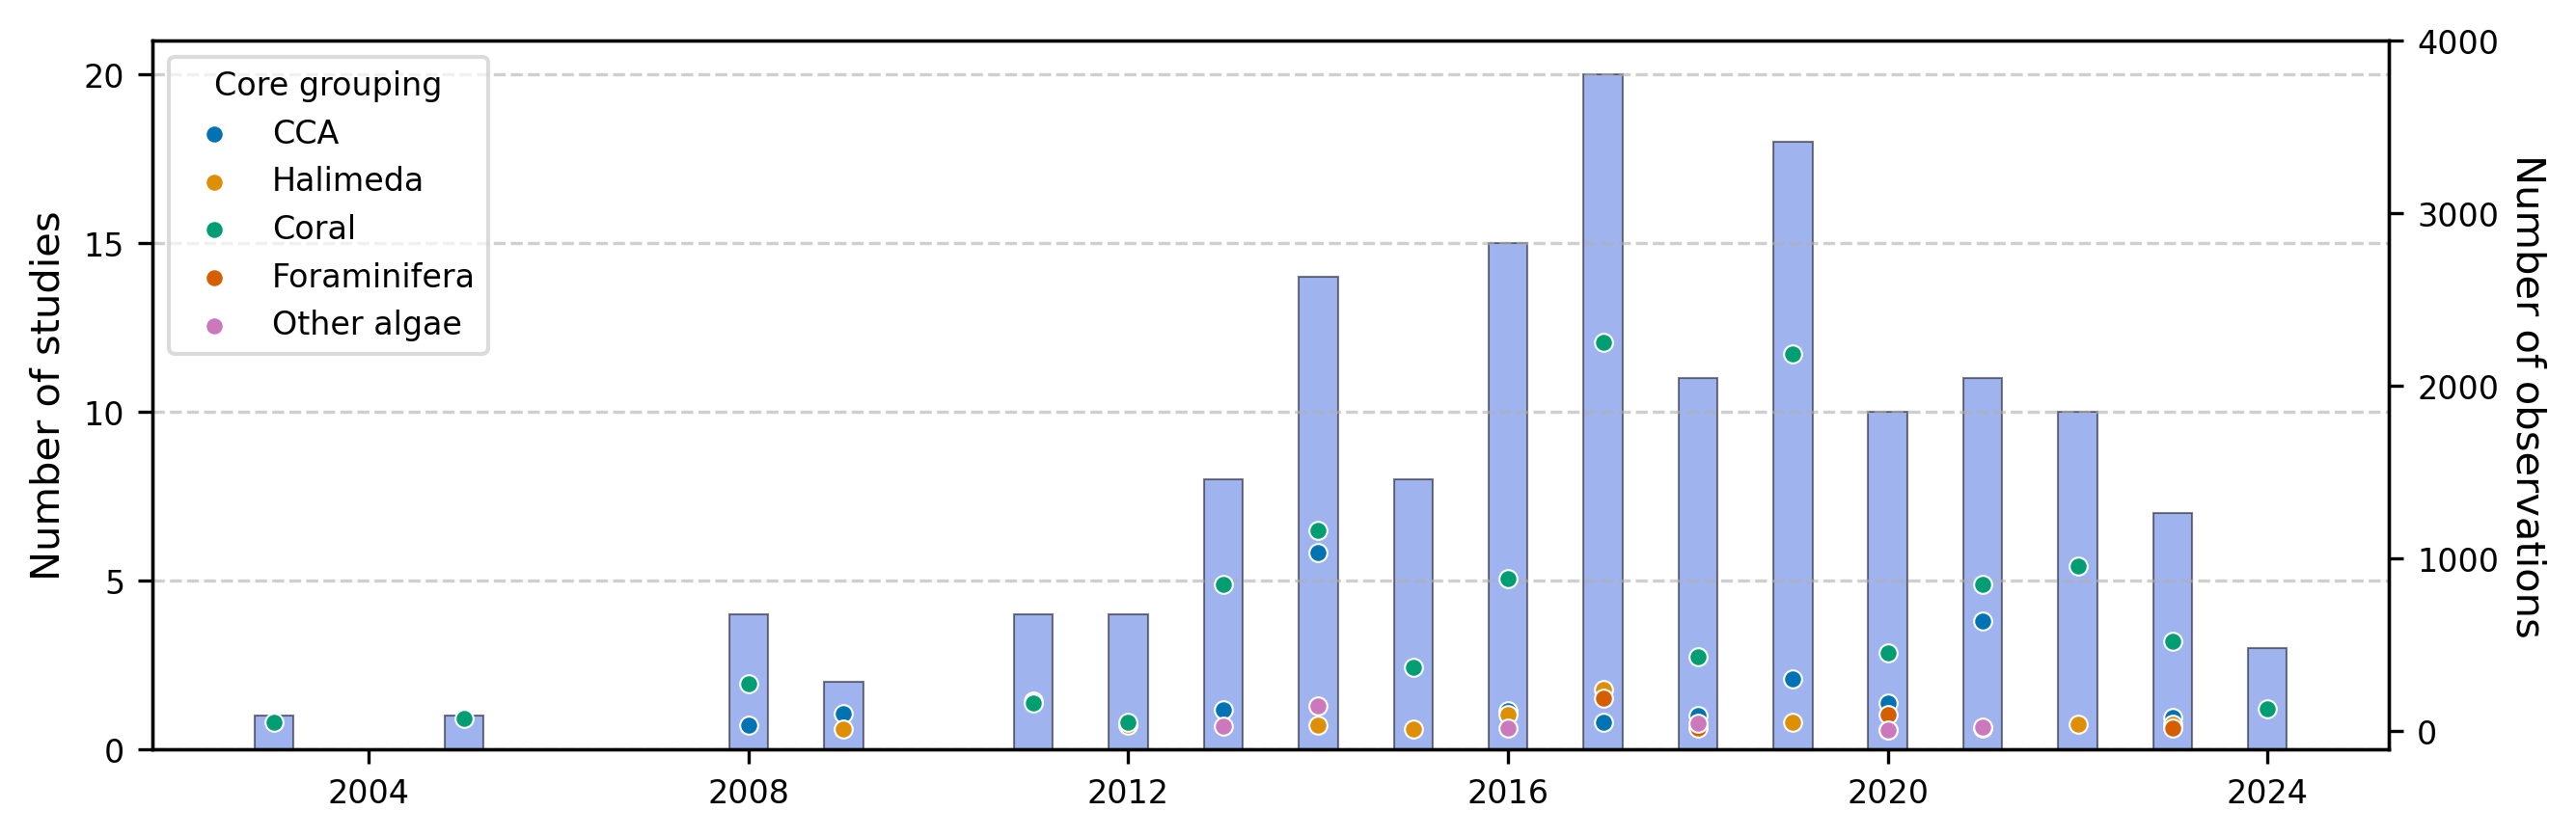

In [5]:
### plot temporal distribution of studies, broken down by species
data_exploration.plot_study_timeseries(working_df, colorby="core_grouping");

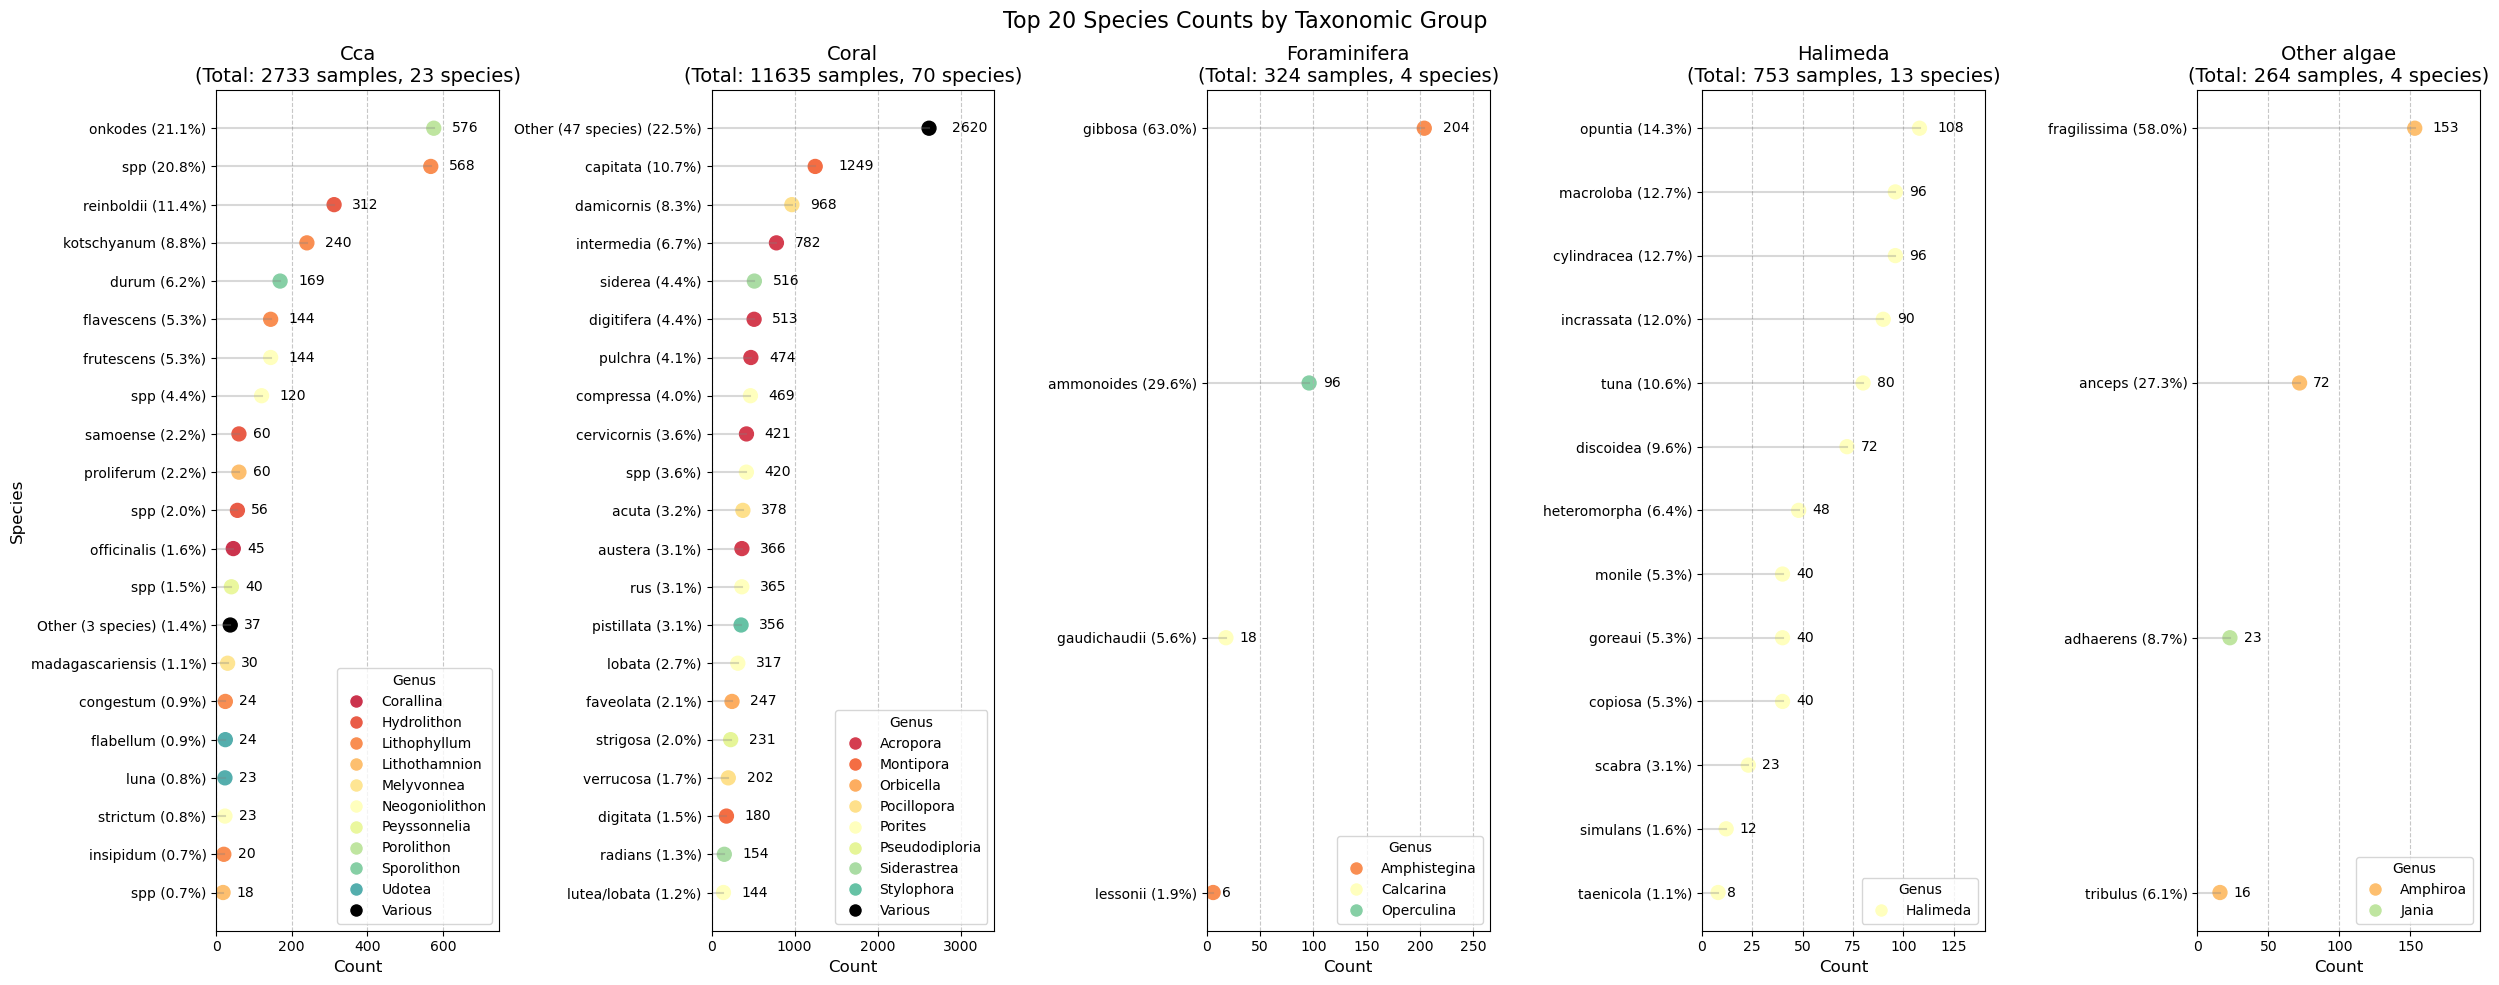

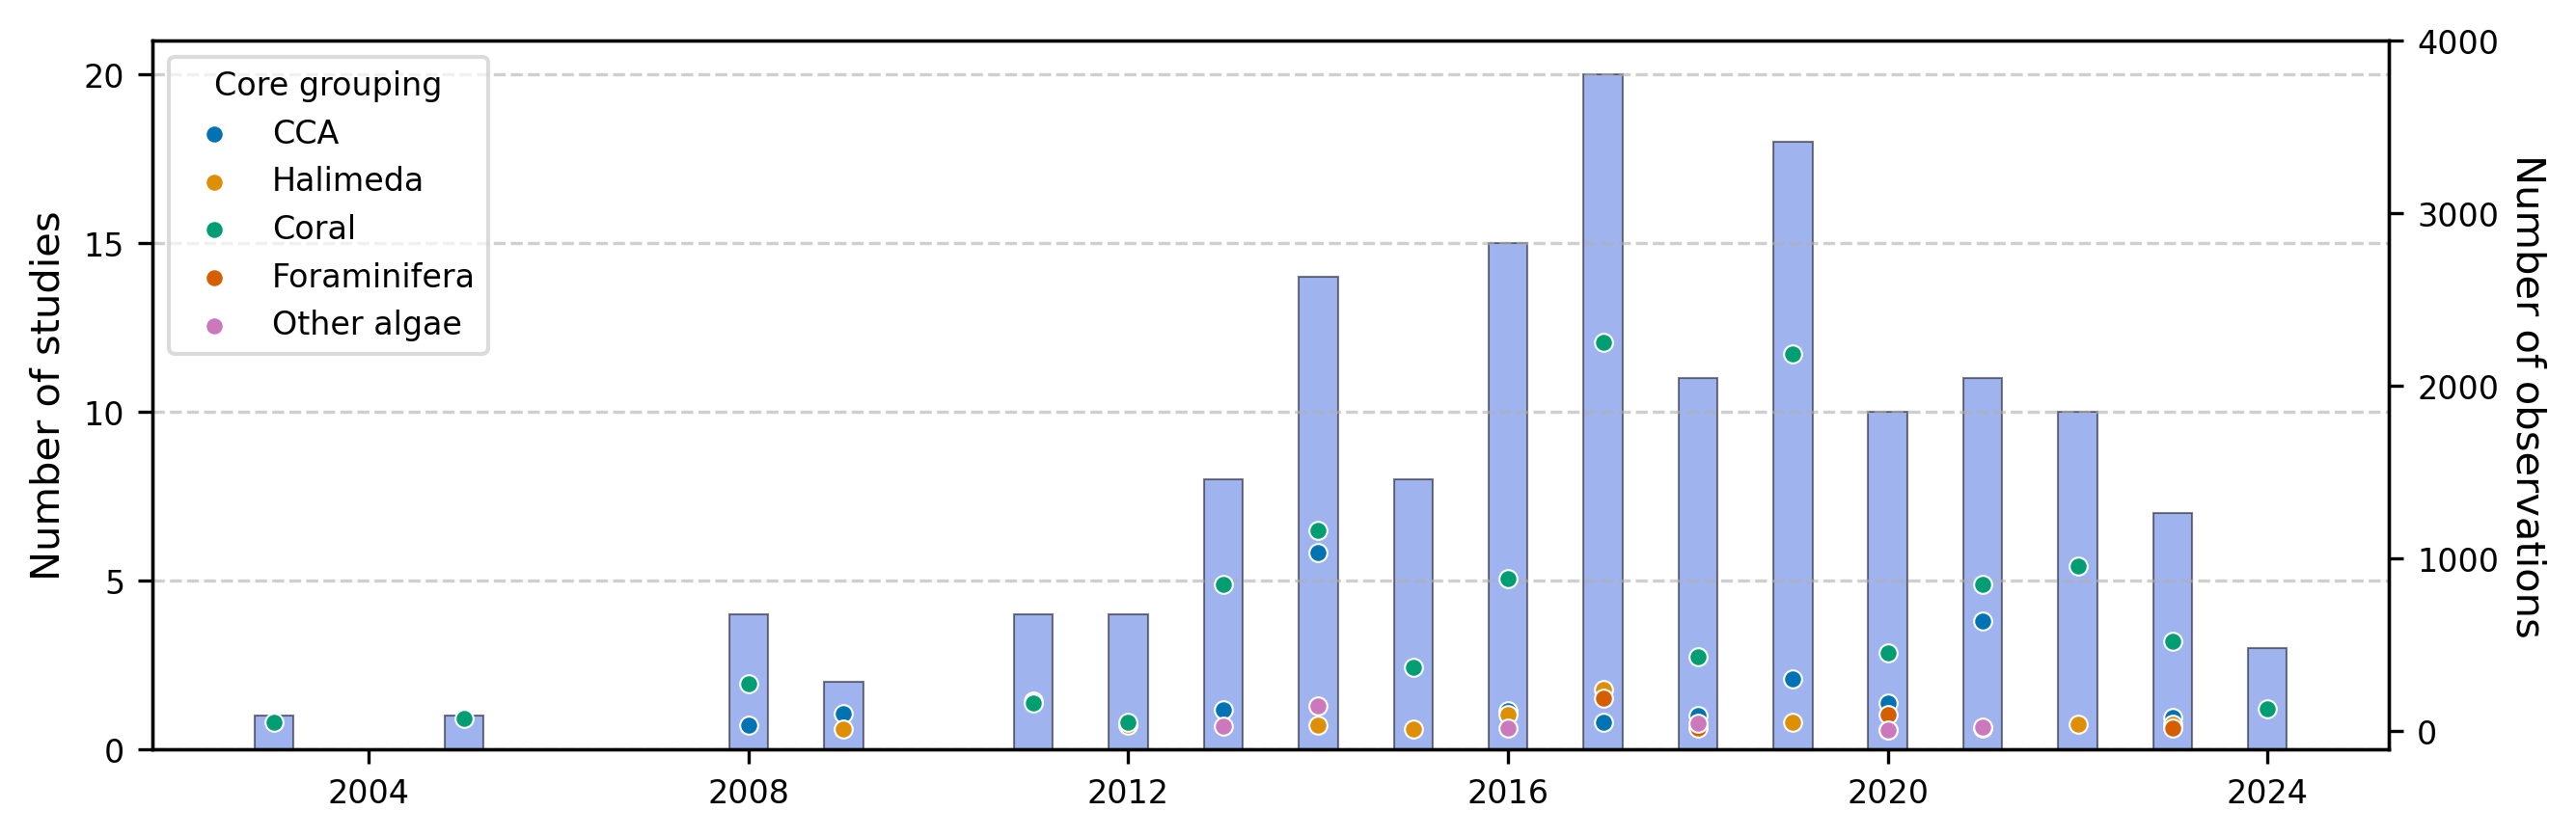

In [6]:
### plot taxonomic distribution of study organisms
data_exploration.create_faceted_dotplot_with_percentages(
    working_df, top_n=20, groupby="core_grouping"
)
### plot temporal distribution of studies, broken down by species
data_exploration.plot_study_timeseries(working_df, colorby="core_grouping");

## Units

### Occurences

Number of different calcification units: 88


(0.0, 271.70000000000005)

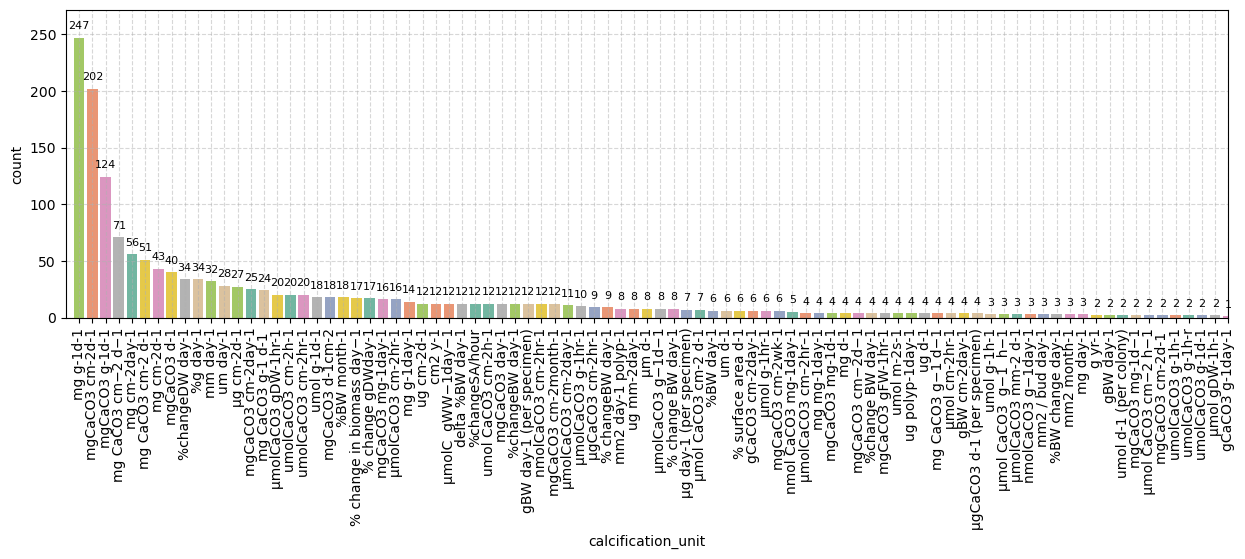

In [7]:
### visualising raw units
plt.figure(figsize=(15, 4))
count_order = (
    working_df["calcification_unit"].value_counts().index
)  # sort by number of counts for each calcification unit
sns.countplot(
    data=working_df,
    x="calcification_unit",
    order=count_order,
    palette="Set2",
    hue="calcification_unit",
)
plt.xticks(rotation=90)
plt.grid(ls="--", alpha=0.5)
for p in plt.gca().patches:
    plt.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
print(
    f"Number of different calcification units: {len(working_df['calcification_unit'].unique())}"
)
# adjust limits of axes to fit in the data more neatly
plt.xlim(-1, len(working_df["calcification_unit"].unique()) - 1)
plt.ylim(0, working_df["calcification_unit"].value_counts().max() * 1.1)

Number of distinct types of calcification measurement: 7


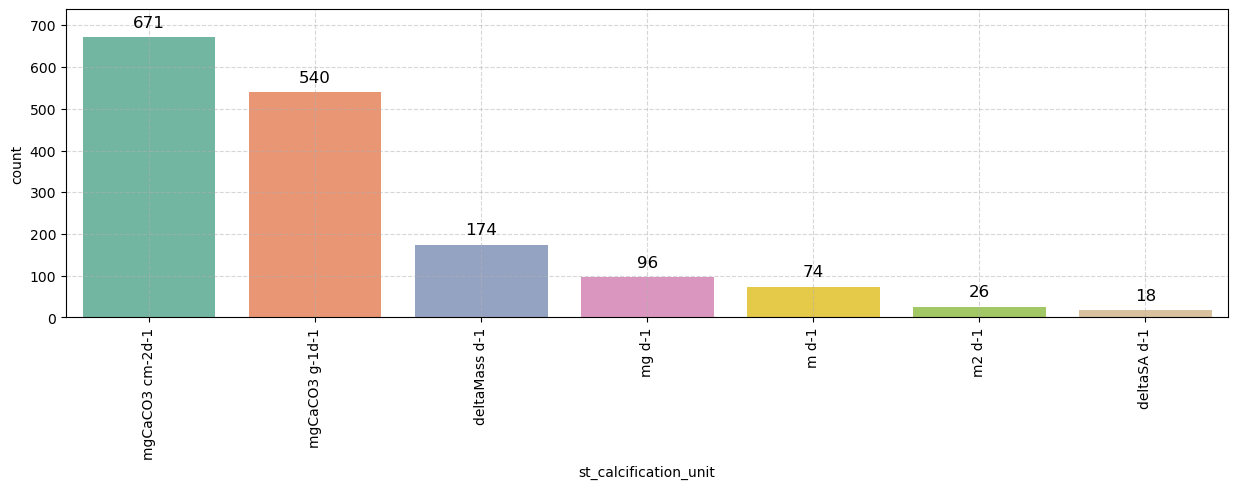

In [8]:
### visualising standardised units
plt.figure(figsize=(15, 4))
count_order = (
    working_df["st_calcification_unit"].value_counts().index
)  # sort by number of counts for each calcification unit
# plot
sns.countplot(
    data=working_df,
    x="st_calcification_unit",
    order=count_order,
    palette="Set2",
    hue="st_calcification_unit",
)
# format
plt.xticks(rotation=90)
plt.grid(ls="--", alpha=0.5)
for p in plt.gca().patches:
    plt.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.ylim(0, working_df["st_calcification_unit"].value_counts().max() * 1.1)
# report
print(
    f"Number of distinct types of calcification measurement: {len(working_df['st_calcification_unit'].unique())}"
)

Number of distinct types of calcification measurement: 7


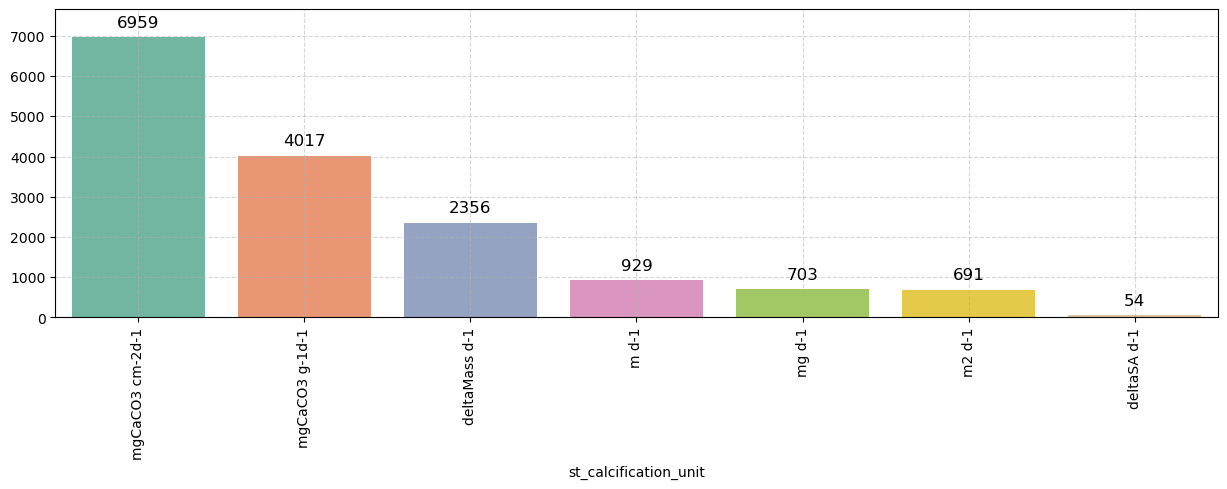

In [9]:
### visualising standardised units with total samples (n)
plt.figure(figsize=(15, 4))

unit_counts = (
    working_df.groupby("st_calcification_unit")["n"].sum().sort_values(ascending=False)
)  # group by 'st_calcification_unit' and sum the 'n' column
# plot
sns.barplot(
    x=unit_counts.index, y=unit_counts.values, palette="Set2", hue=unit_counts.index
)
# format
plt.xticks(rotation=90)
plt.grid(ls="--", alpha=0.5)
for i, value in enumerate(unit_counts.values):
    plt.annotate(
        f"{int(value)}",
        (i, value),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.ylim(0, unit_counts.max() * 1.1)
# report
print(f"Number of distinct types of calcification measurement: {len(unit_counts)}")

### Distributions

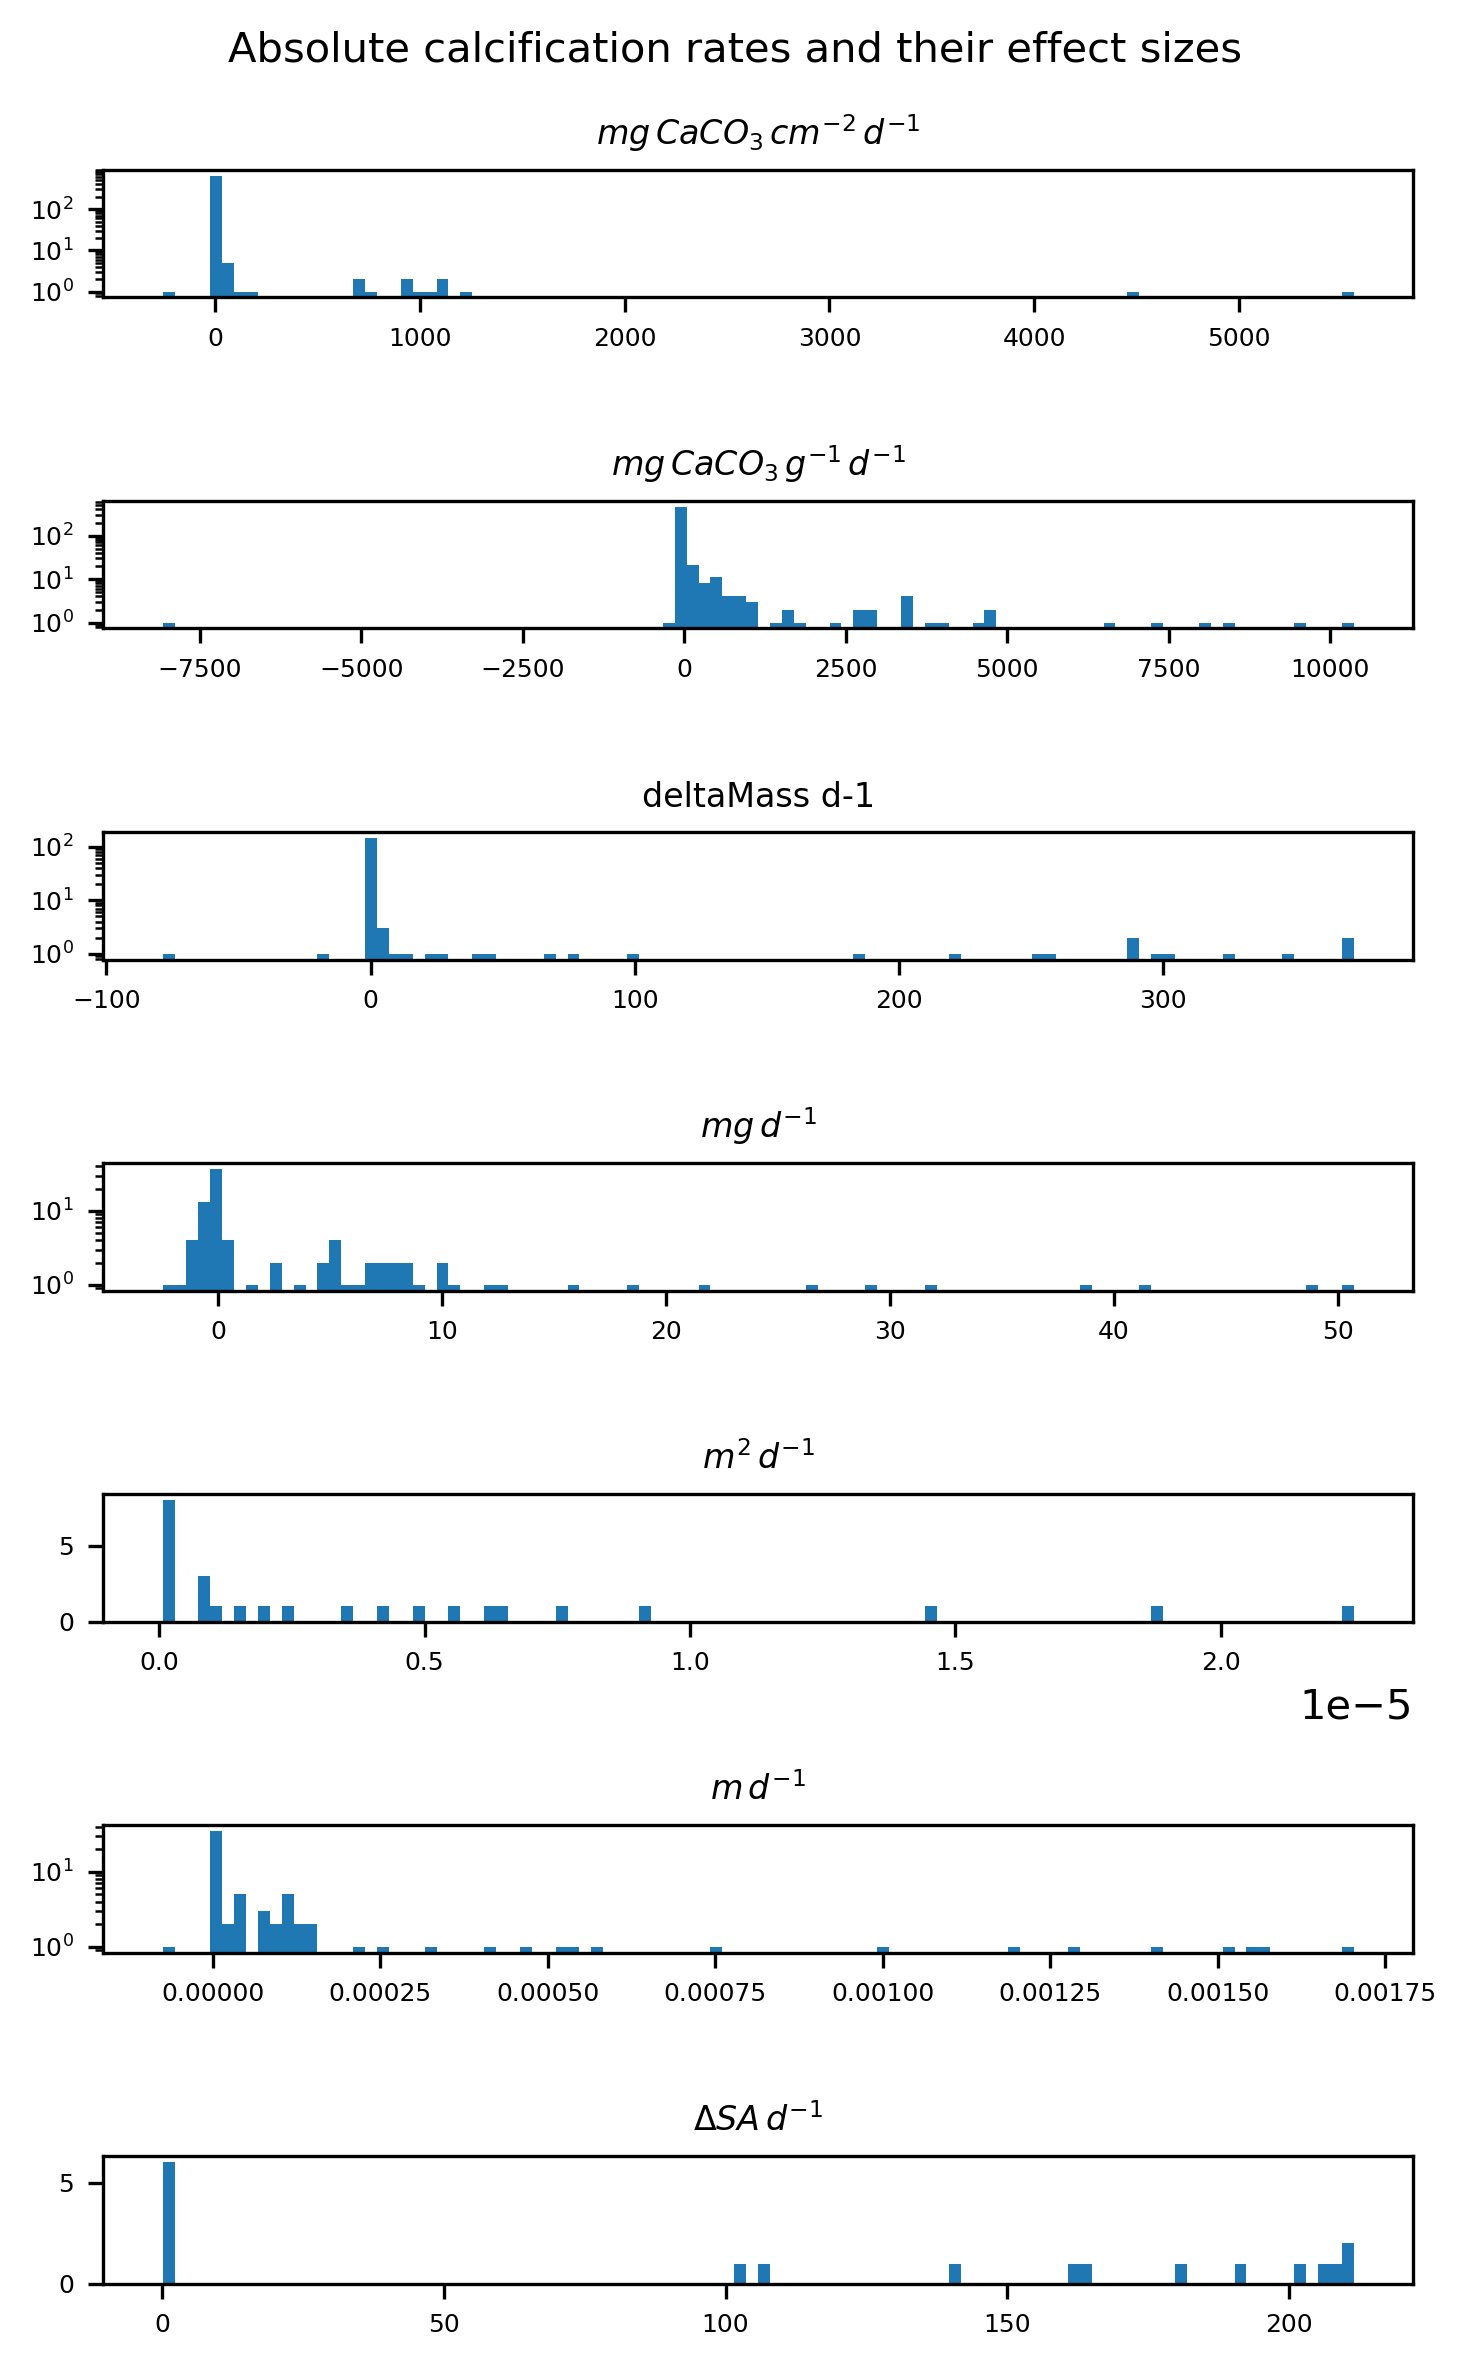

In [10]:
### visualise distributions of various calcification rates
rate_types = working_df["st_calcification_unit"].unique()
rate_types = [rate_type for rate_type in rate_types if rate_type != ""]
fig, axes = plt.subplots(len(rate_types), 1, figsize=(5, 8), dpi=300)

for i, rate_type in enumerate(rate_types):
    axes[i].hist(
        working_df[working_df["st_calcification_unit"] == rate_type][
            "st_calcification"
        ],
        bins=100,
    )
    axes[i].set_title(
        f"{plot_config.RATE_TYPE_MAPPING.get(rate_type, rate_type)}", fontsize=8
    )

# format
for ax in axes.flatten():
    if max([p.get_height() for p in ax.patches]) > 10:
        ax.set_yscale("log")
    ax.tick_params(
        axis="both", which="major", labelsize=6
    )  # Adjust label size for both axes
plt.suptitle("Absolute calcification rates and their effect sizes", fontsize=10)
plt.tight_layout()

## Climatology

In [11]:
### investigate any studies which have missing or aquaria locations
missing_coords = working_df[working_df.latitude.isna() | working_df.longitude.isna()]
print(f"Number of rows without lat/lon coordinates: {len(missing_coords)}.")
print(
    f"These correspond to the following locations: {missing_coords.drop_duplicates('doi', keep='first').location.values}."
)

aquaria_locations = working_df[
    working_df["location"].str.lower().str.contains("aquar", na=False)
]
additional_rows = set(
    aquaria_locations.drop_duplicates("doi", keep="first").location.values
) - set(missing_coords.drop_duplicates("doi", keep="first").location.values)
print(
    f"In addition, the following are aquaria with location information: {list(additional_rows)}."
)
print(
    f"...corresponding to {len(aquaria_locations) - len(missing_coords)} additional rows."
)
print(
    f"This makes {len(missing_coords) + len(additional_rows)} rows with spurious or missing location information."
)

Number of rows without lat/lon coordinates: 49.
These correspond to the following locations: ['Aquarium' 'Aquarium' 'M' 'M' 'Indo-Pacific'].
In addition, the following are aquaria with location information: ['Aquarium, Monaco', 'Aquaria, from Fiji', 'Cairns Marine Ltd - aquarium', 'Fiji, UK aquarium', 'Aquarium (Portugal)'].
...corresponding to 36 additional rows.
This makes 54 rows with spurious or missing location information.


In [12]:
### load climatology data
ph_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / "locations.yaml",
)

sst_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / "locations.yaml",
)

merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)  # concatenated sst and ph climatology dataframes

# prepare dataframes and merge
merged_clim_df_mi = merged_clim_df.set_index(
    ["doi", "location", "longitude", "latitude"]
)
working_df_mi = working_df.set_index(["doi", "location", "longitude", "latitude"])
working_clim_df = working_df_mi.join(merged_clim_df_mi, how="inner")

print(
    f"There are {len(merged_clim_df_mi.index.unique())} unique locations in the climatology data compared with {len(working_df.drop_duplicates('doi', keep='first'))} location counts in the working dataframe."
)

# exclude locations mentioning non-tropical ranges, so retrieved climatology data is not relevant
working_clim_df = working_clim_df[
    ~working_clim_df.index.get_level_values("location").str.contains(
        "monaco|portugal|uk", case=False, na=False
    )
]

There are 198 unique locations in the climatology data compared with 150 location counts in the working dataframe.


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing/processing.py:674: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"2021_2040": 2030, "2041_2060": 2050, "2081_2100": 2090})
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing/processing.py:674: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"2021_2040": 2030, "2041_2060": 2050, "2081_2100": 2090})


In [13]:
### calculate the global average anomalies for each scenario and time_frame
future_global_anomaly_df = (
    working_clim_df.reset_index()
    .groupby(["scenario", "time_frame"])
    .agg(
        mean_sst_anomaly=("mean_sst_20y_anomaly_ensemble", "mean"),
        mean_ph_anomaly=("mean_ph_20y_anomaly_ensemble", "mean"),
    )
    .reset_index()
)
future_global_anomaly_df.head()

scenario  time_frame  mean_sst_anomaly  mean_ph_anomaly
0   ssp126        2030          0.739994        -0.065401
1   ssp126        2050          0.999110        -0.090575
2   ssp126        2090          1.110667        -0.085185
3   ssp245        2030          0.733431        -0.069309
4   ssp245        2050          1.173379        -0.116831

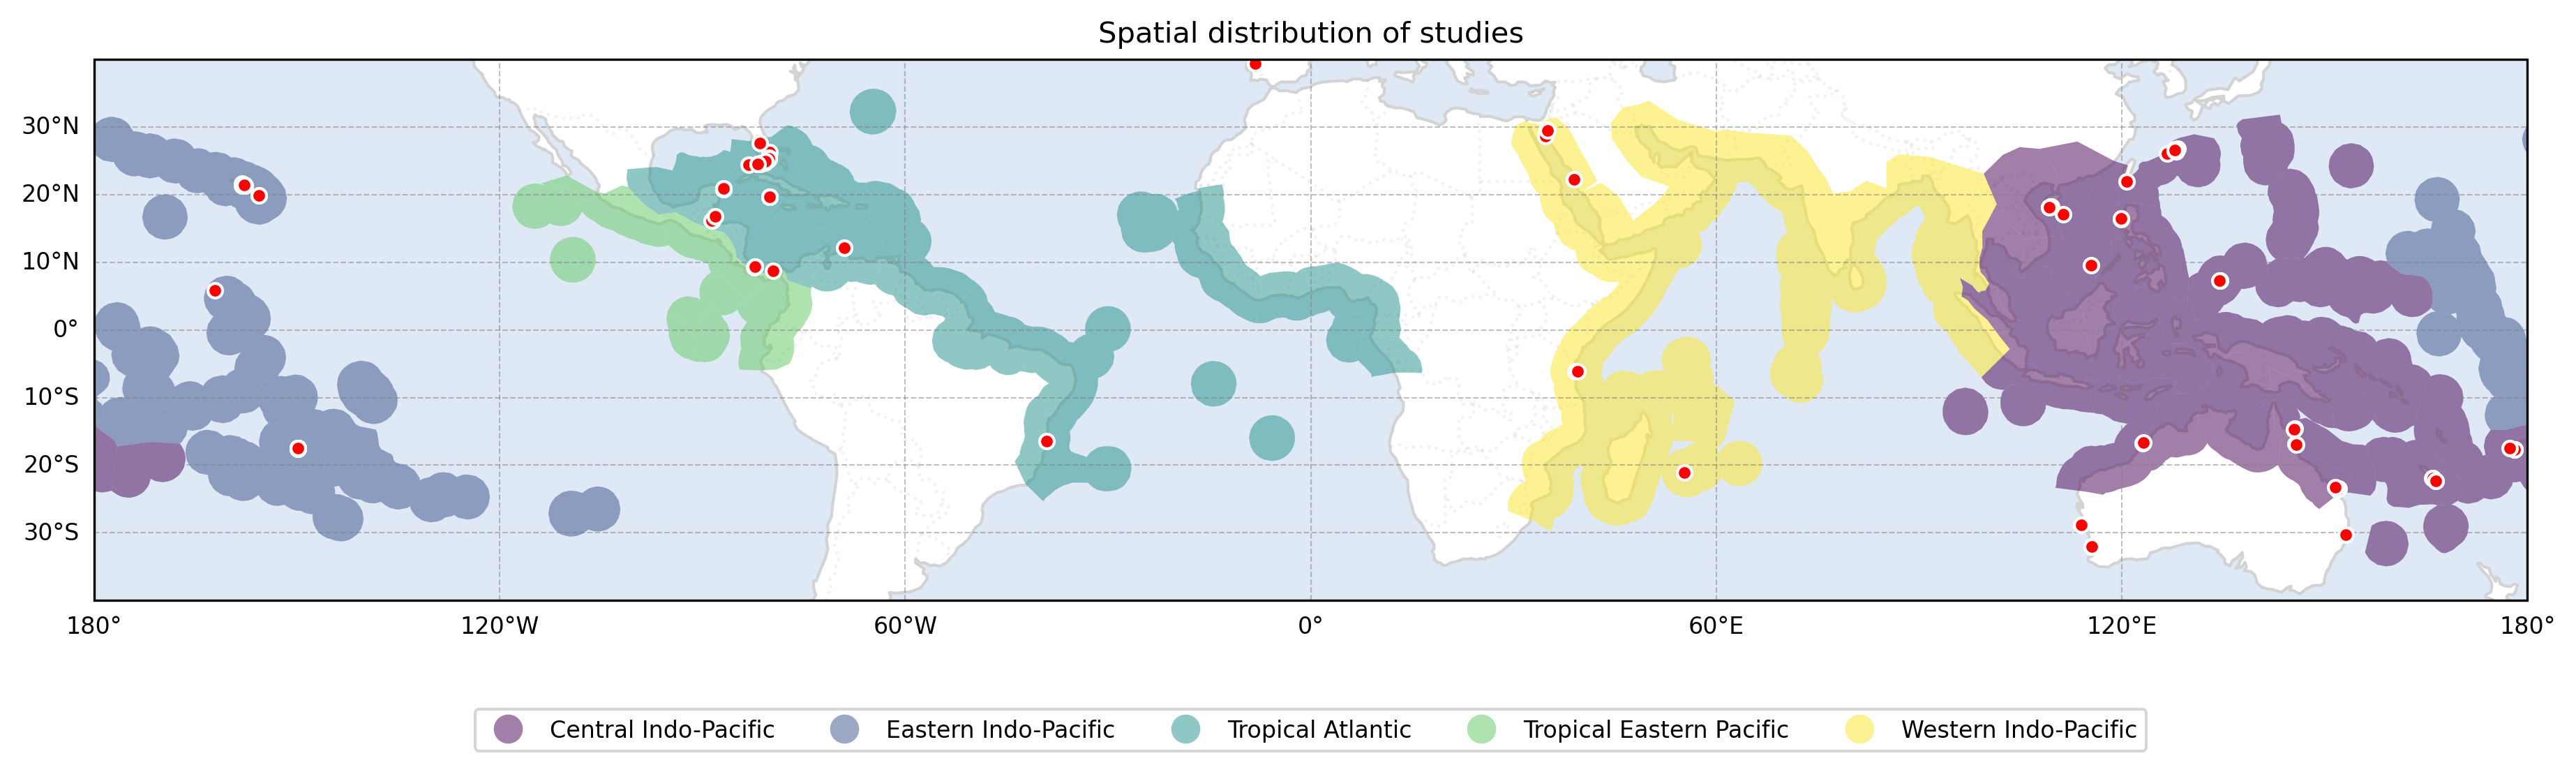

(<Figure size 4500x3000 with 1 Axes>,
 <GeoAxes: title={'center': 'Spatial distribution of studies'}>)

In [14]:
### visualise study distribution
locations.plot_areas_with_study_locations(
    working_df.drop_duplicates("doi", keep="first")
)

#### Visualising spatial trends in climatological variables for different warming scenarios

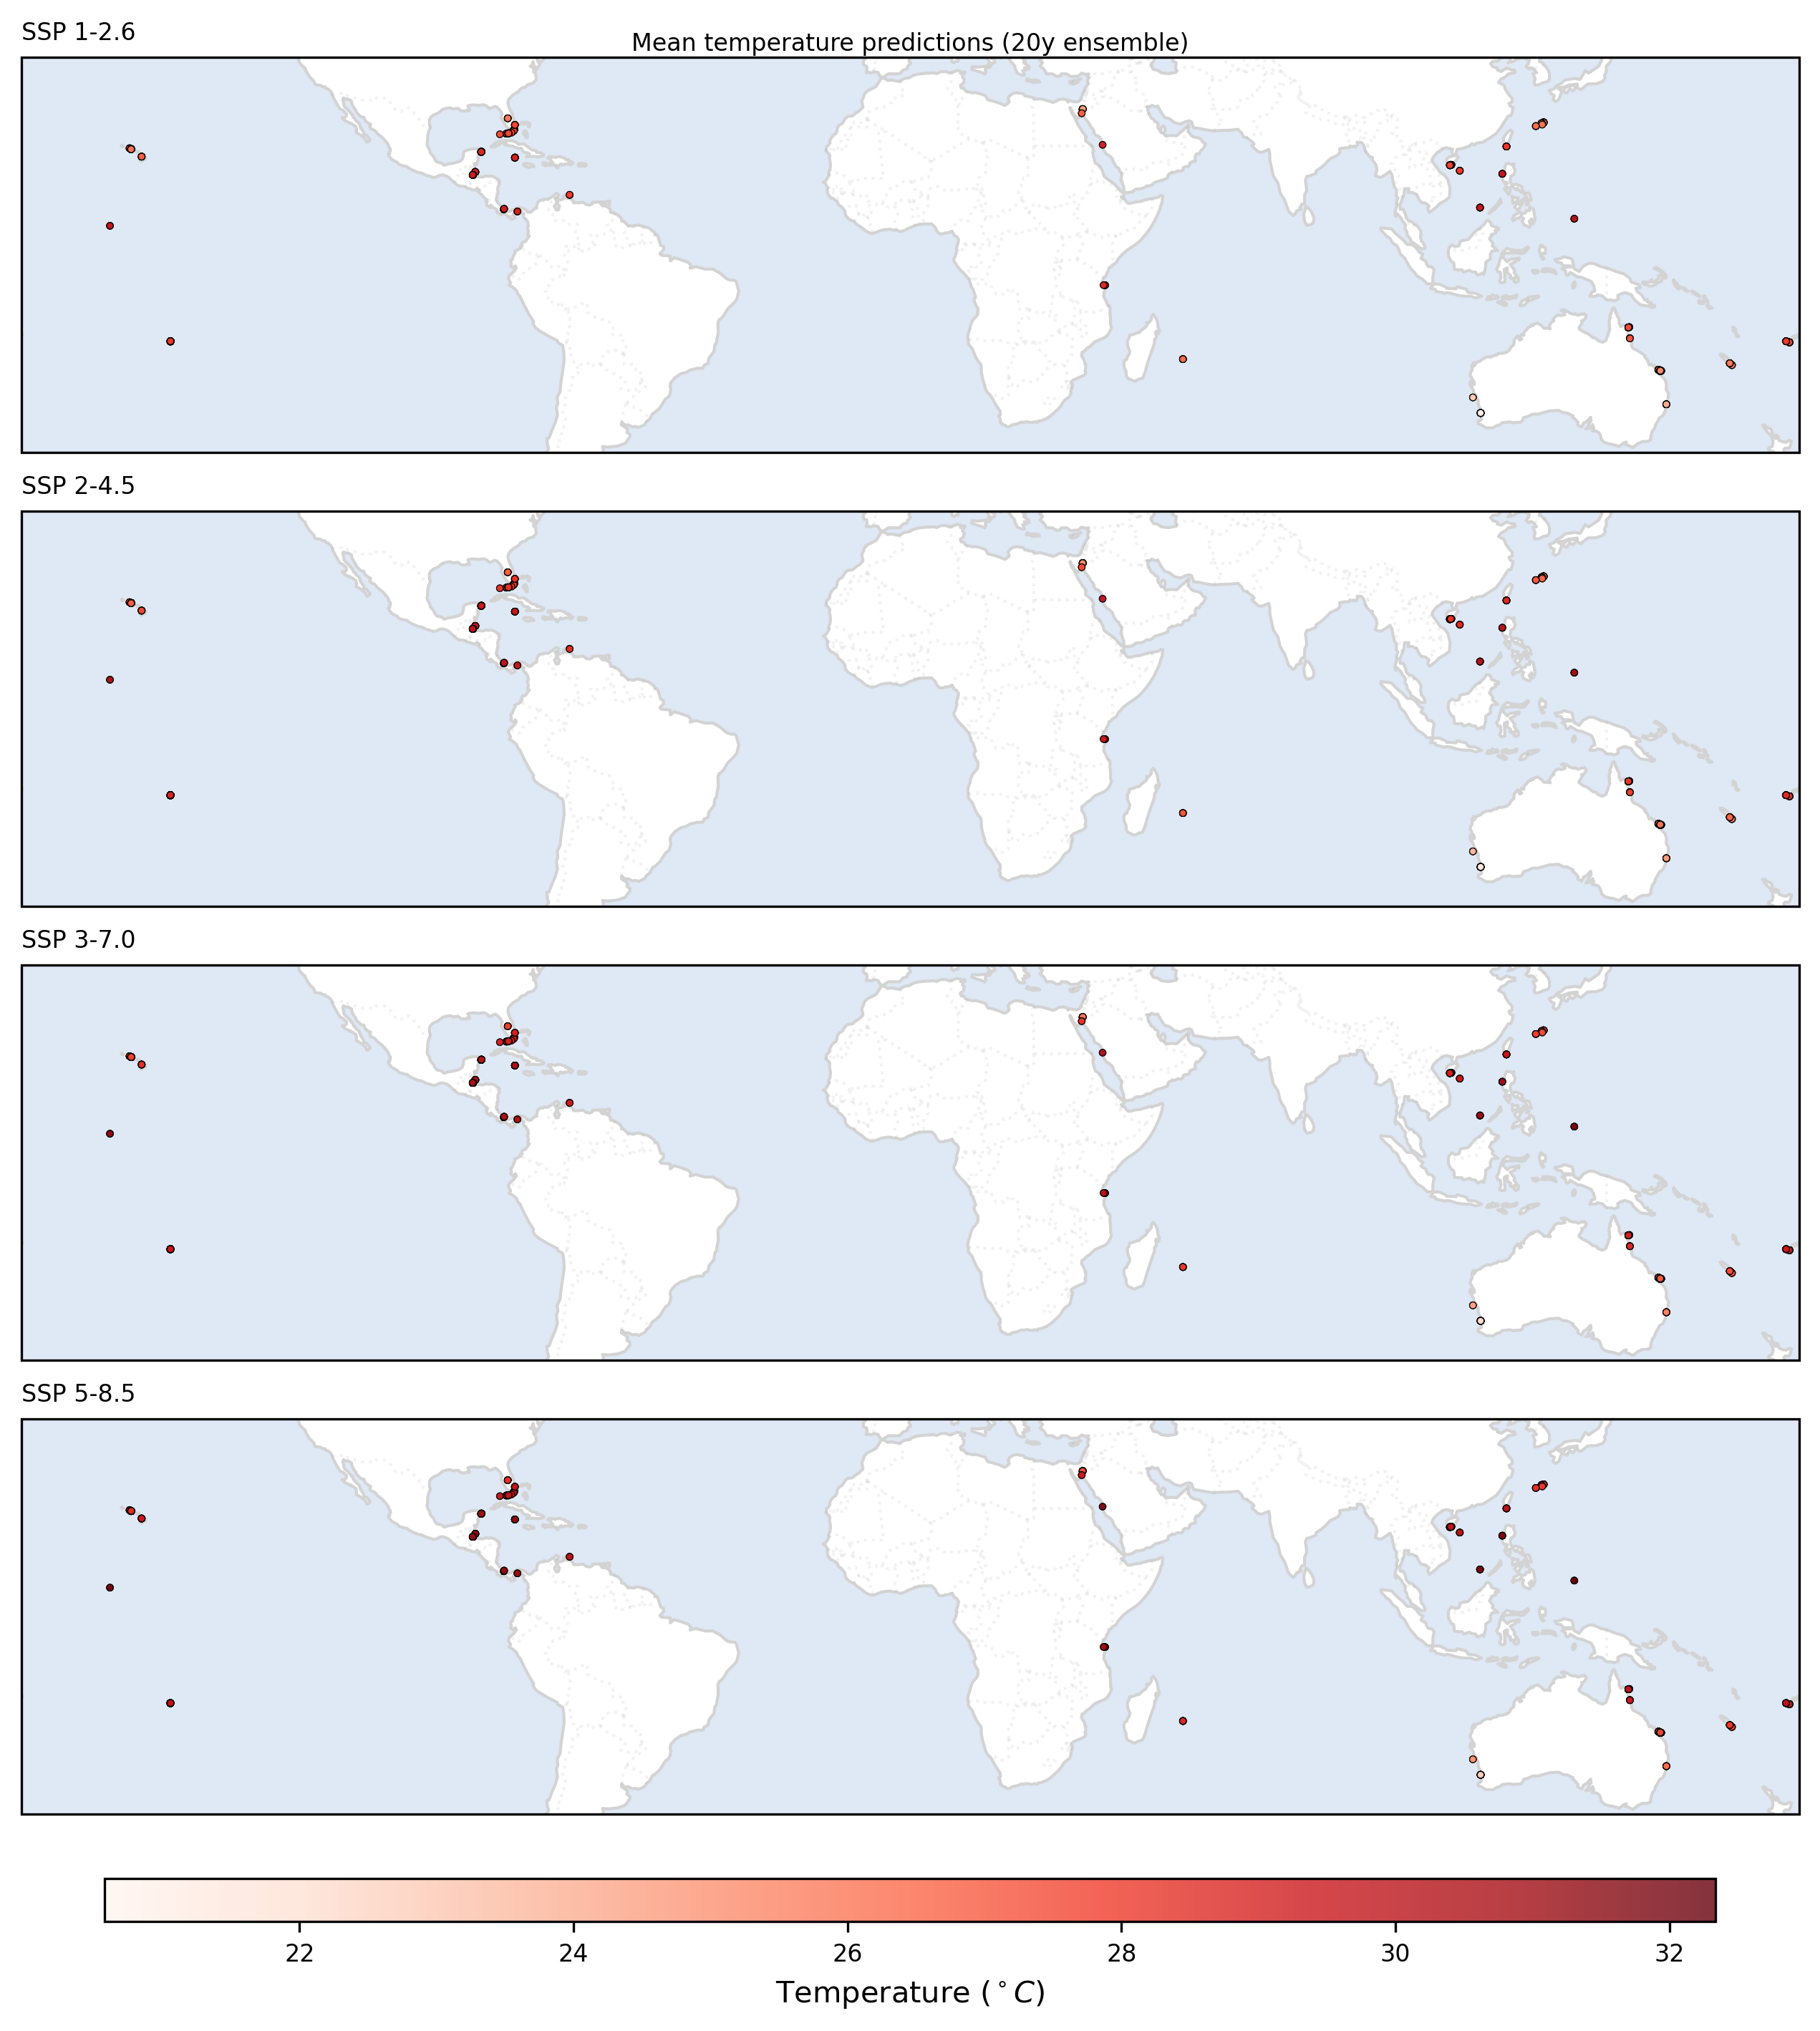

In [15]:
### visualise forecasted mean temperatures, by SSP
fig, axes = climatology.plot_spatial_effect_distribution(
    working_clim_df.reset_index(),
    var_to_plot="mean_sst_20y_ensemble",
    title="Mean temperature predictions (20y ensemble)",
    cbar_label="Temperature ($^\\circ C$)",
    reverse_cmap=False,
)

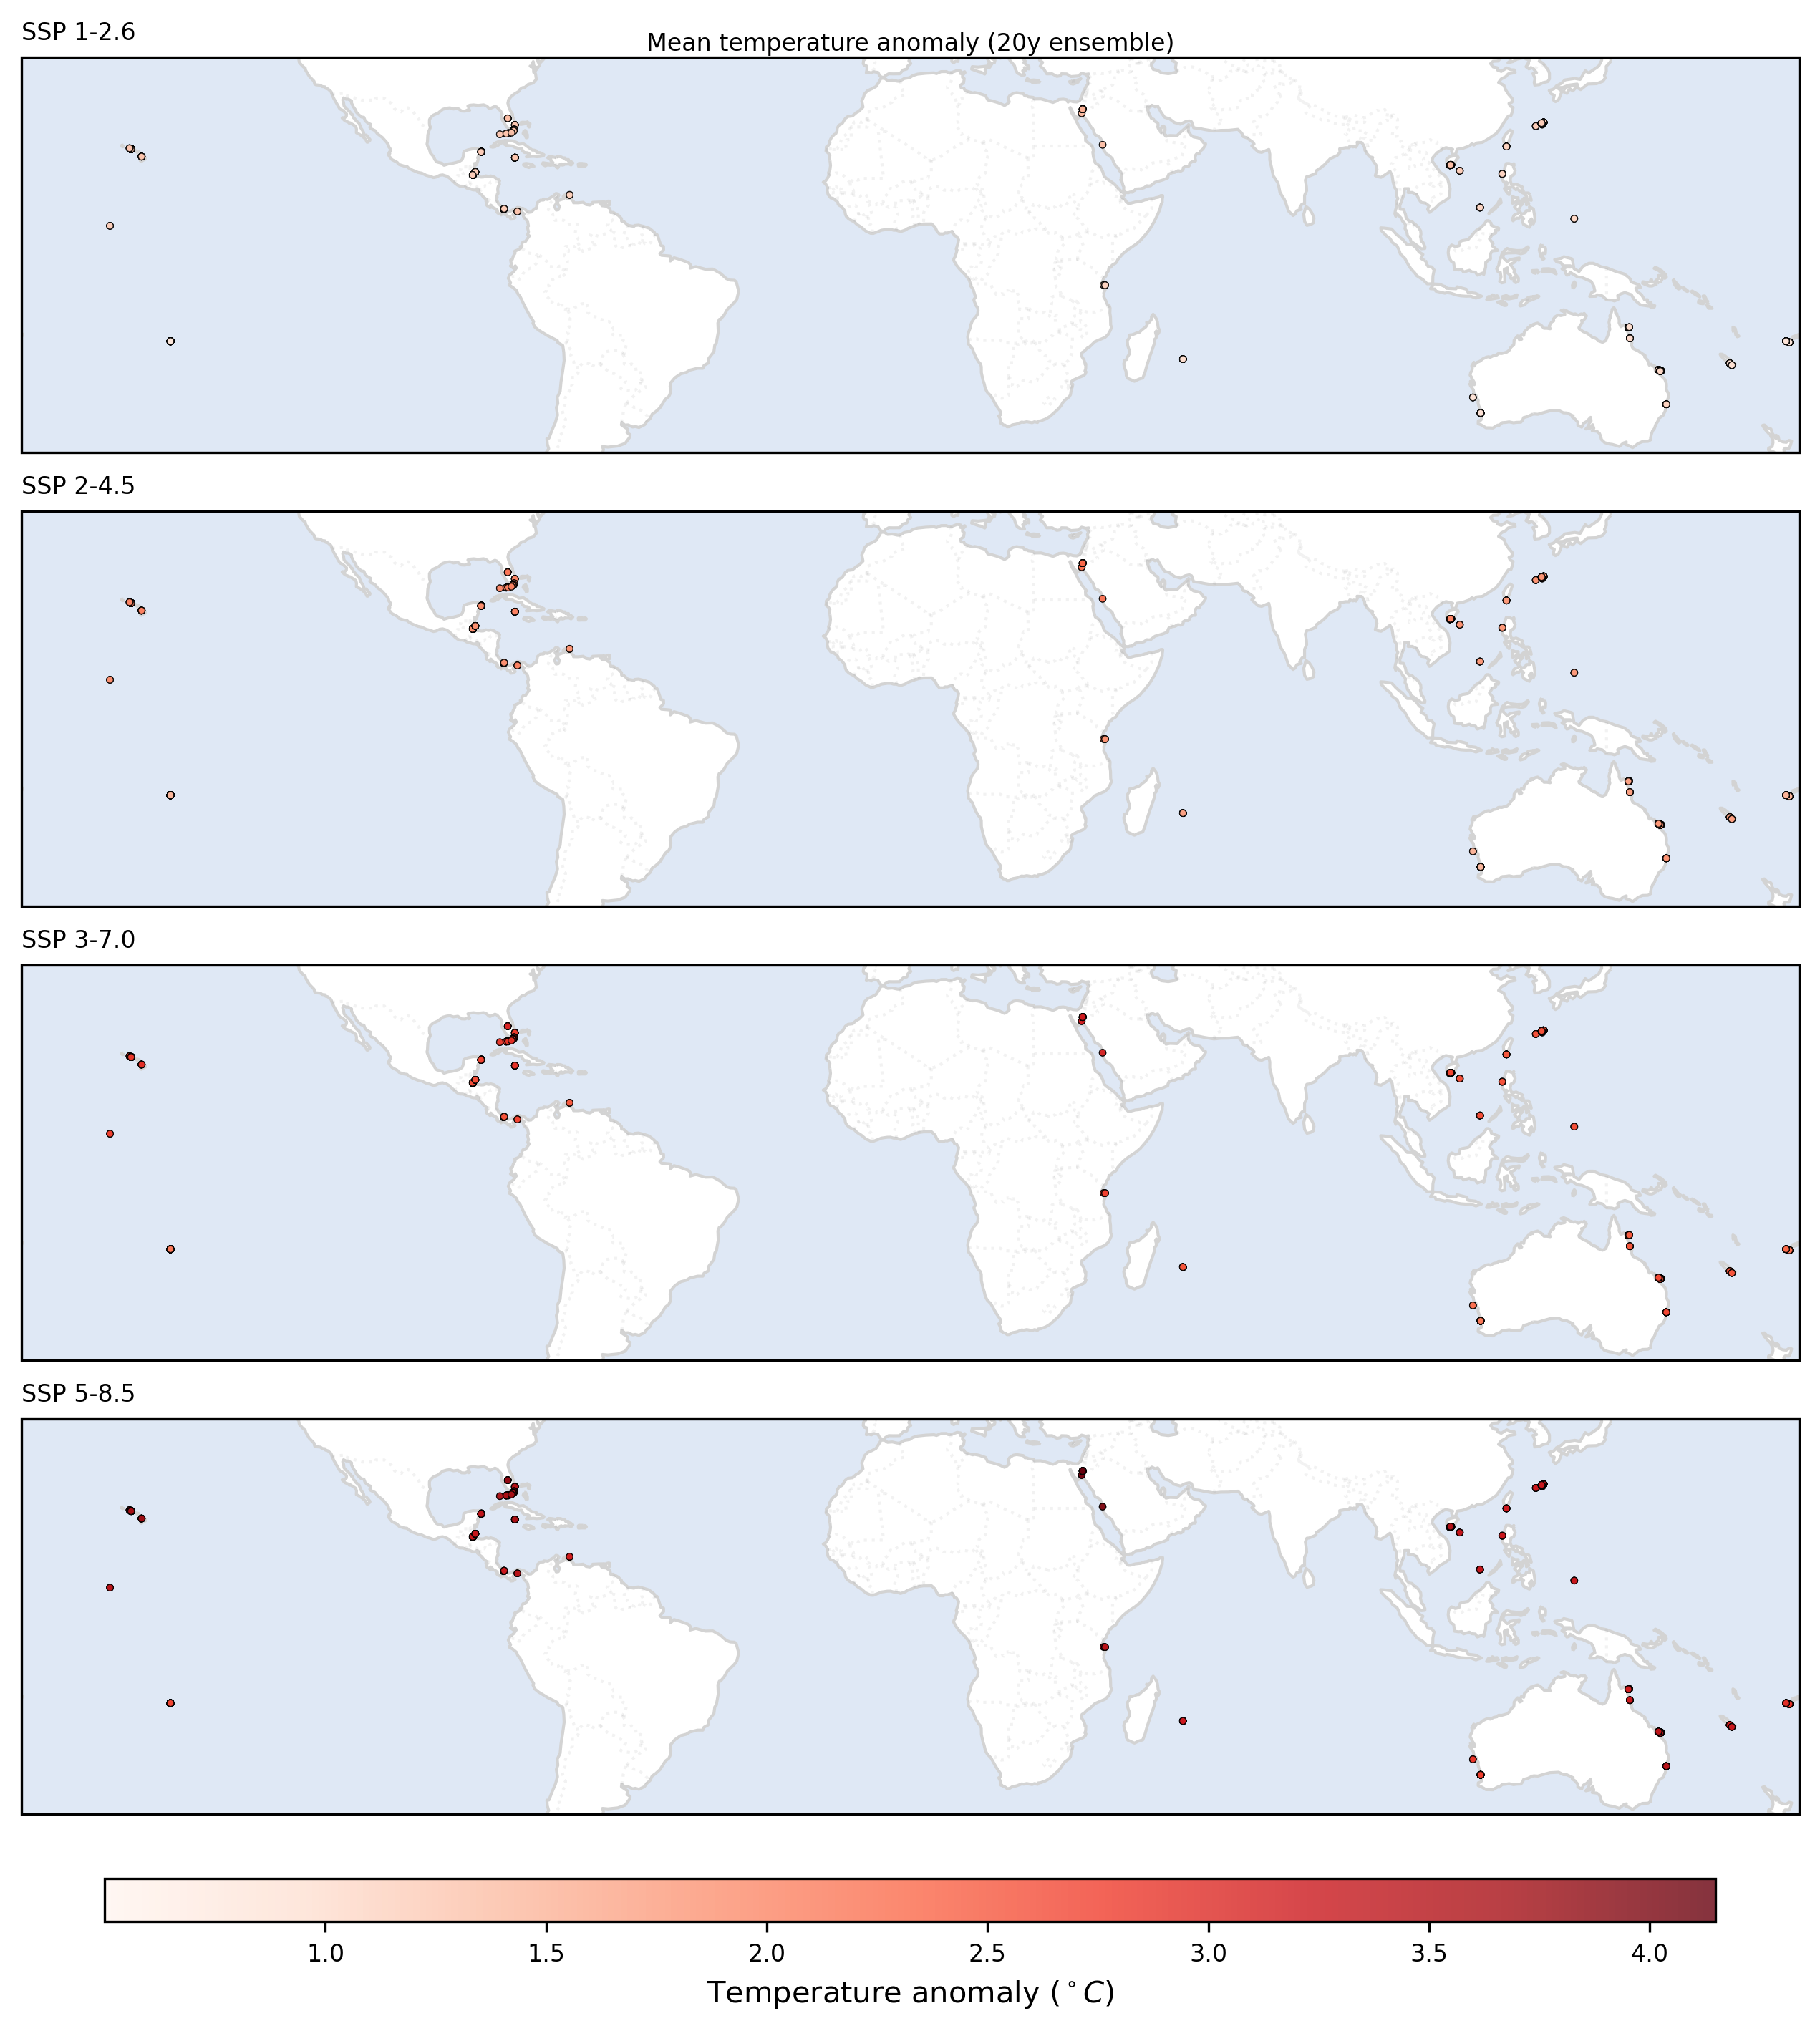

In [16]:
### visualise forecasted mean temperature anomalies, by SSP
fig, axes = climatology.plot_spatial_effect_distribution(
    working_clim_df.reset_index(),
    var_to_plot="mean_sst_20y_anomaly_ensemble",
    title="Mean temperature anomaly (20y ensemble)",
    cbar_label="Temperature anomaly ($^\\circ C$)",
    reverse_cmap=False,
)

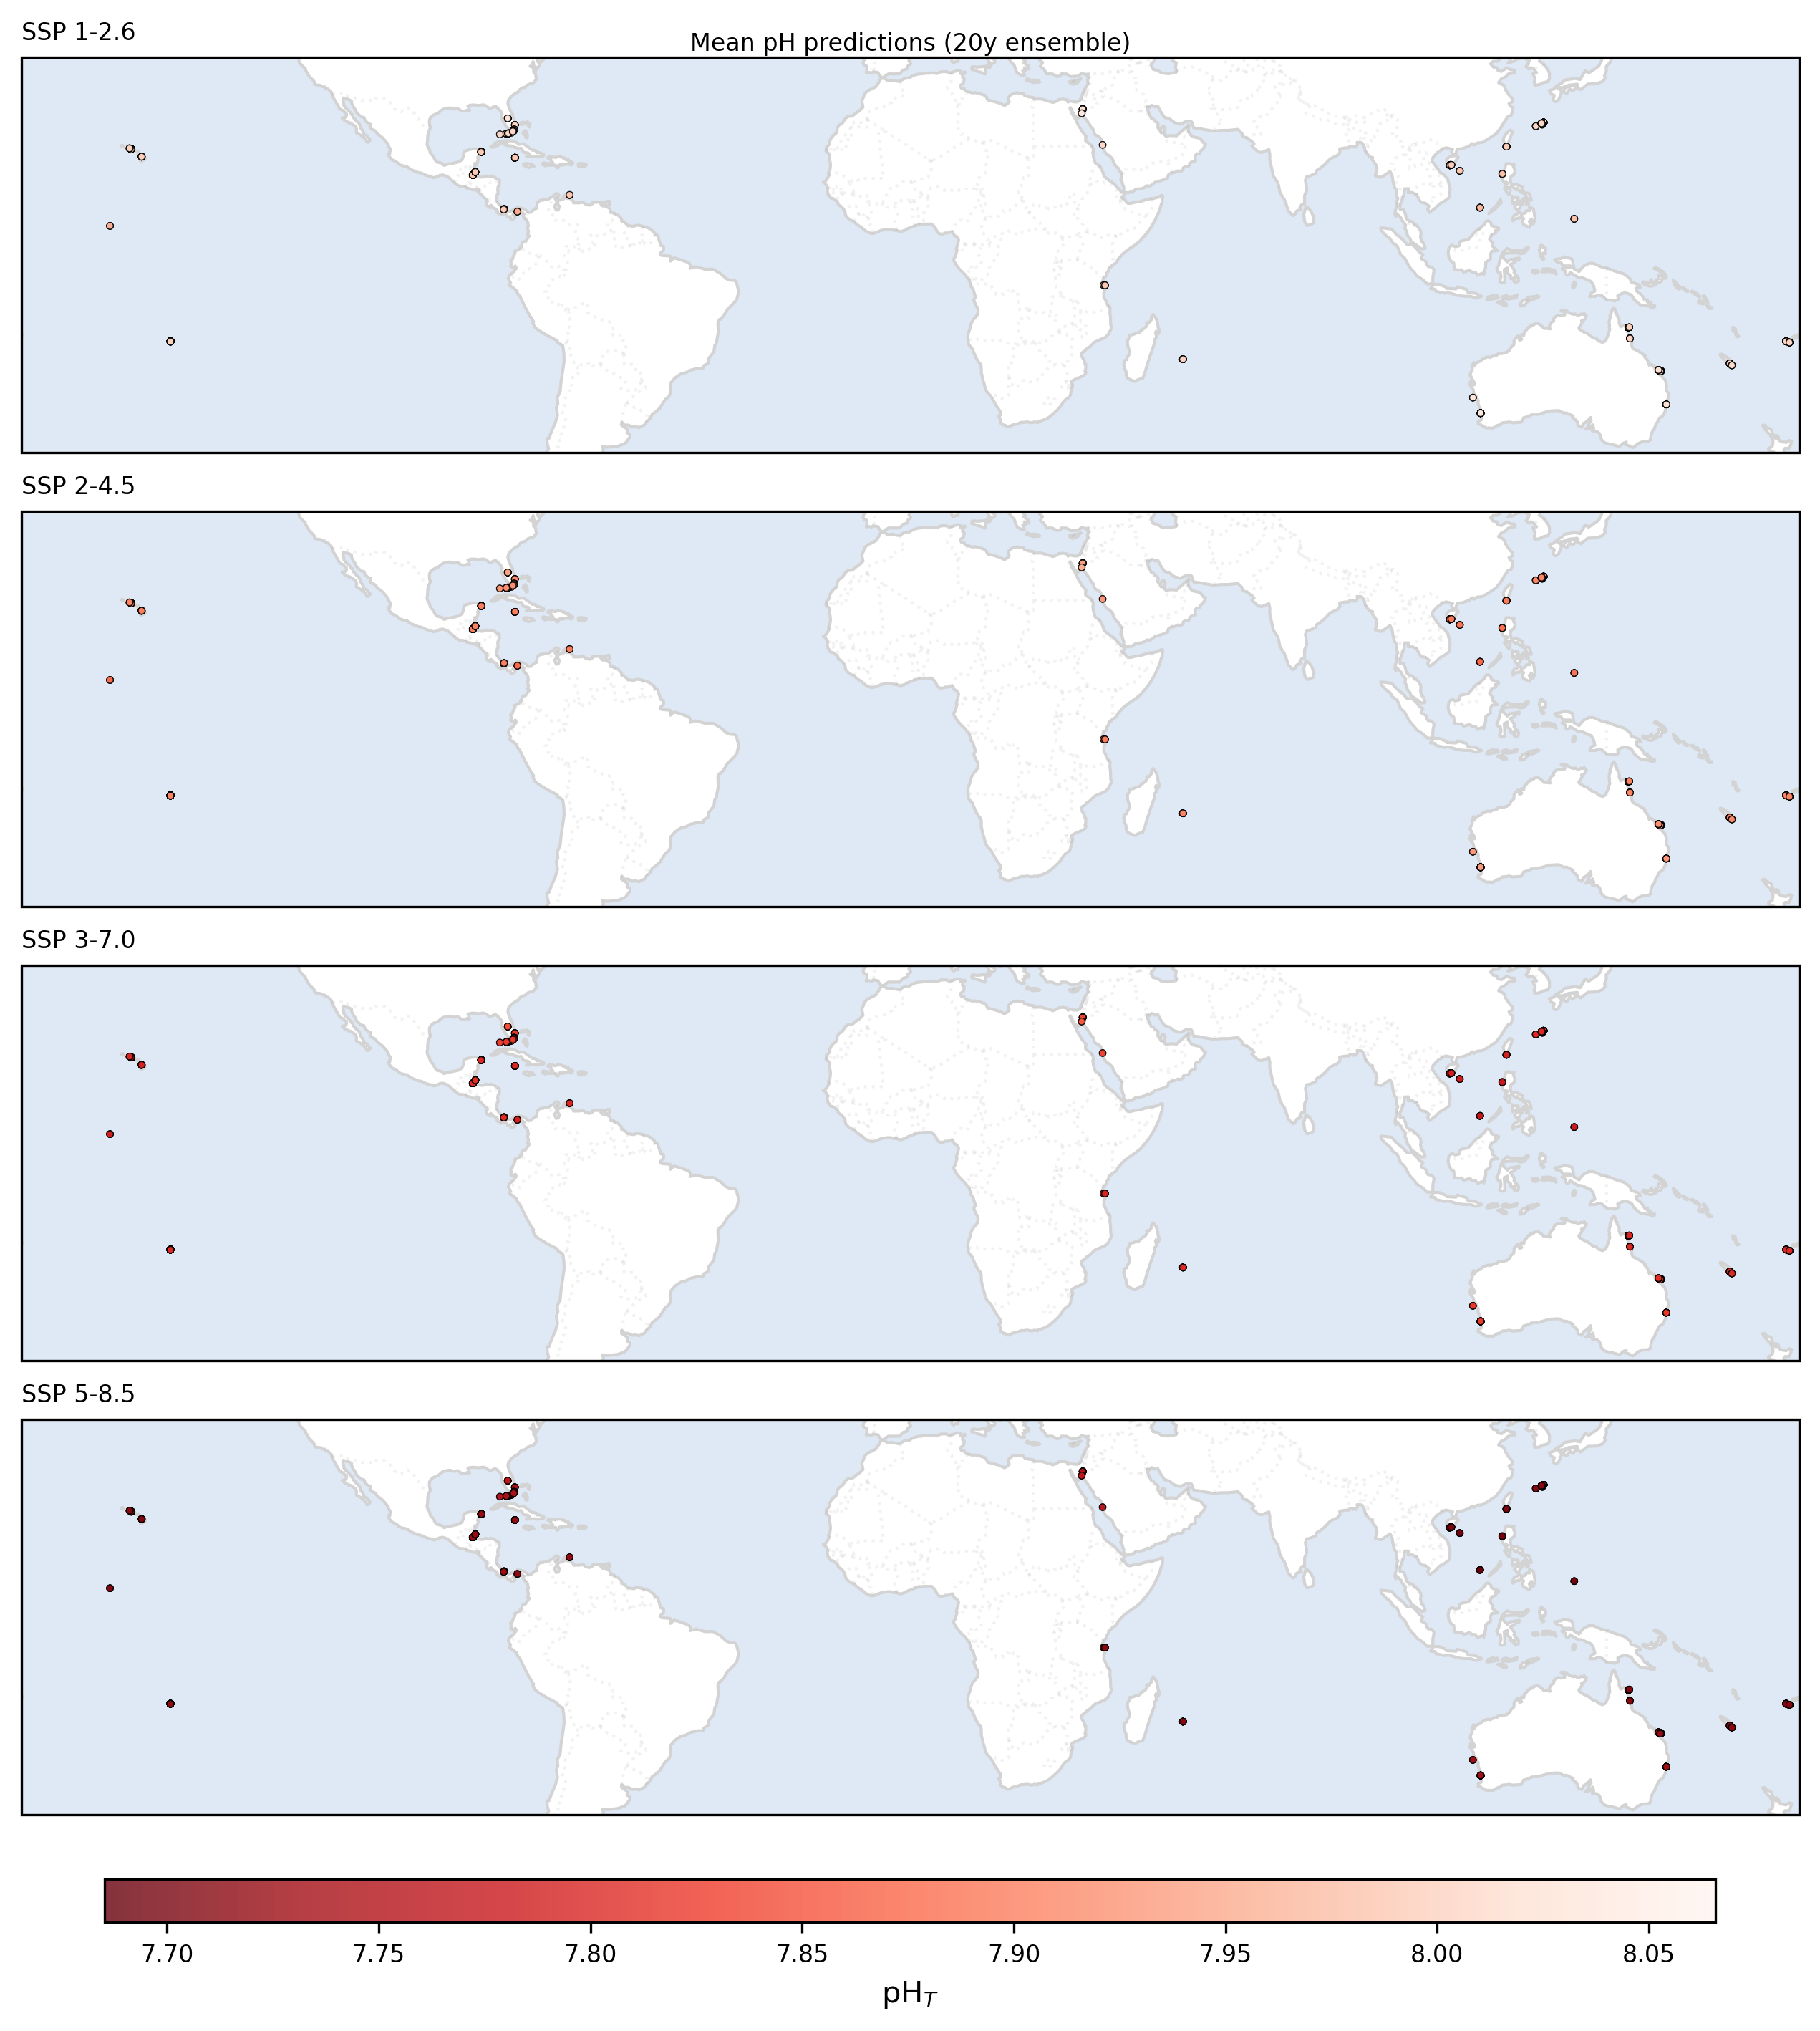

In [17]:
### visualise forecasted mean pH, by SSP
fig, axes = climatology.plot_spatial_effect_distribution(
    working_clim_df.reset_index(),
    var_to_plot="mean_ph_20y_ensemble",
    title="Mean pH predictions (20y ensemble)",
    cbar_label="pH$_T$",
    reverse_cmap=True,
)

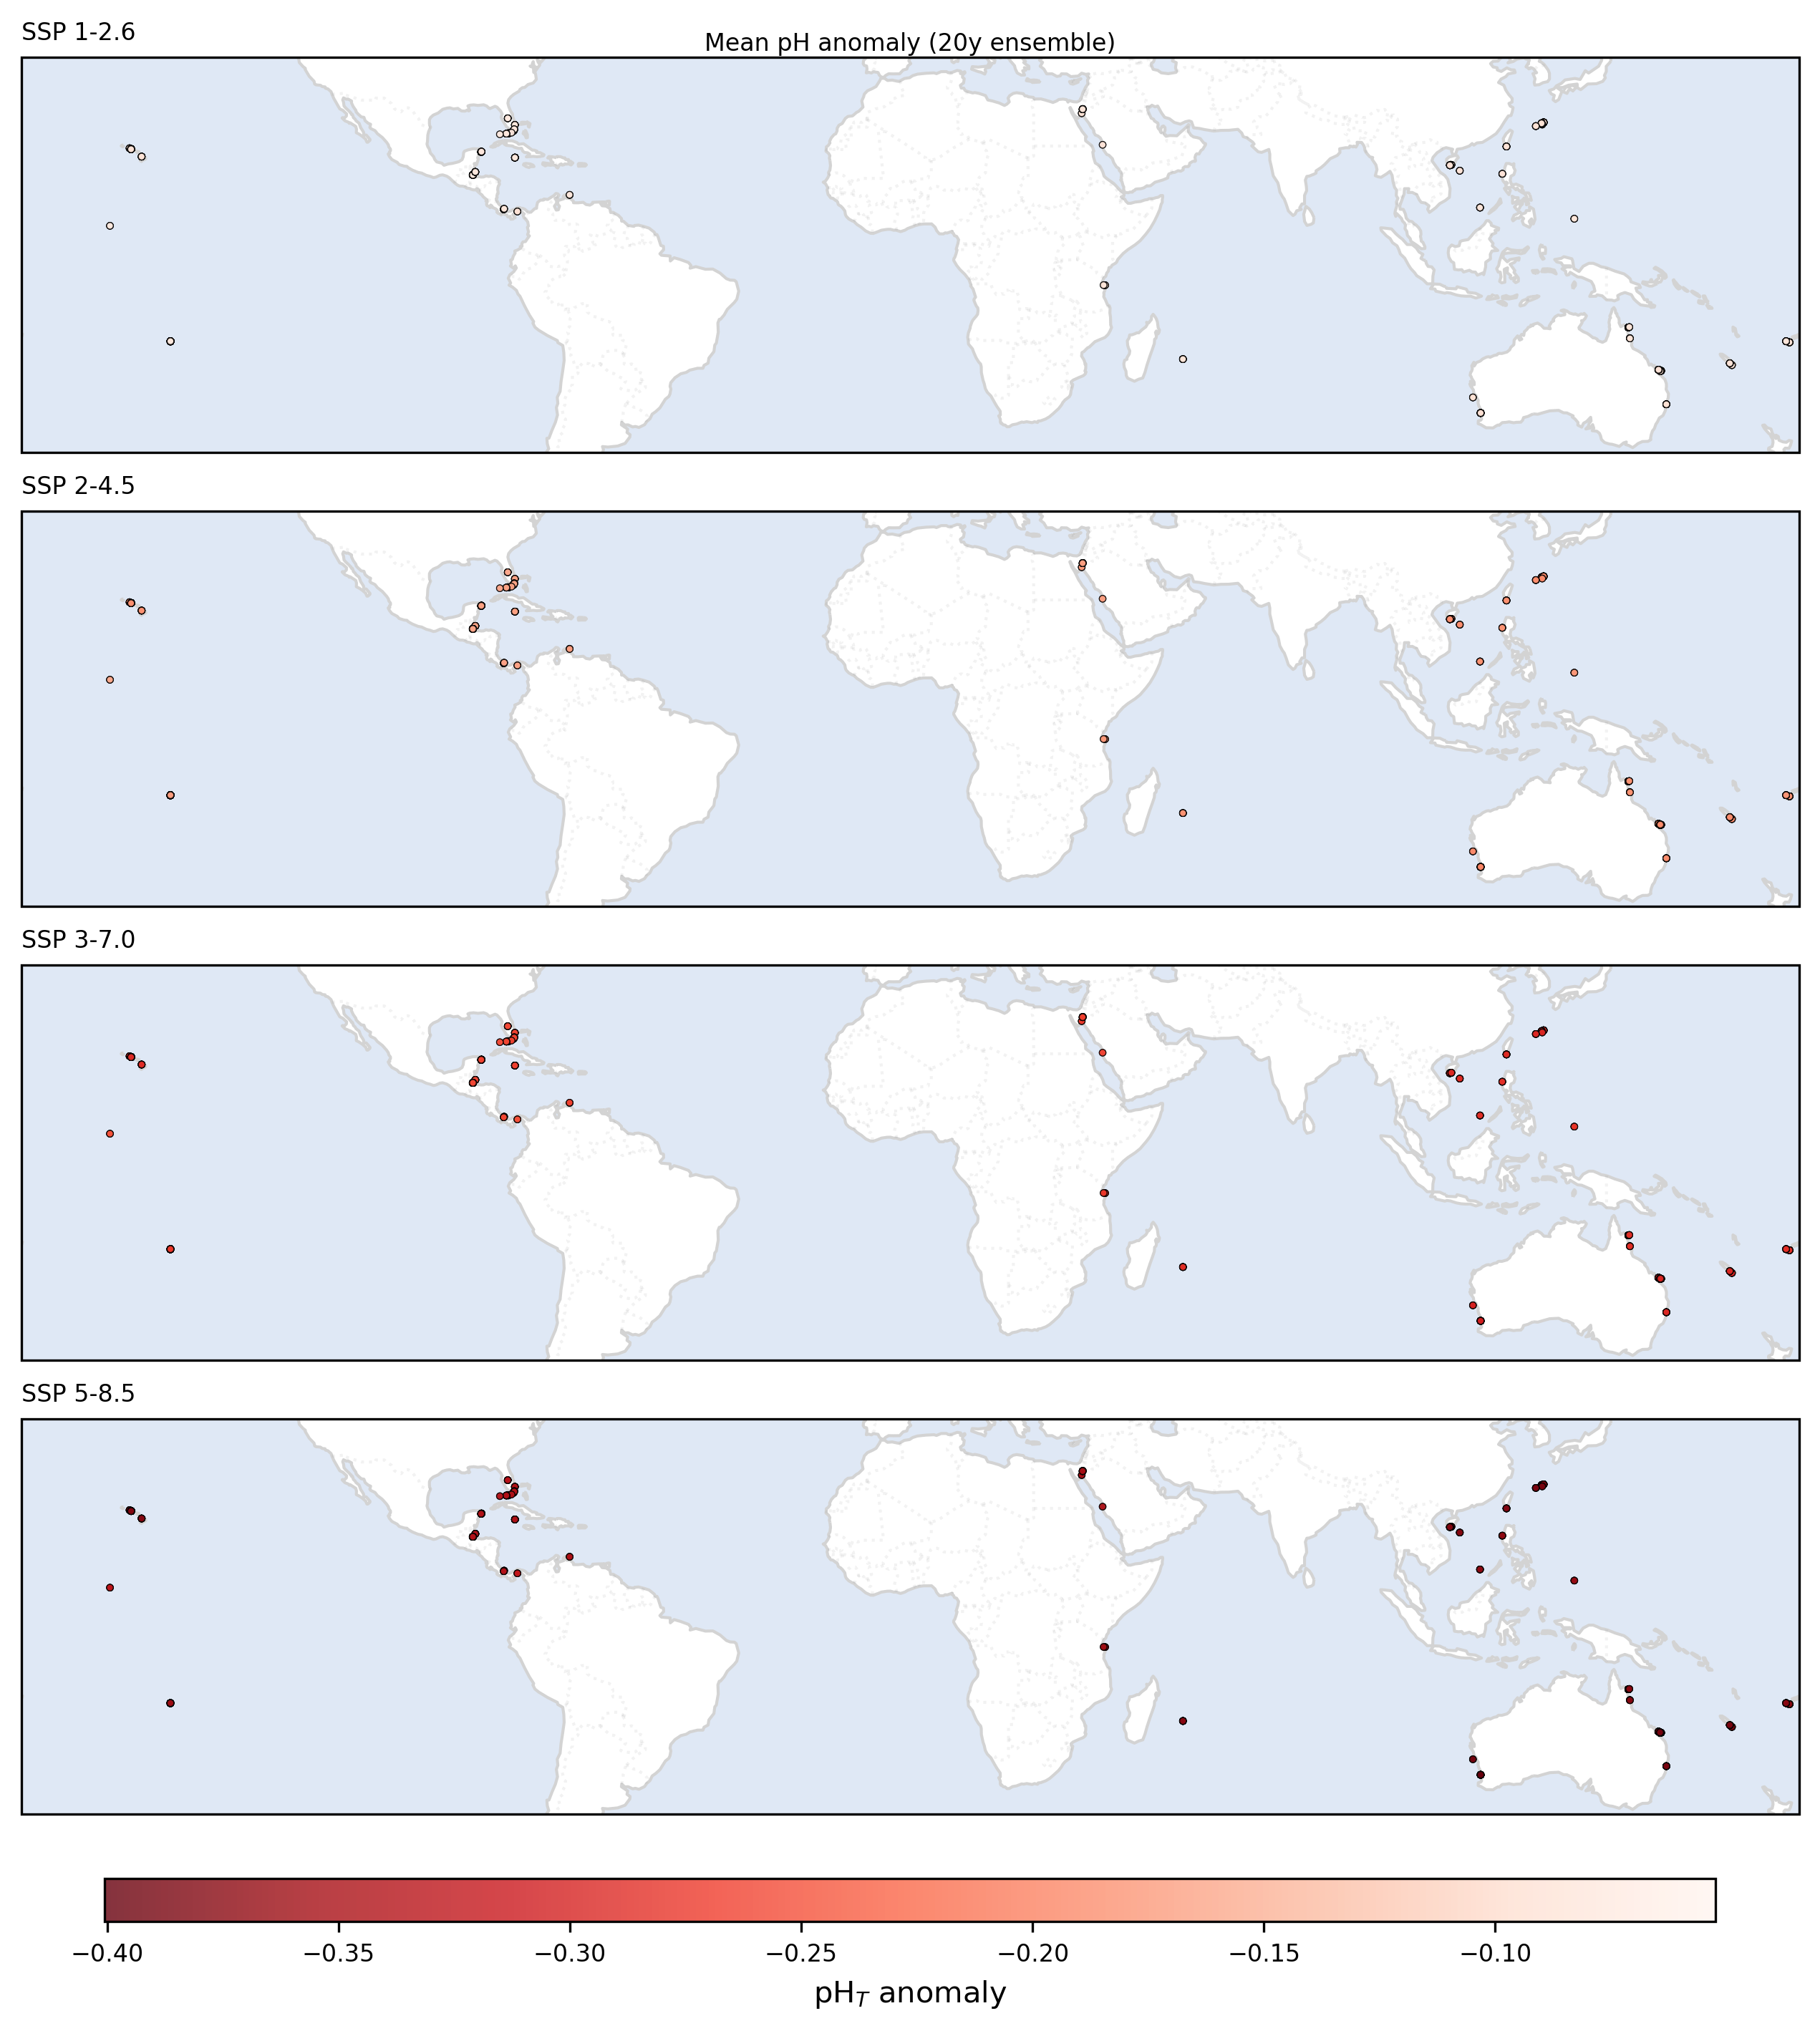

In [18]:
### visualise forecasted mean pH anomalies, by SSP
fig, axes = climatology.plot_spatial_effect_distribution(
    working_clim_df.reset_index(),
    var_to_plot="mean_ph_20y_anomaly_ensemble",
    title="Mean pH anomaly (20y ensemble)",
    cbar_label="pH$_T$ anomaly",
    reverse_cmap=True,
)

## Variable-calcification visualisations

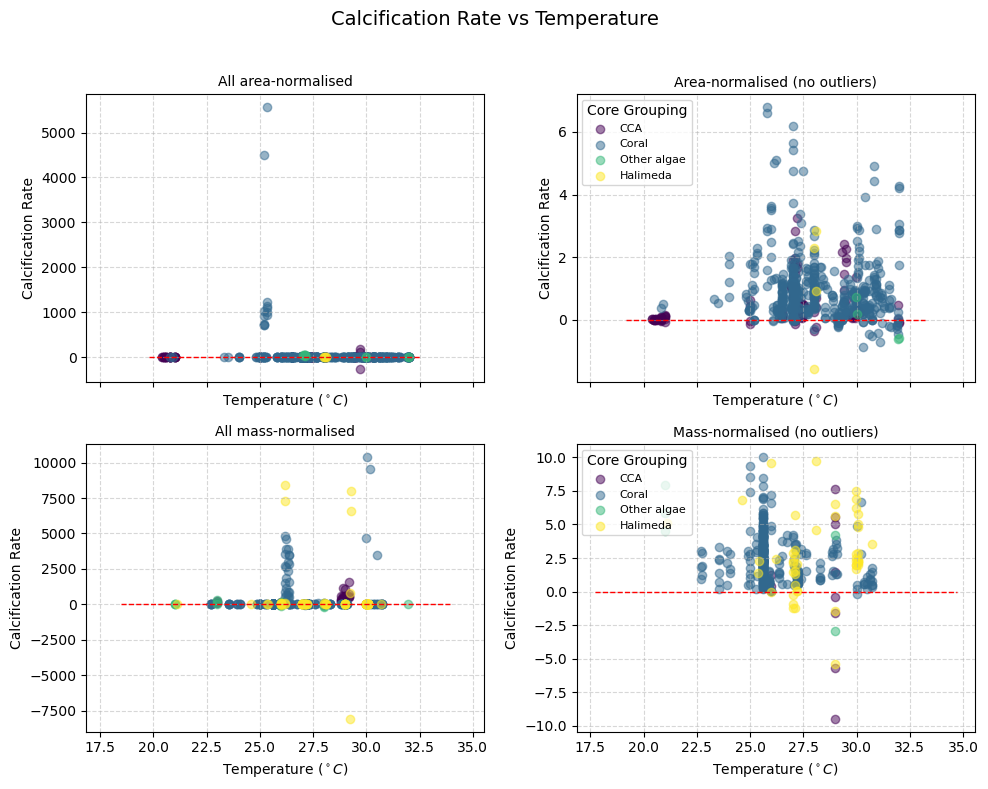

In [19]:
### naive plotting of calcification rates against absolute values of temperature
### for two main unit subsets (mgCaCO3 cm-2d-1 and mgCaCO3 g-1d-1)
area_norm_df = working_df[
    working_df["st_calcification_unit"] == "mgCaCO3 cm-2d-1"
].copy()
mass_norm_df = working_df[
    working_df["st_calcification_unit"] == "mgCaCO3 g-1d-1"
].copy()

# TODO: these currently assigned by sight due to large inherent variance
area_norm_no_outliers_df = area_norm_df[
    (area_norm_df.st_calcification > -10) & (area_norm_df.st_calcification < 10)
]
mass_norm_no_outliers_df = mass_norm_df[
    (mass_norm_df.st_calcification > -10) & (mass_norm_df.st_calcification < 10)
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df["core_grouping"].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df["core_grouping"].nunique())),
    )
}

plots = [
    (0, 0, area_norm_df, "All area-normalised"),
    (0, 1, area_norm_no_outliers_df, "Area-normalised (no outliers)"),
    (1, 0, mass_norm_df, "All mass-normalised"),
    (1, 1, mass_norm_no_outliers_df, "Mass-normalised (no outliers)"),
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df["core_grouping"] == group]
        ax.scatter(
            subset["temp"],
            subset["st_calcification"],
            color=color,
            label=group,
            alpha=0.5,
        )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Temperature ($^\\circ C$)")
    ax.set_ylabel("Calcification Rate")
    ax.grid(ls="--", alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color="red", linestyle="--", linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc="upper left", fontsize=8)

fig.suptitle("Calcification Rate vs Temperature", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])

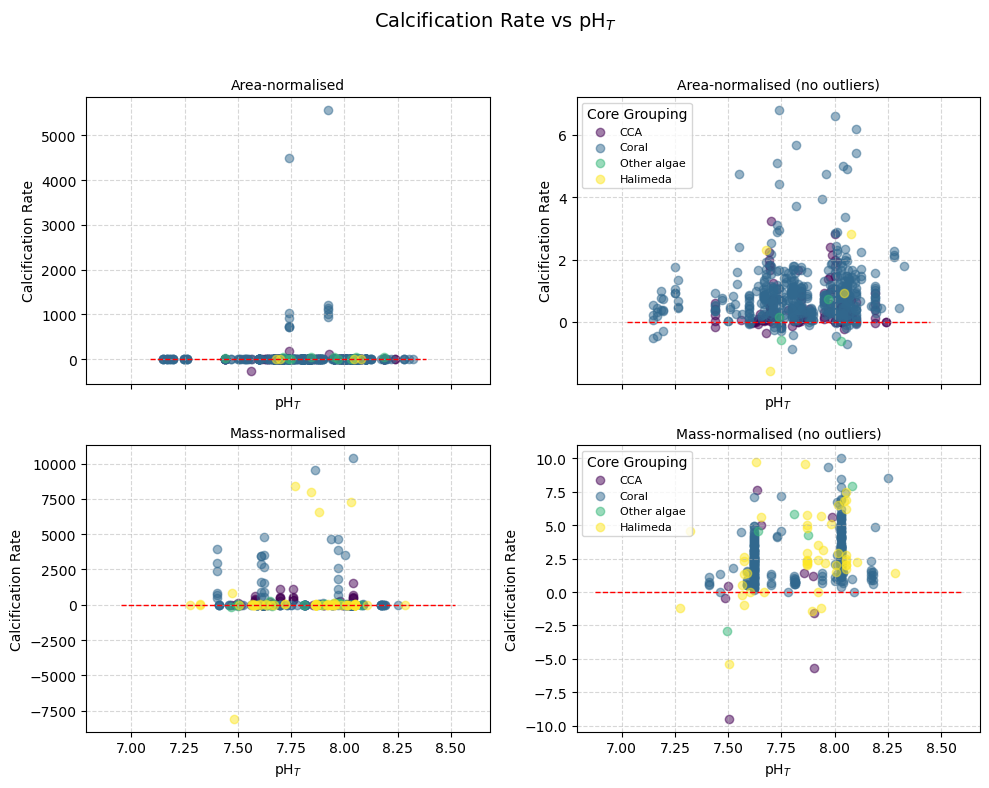

In [20]:
### naive plotting of calcification rates against absolute values of pH
### for two main unit subsets (mgCaCO3 cm-2d-1 and mgCaCO3 g-1d-1)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df["core_grouping"].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df["core_grouping"].nunique())),
    )
}

plots = [
    (0, 0, area_norm_df, "Area-normalised"),
    (0, 1, area_norm_no_outliers_df, "Area-normalised (no outliers)"),
    (1, 0, mass_norm_df, "Mass-normalised"),
    (1, 1, mass_norm_no_outliers_df, "Mass-normalised (no outliers)"),
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df["core_grouping"] == group]
        ax.scatter(
            subset["phtot"],
            subset["st_calcification"],
            color=color,
            label=group,
            alpha=0.5,
        )
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("pH$_T$")
    ax.set_ylabel("Calcification Rate")
    ax.grid(ls="--", alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color="red", linestyle="--", linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc="upper left", fontsize=8)

fig.suptitle("Calcification Rate vs pH$_T$", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [21]:
### area-normalised rate against temperature nad pH, in 3D
area_norm_no_outliers_df.loc[:, "points_weights"] = np.sqrt(
    area_norm_no_outliers_df["st_calcification_sd"]
).copy()

px.scatter_3d(
    area_norm_no_outliers_df,
    x="temp",
    y="phtot",
    z="st_calcification",
    color="core_grouping",
    title="3D Scatter plot of Standardized Calcification vs Temperature and pH",
    labels={
        "temp": "Temperature",
        "phtot": "pH",
        "st_calcification": "Standardized Calcification",
    },
    hover_name="species_types",
    opacity=0.5,
    size="points_weights",
    width=800,
    height=800,
)


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_24539/4004575748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_norm_no_outliers_df.loc[:, "points_weights"] = np.sqrt(


In [22]:
### mass-normalised rate against temperature nad pH, in 3D
mass_norm_no_outliers_df.loc[:, "points_weights"] = np.sqrt(
    mass_norm_no_outliers_df["st_calcification_sd"]
).copy()

px.scatter_3d(
    mass_norm_no_outliers_df,
    x="temp",
    y="phtot",
    z="st_calcification",
    color="core_grouping",
    title="3D Scatter plot of Standardized Calcification vs Temperature and pH",
    labels={
        "temp": "Temperature",
        "phtot": "pH",
        "st_calcification": "Standardized Calcification",
    },
    hover_name="species_types",
    opacity=0.5,
    size="points_weights",
    width=800,
    height=800,
)


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_24539/3421424699.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



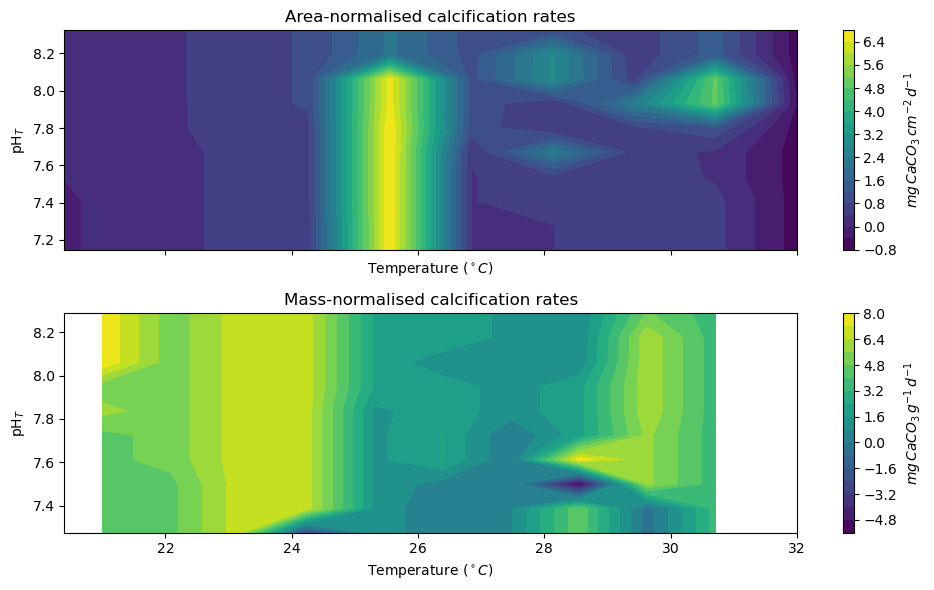

In [23]:
### contour plot of calcification rates against temperature and pH
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
npoints = 10

area_x = np.linspace(
    area_norm_no_outliers_df.temp.min(), area_norm_no_outliers_df.temp.max(), npoints
)  # Temperature range
area_y = np.linspace(
    area_norm_no_outliers_df.phtot.min(), area_norm_no_outliers_df.phtot.max(), npoints
)  # pH range
mass_x = np.linspace(
    mass_norm_no_outliers_df.temp.min(), mass_norm_no_outliers_df.temp.max(), npoints
)  # Temperature range
mass_y = np.linspace(
    mass_norm_no_outliers_df.phtot.min(), mass_norm_no_outliers_df.phtot.max(), npoints
)  # pH range
analysis_plot.plot_contour(
    ax[0],
    area_x,
    area_y,
    area_norm_no_outliers_df,
    "Area-normalised calcification rates",
    legend_label=r"$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$",
)
analysis_plot.plot_contour(
    ax[1],
    mass_x,
    mass_y,
    mass_norm_no_outliers_df,
    "Mass-normalised calcification rates",
    legend_label=r"$mg \, CaCO_3 \, g^{-1} \, d^{-1}$",
)

plt.tight_layout()

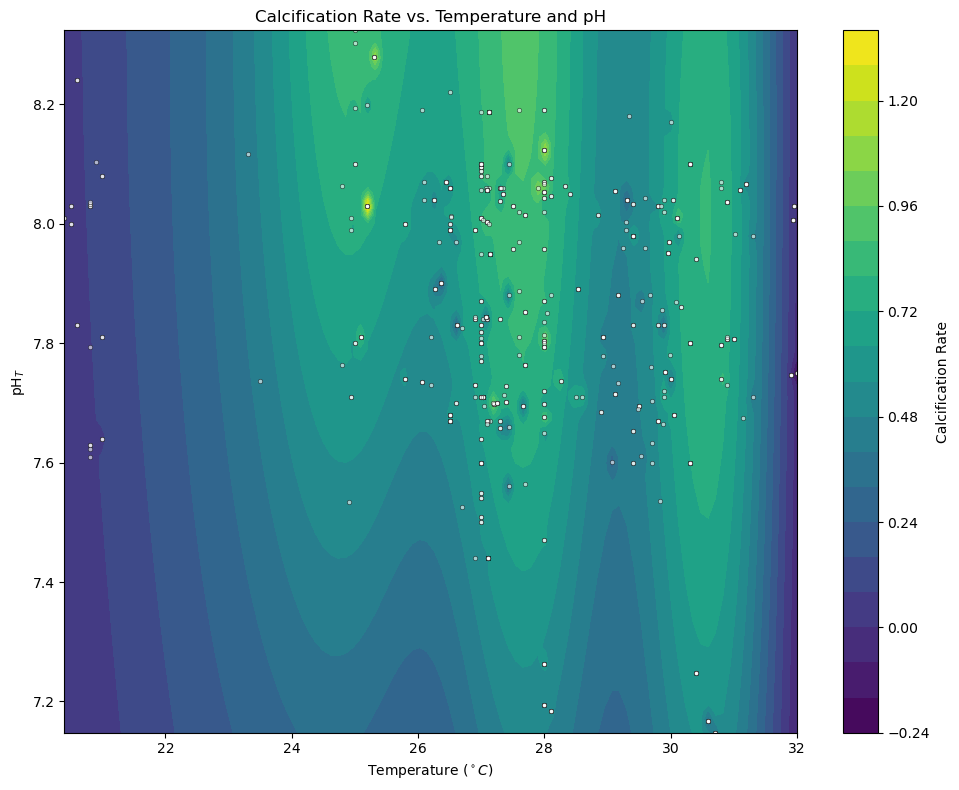

In [24]:
### fit a gaussian process regression model to the data
fig, ax = plt.subplots(figsize=(10, 8))
# filter nans
df = area_norm_no_outliers_df.dropna(subset=["temp", "phtot", "st_calcification"])
x = np.linspace(min(df["temp"]), max(df["temp"]), 100)
y = np.linspace(min(df["phtot"]), max(df["phtot"]), 100)
analysis_plot.plot_contour_gp(ax, x, y, df, "Calcification Rate vs. Temperature and pH")
plt.tight_layout()

In [26]:
### visualise a 3d gaussian process regression
analysis_plot.plot_3d_surface_gp(df)

## Effect sizes

In the assignment of treatment groups, two studies show up as problematic (no control). This is because calcification rates from explicitly-adapted corals (e.g. those near local CO2 seeps) have not been recorded. **Is this fair**? There are in fact a number of studies currently excluded due to this sort of thing. But it'd be interesting to see how these tally all together, perhaps in their own meta-analysis.

In [27]:
### define effect type for the proceeding cells
effect_type = "st_relative_calcification"

In [28]:
### generating effect sizes
effects_df = analysis.calculate_effect_for_df(working_df).reset_index(drop=True)
# errors thrown up re no control data due to questionable studies (excluding explicitly adapted studies)
print(f"Shape of dataframe with effect sizes: {effects_df.shape}")
print(effects_df["treatment"].value_counts())
working_effects_df = effects_df.copy()
effect_sizes = [
    "cohens_d",
    "hedges_g",
    "relative_calcification",
    "absolute_calcification",
    "st_relative_calcification",
    "st_absolute_calcification",
]

  0%|          | 0/150 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/analysis/analysis.py:168: RuntimeWarning:

invalid value encountered in scalar divide



Shape of dataframe with effect sizes: (1238, 118)
treatment
phtot            598
temp             237
phtot_mv         151
temp_mv          145
phtot_temp_mv    107
Name: count, dtype: int64


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/analysis/analysis.py:340: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [29]:
effects_df.iloc[effects_df.delta_ph.idxmin()].doi

'10.1002/lno.11863'

In [30]:
effects_df.delta_ph.min()

-0.9479460826442878

In [31]:
### relative calcification as function of temperature and pH, in 3D
working_effects_df[f"{effect_type}_var"] = pd.to_numeric(
    working_effects_df[f"{effect_type}_var"], errors="coerce"
)

working_effects_df.loc[:, "points_weights"] = np.sqrt(
    pd.to_numeric(working_effects_df[f"{effect_type}_var"], errors="coerce")
)
px.scatter_3d(
    working_effects_df,
    x="temp",
    y="phtot",
    z="st_relative_calcification",
    color="core_grouping",
    title="3D Scatter plot of Standardized Calcification vs Temperature and pH",
    labels={
        "temp": "Temperature",
        "phtot": "pH",
        "st_relative_calcification": "Relative standardized Calcification",
    },
    hover_name="species_types",
    opacity=0.5,
    size="points_weights",
    width=800,
    height=800,
)


In [32]:
### relative calcification as function of DELTA(temperature) and DELTA(pH), in 3D

working_effects_df[f"{effect_type}_var"] = pd.to_numeric(
    working_effects_df[f"{effect_type}_var"], errors="coerce"
)

working_effects_df.loc[:, "points_weights"] = np.sqrt(
    pd.to_numeric(working_effects_df["st_relative_calcification_var"], errors="coerce")
)
px.scatter_3d(
    working_effects_df,
    x="delta_t",
    y="delta_ph",
    z="st_relative_calcification",
    color="core_grouping",
    title="3D Scatter plot of Standardized Calcification vs Temperature and pH",
    labels={
        "temp": "Temperature",
        "phtot": "pH",
        "st_relative_calcification": "Relative standardized Calcification",
    },
    hover_name="species_types",
    opacity=0.5,
    size="points_weights",
    width=800,
    height=800,
)

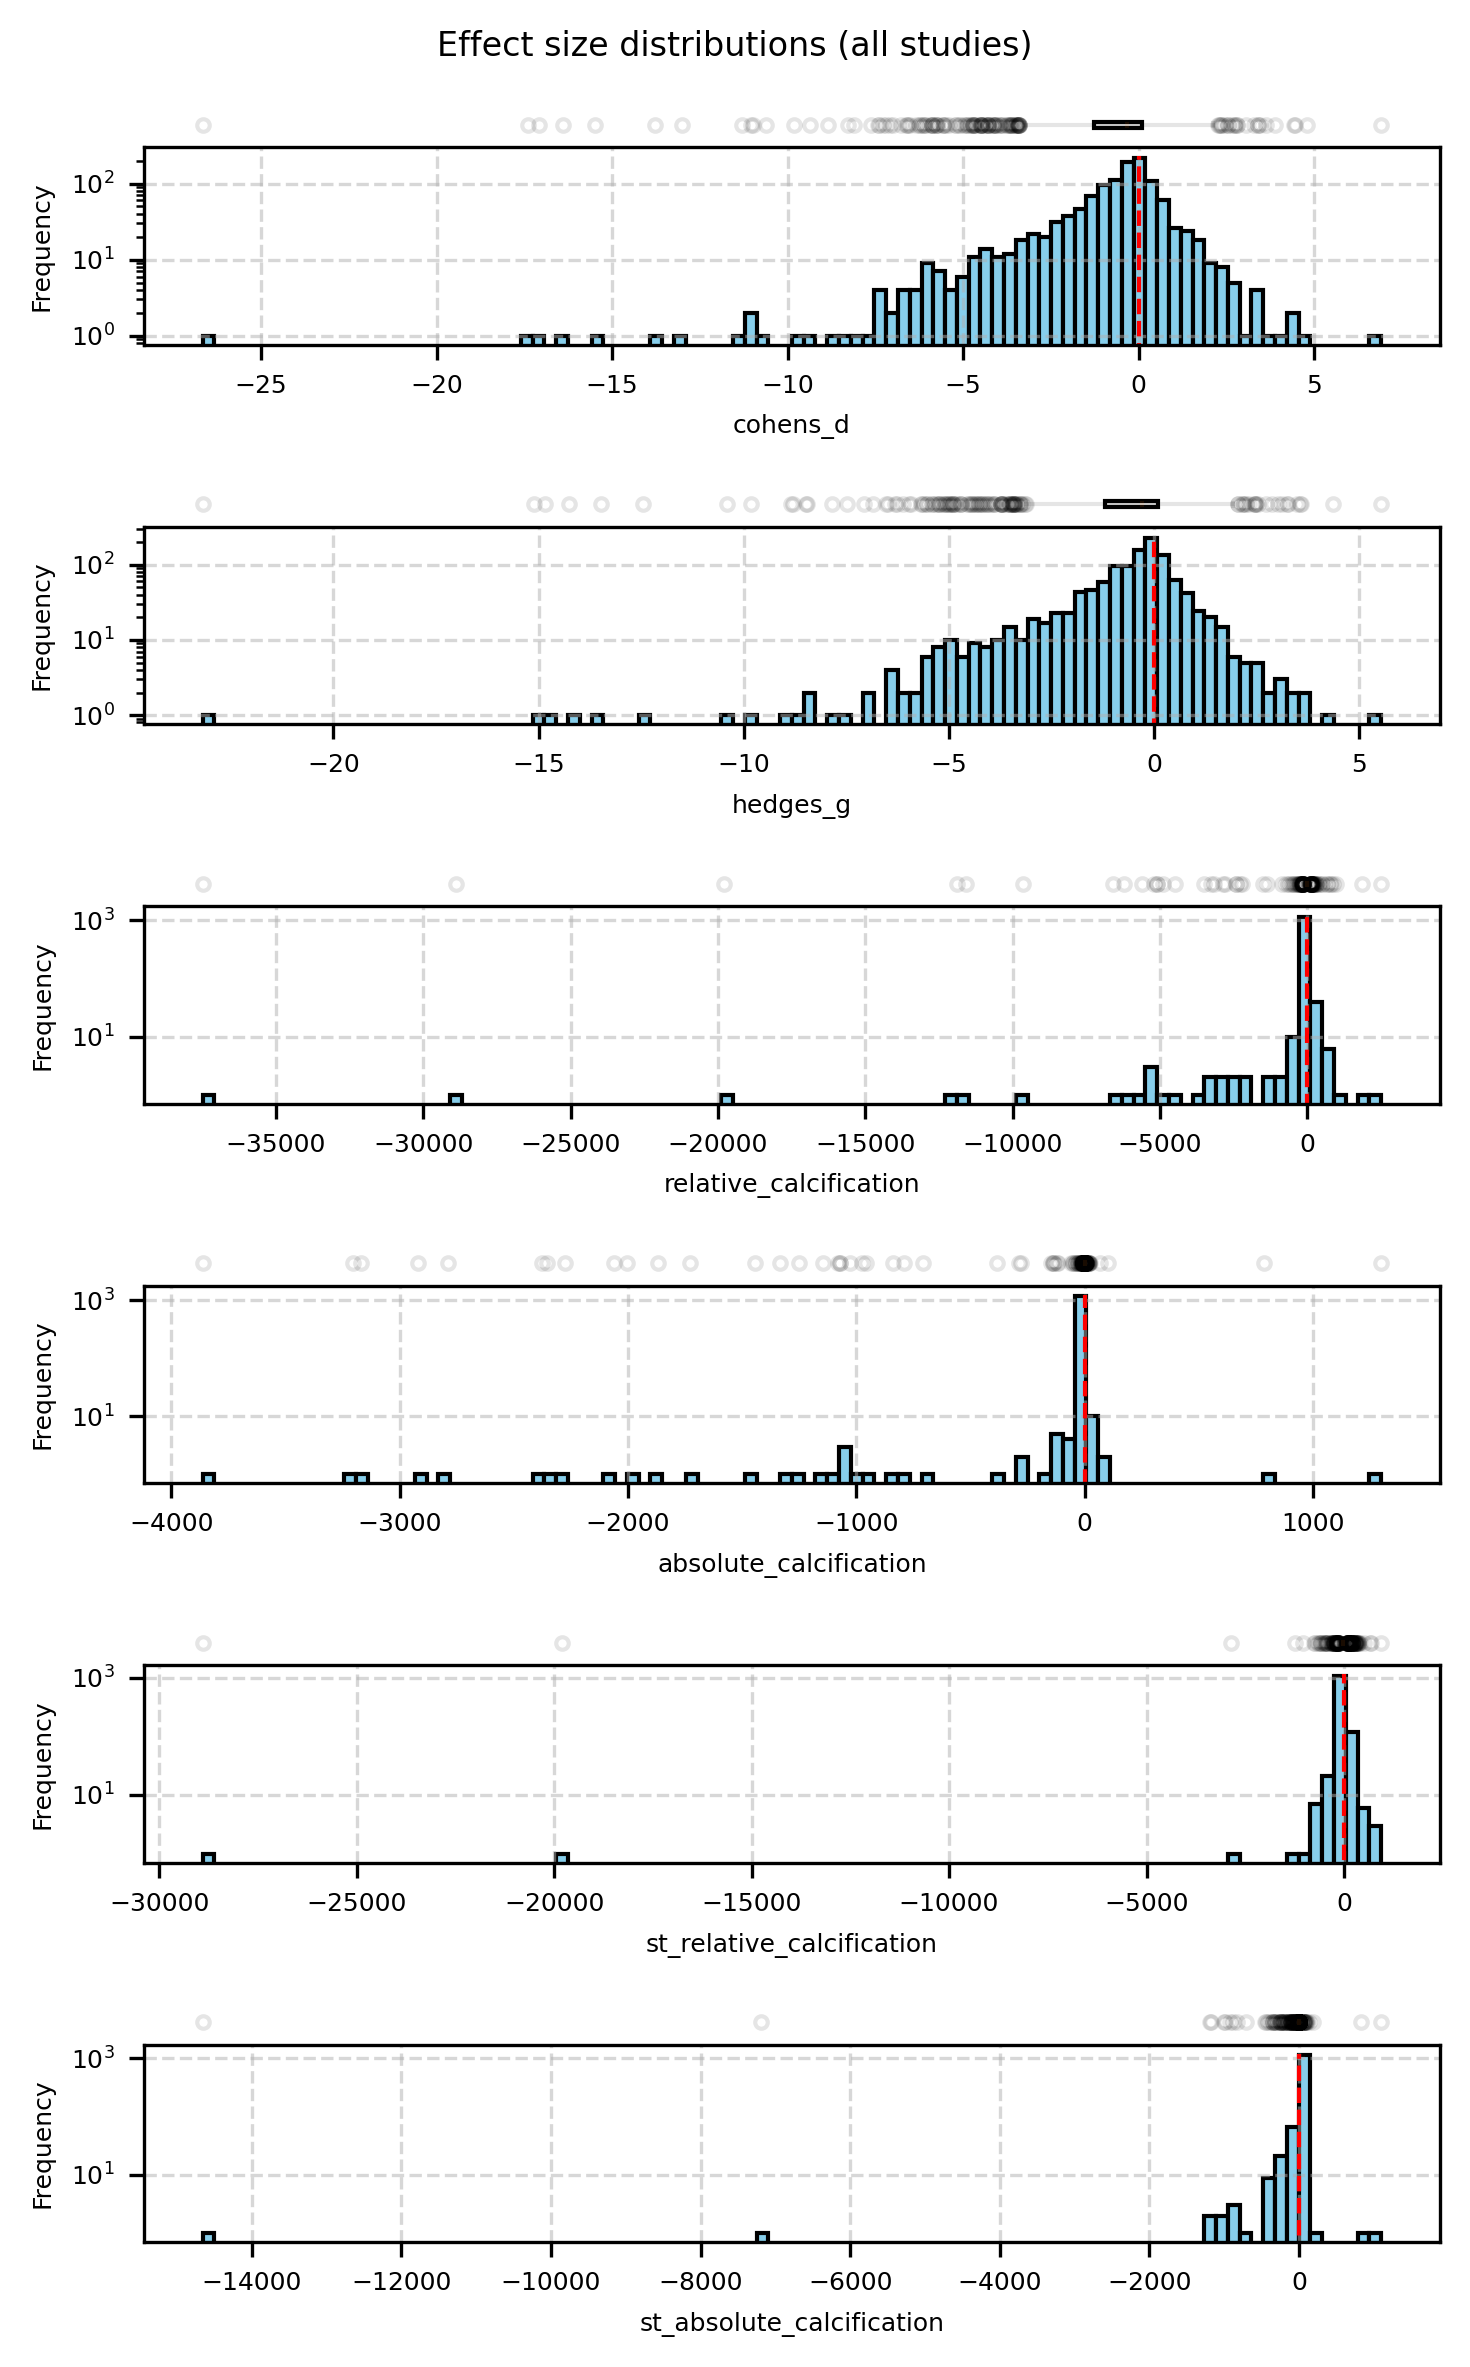

In [33]:
### visualise distributions of effect sizes (all studies)
data_exploration.plot_effect_size_distributions(
    working_effects_df,
    title="Effect size distributions (all studies)",
)

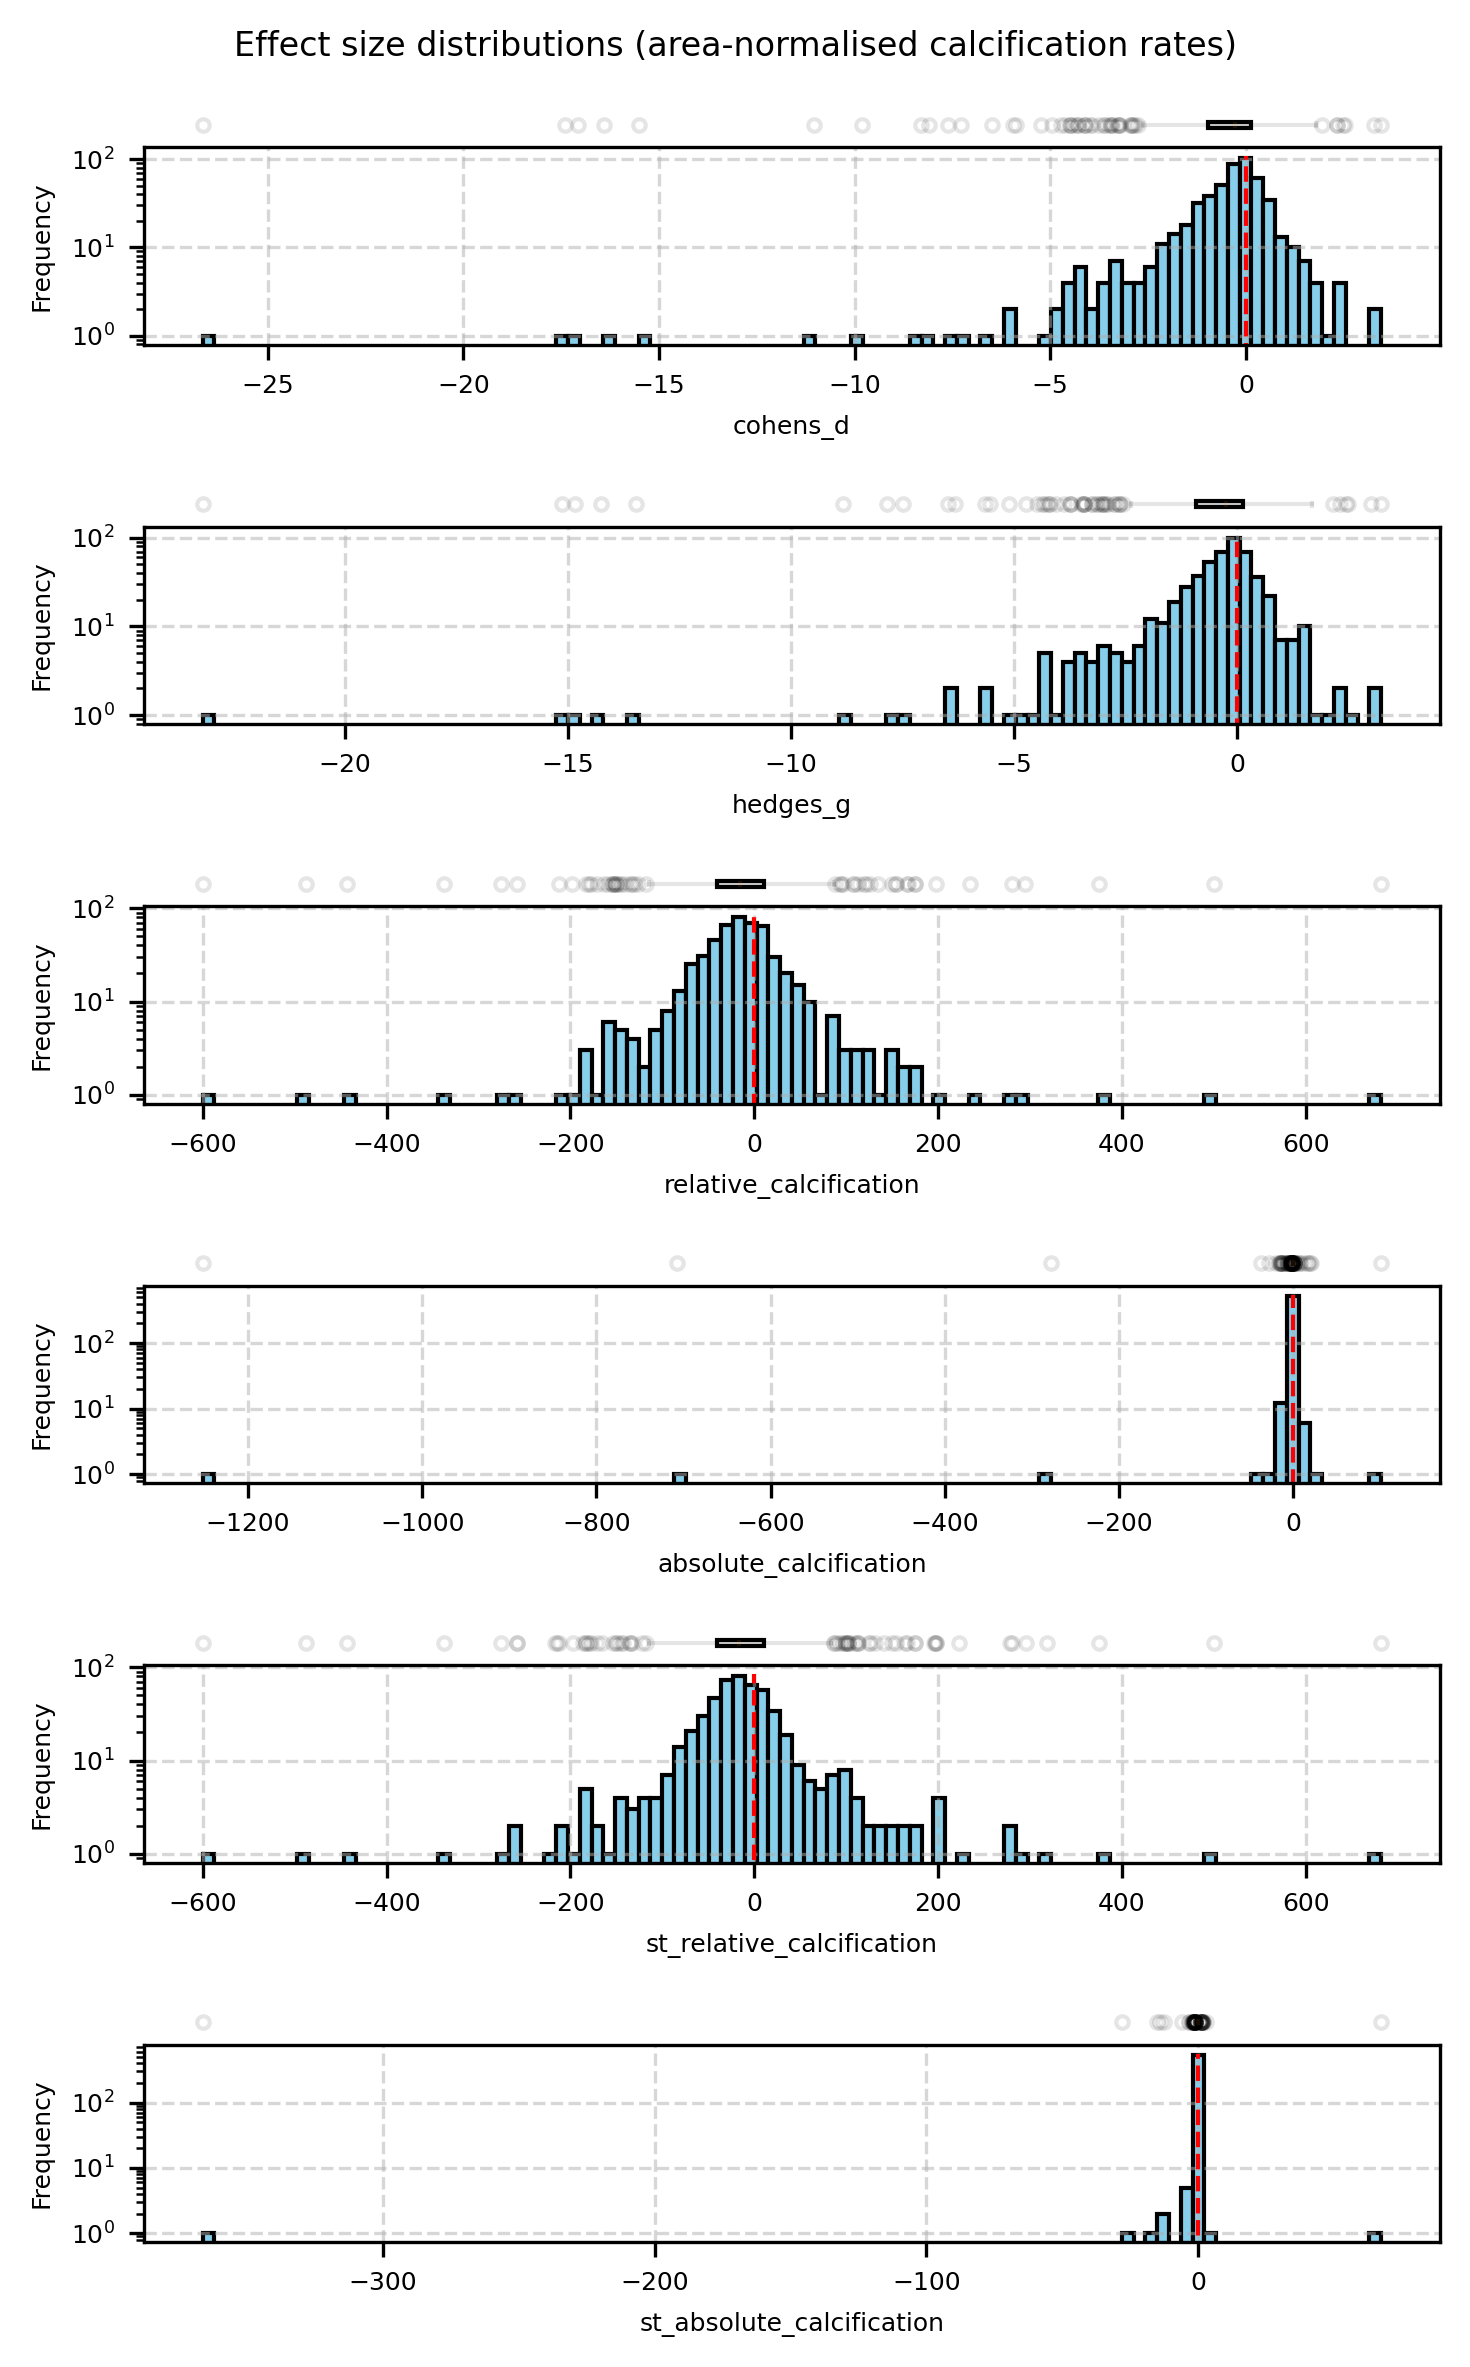

In [34]:
### visualise distributions of effect sizes (area-normalised calcification rates)
data_exploration.plot_effect_size_distributions(
    working_effects_df[
        working_effects_df["st_calcification_unit"] == "mgCaCO3 cm-2d-1"
    ],
    title="Effect size distributions (area-normalised calcification rates)",
)


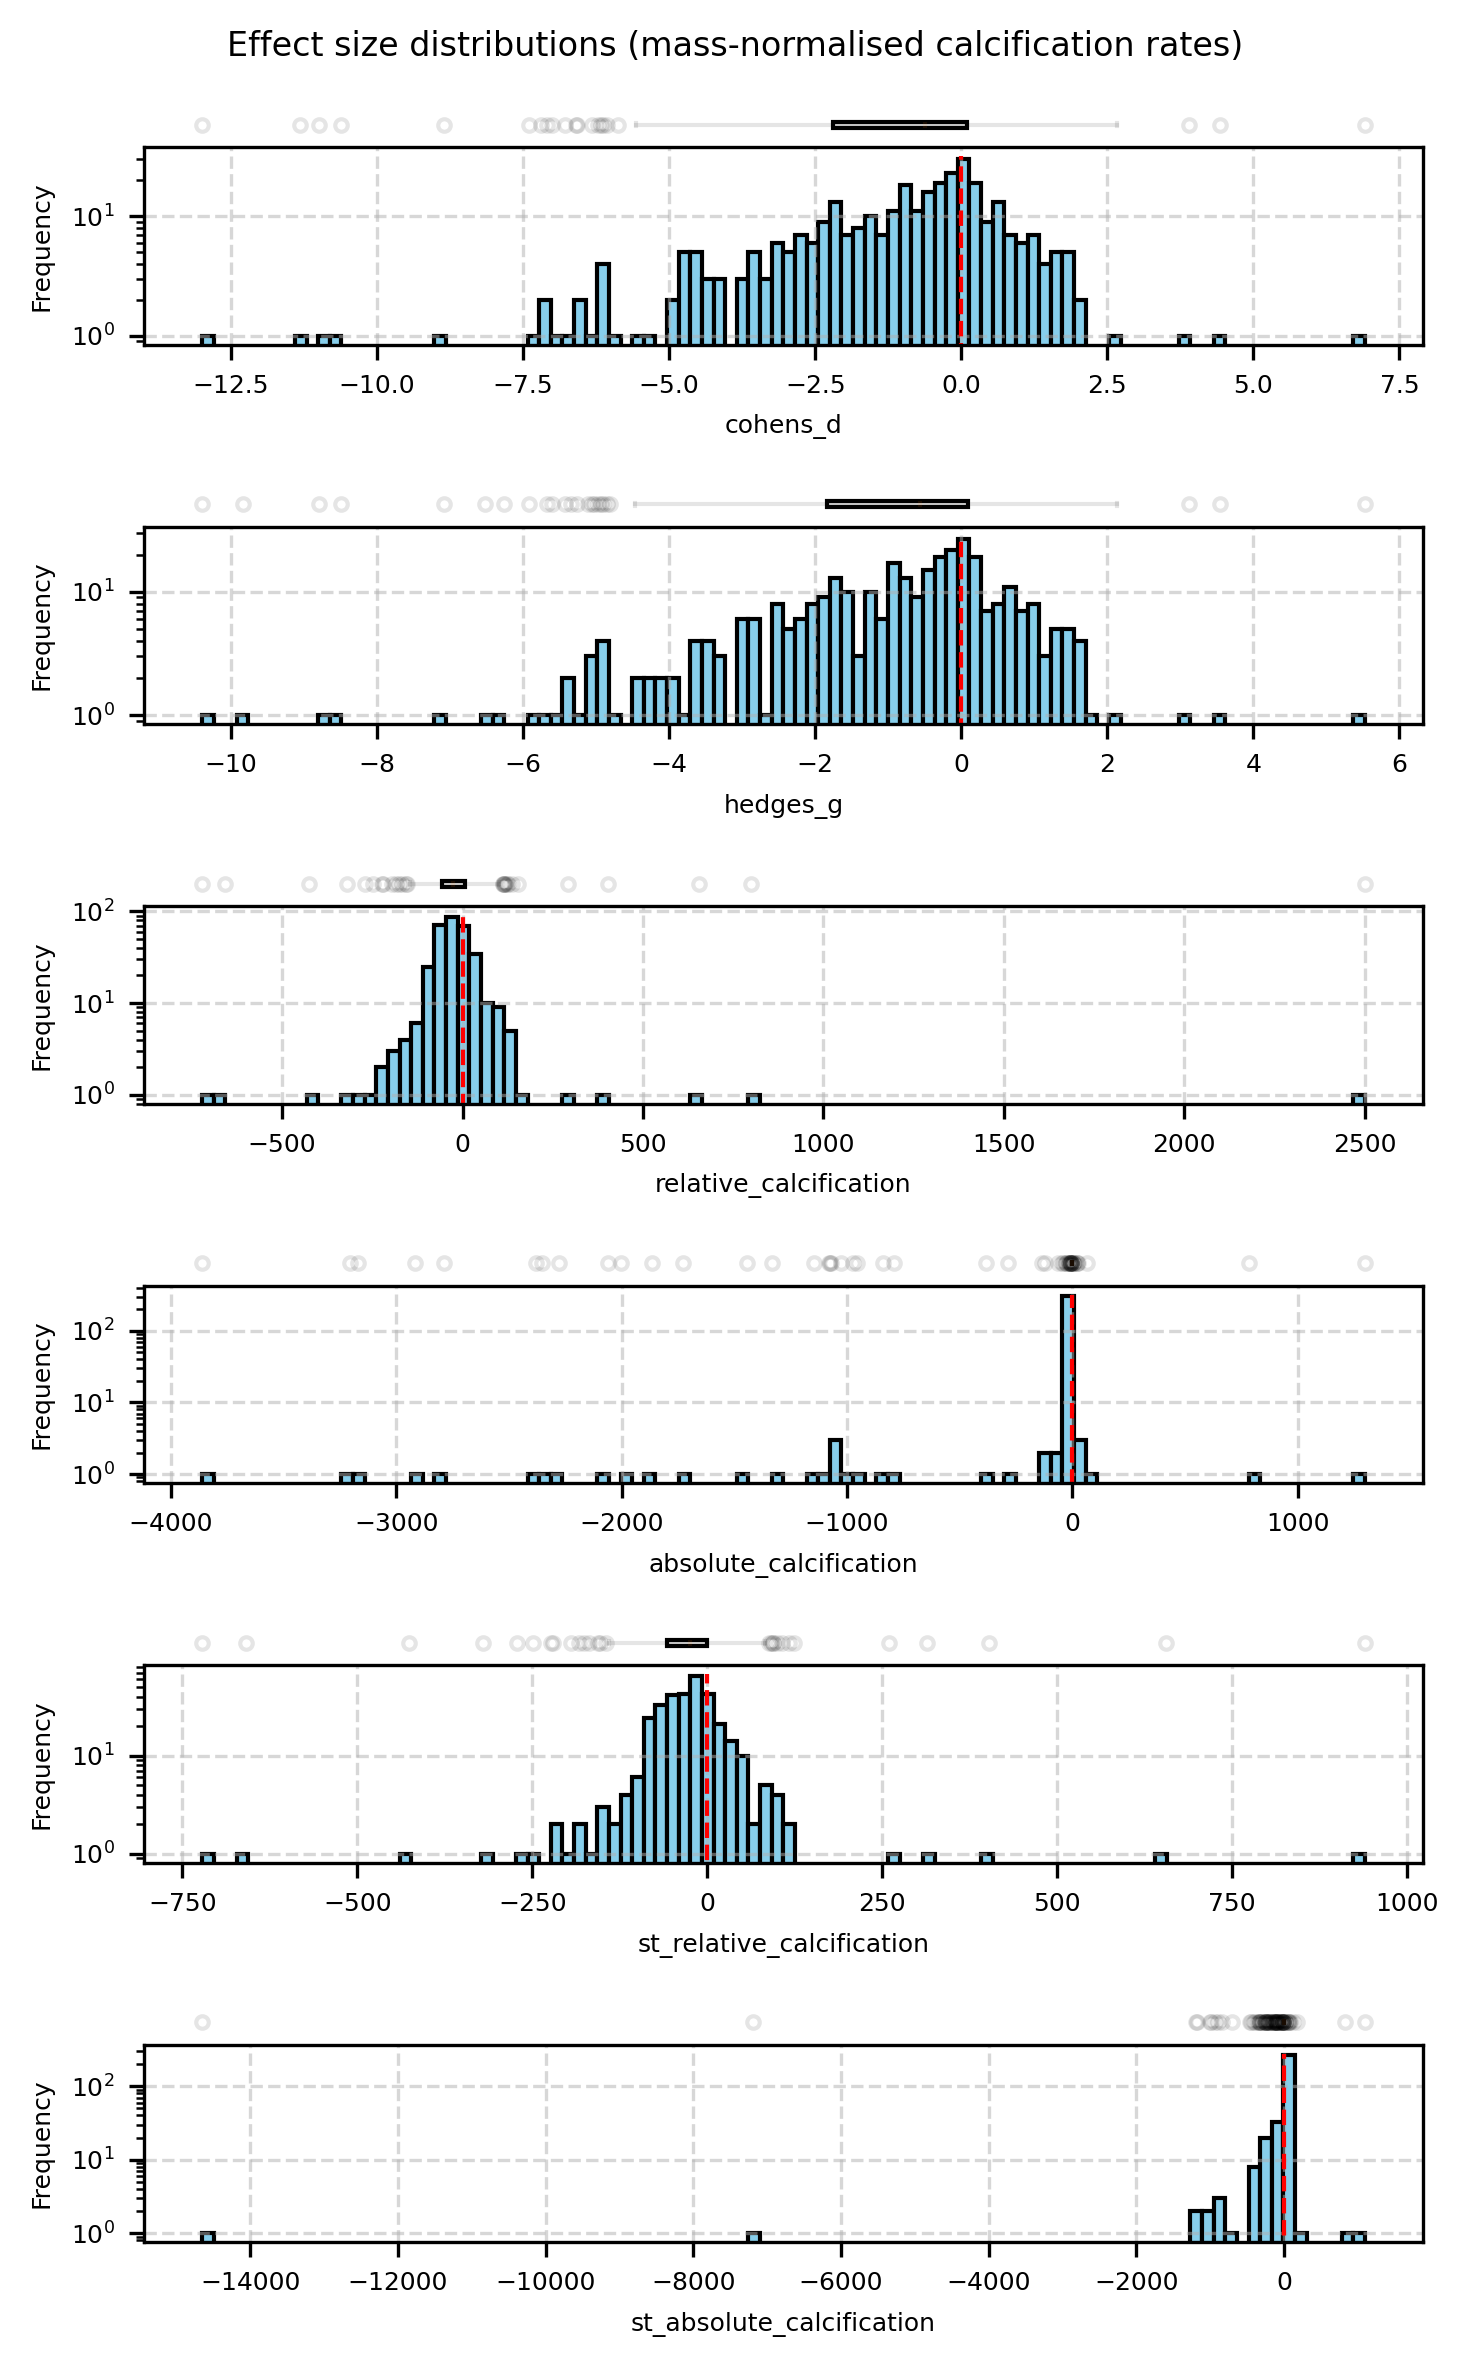

In [35]:
### visualise distributions of effect sizes (mass-normalised calcification rates)
data_exploration.plot_effect_size_distributions(
    working_effects_df[working_effects_df["st_calcification_unit"] == "mgCaCO3 g-1d-1"],
    title="Effect size distributions (mass-normalised calcification rates)",
)

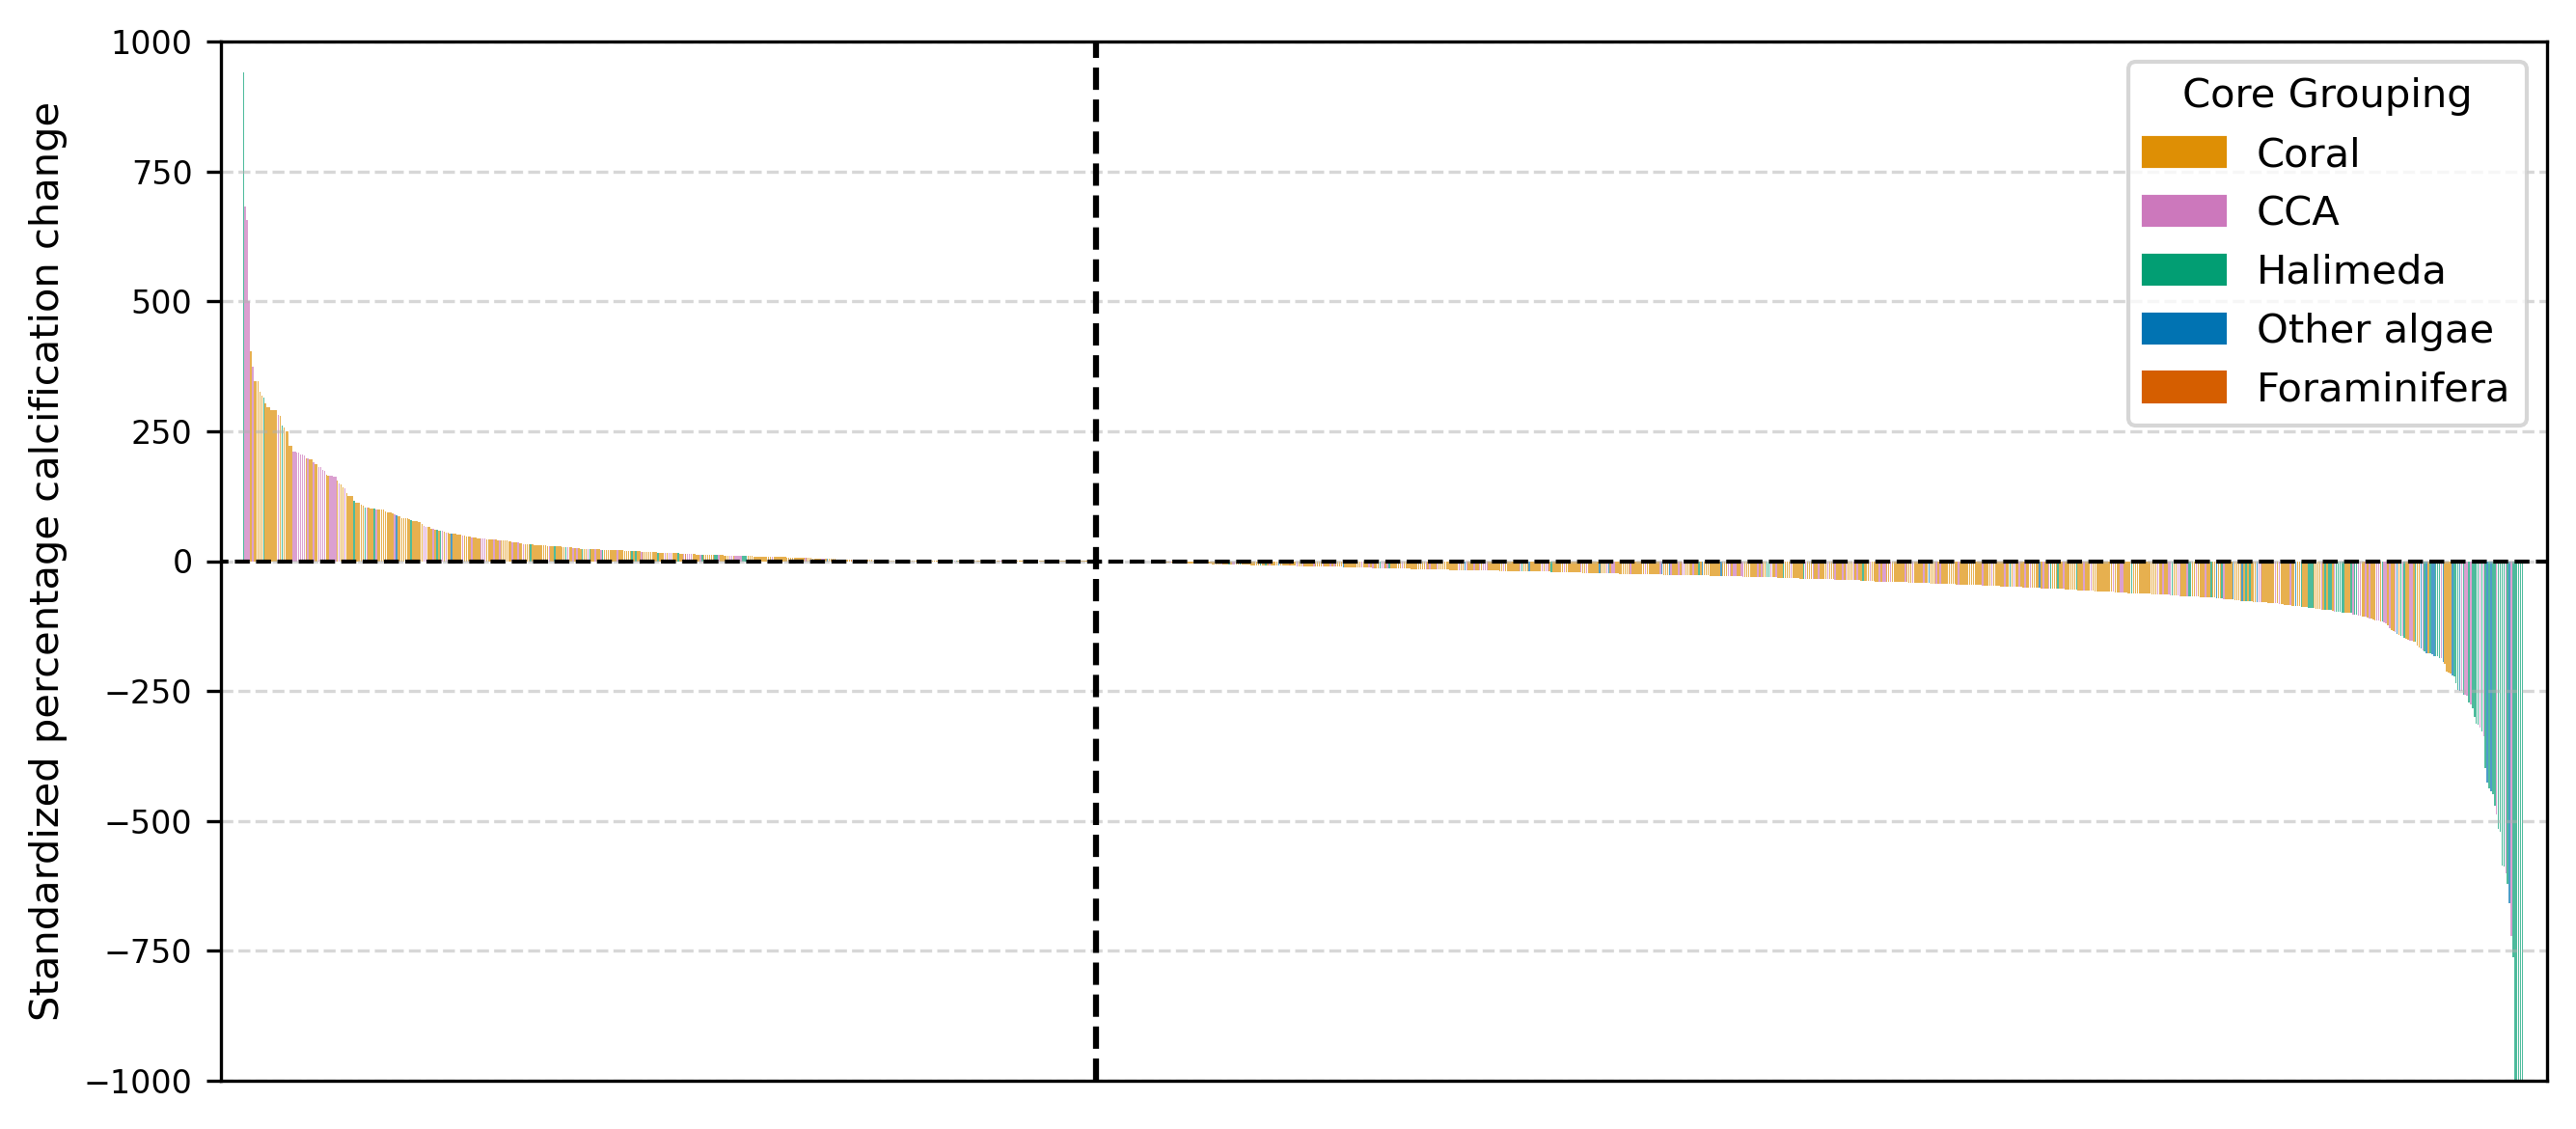

In [36]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

ordered_working_effects_df = (
    working_effects_df.sort_values(by="st_relative_calcification", ascending=False)
    .reset_index(drop=True)
    .copy()
)
# Map core_grouping to colors
unique_groups = ordered_working_effects_df["core_grouping"].unique()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.bar(
    ordered_working_effects_df.index,
    ordered_working_effects_df["st_relative_calcification"],
    # yerr=np.sqrt(ordered_working_effects_df['st_relative_calcification_var']),
    capsize=5,
    color=ordered_working_effects_df["core_grouping"].map(plot_config.CG_COLOURS),
    alpha=0.7,
)
ax.hlines(0, *ax.get_xlim(), color="black", linestyle="--", linewidth=1)
ax.set_ylim(-1000, 1000)
ax.set_xticks([])
# Add labels and title
ax.set_ylabel("Standardized percentage calcification change")
ax.grid(ls="--", alpha=0.5)
ax.set_xlim(
    -len(ordered_working_effects_df.index) * 0.01,
    len(ordered_working_effects_df.index) * 1.01,
)
ax.tick_params(axis="y", labelsize=8)
# Add a legend for core_grouping
handles = [
    Patch(color=color, label=group) for group, color in plot_config.CG_COLOURS.items()
]
ax.legend(handles=handles, title="Core Grouping", loc="upper right")
first_zero_idx = ordered_working_effects_df[
    ordered_working_effects_df["st_relative_calcification"] <= 0
].index[0]
ax.vlines(
    first_zero_idx,
    *ax.get_ylim(),
    color="black",
    linestyle="--",
)

plt.tight_layout()
plt.show()

The 95th percentile is: -635.09


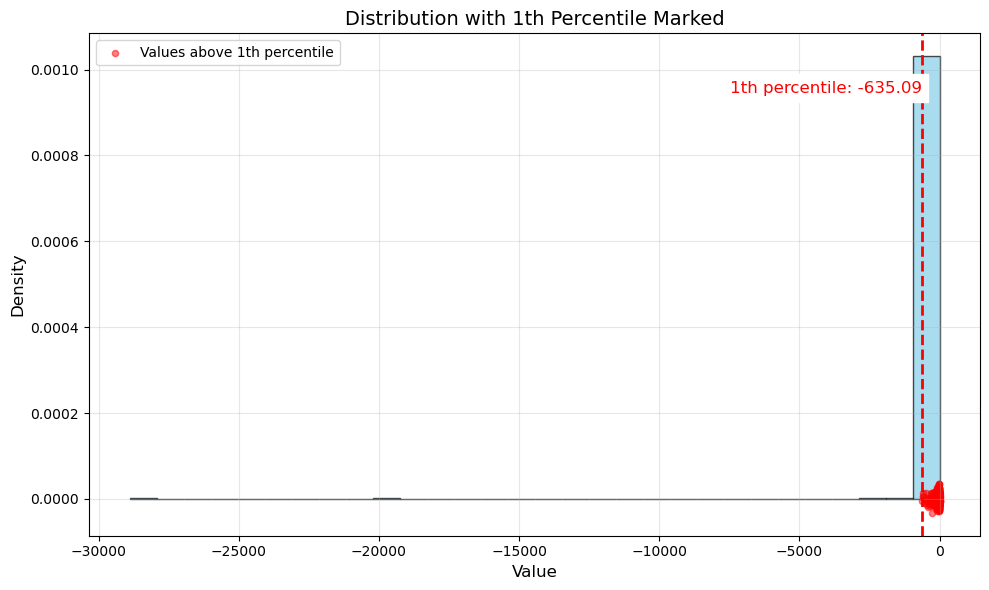

In [37]:
### plot a cumulative distribution of effect sizes. TODO: fix this
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


def plot_and_find_percentile(data, percentile=95, figsize=(10, 6), bins=30):
    """
    Plots a histogram of the data with the specified percentile marked,
    and returns the percentile value.

    Args:
        data (array-like): The data values to analyze
        percentile (float): Percentile to calculate (default: 95)
        figsize (tuple): Figure size as (width, height)
        bins (int): Number of histogram bins

    Returns:
        float: The value at the specified percentile
    """
    # Calculate the percentile
    percentile_value = np.percentile(data, percentile)

    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram
    counts, bins, patches = ax.hist(
        data, bins=bins, alpha=0.7, color="skyblue", edgecolor="black", density=True
    )

    # Add a vertical line at the percentile
    ax.axvline(x=percentile_value, color="red", linestyle="--", linewidth=2)

    # Add text annotation for the percentile value
    ax.text(
        percentile_value,
        0.9 * ax.get_ylim()[1],
        f"{percentile}th percentile: {percentile_value:.2f}",
        color="red",
        ha="right",
        va="top",
        backgroundcolor="white",
        fontsize=12,
    )

    # Add kernel density estimate
    # x = np.linspace(min(data), max(data), 1000)
    # kde = stats.gaussian_kde(data)
    # ax.plot(x, kde(x), 'k-', linewidth=2, label='Density Estimate')

    # Mark data above the percentile
    above_percentile = data[data >= percentile_value]
    if len(above_percentile) > 0:
        jitter = np.random.normal(
            0, 0.01 * ax.get_ylim()[1], size=len(above_percentile)
        )
        ax.scatter(
            above_percentile,
            jitter,
            color="red",
            alpha=0.5,
            s=20,
            label=f"Values above {percentile}th percentile",
        )

    # Add labels and title
    ax.set_xlabel("Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(f"Distribution with {percentile}th Percentile Marked", fontsize=14)

    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()

    return fig, percentile_value


# Plot the data and find the 95th percentile
fig, percentile_95 = plot_and_find_percentile(
    working_effects_df[working_effects_df["st_relative_calcification"] < 0][
        "st_relative_calcification"
    ],
    percentile=1,
    figsize=(10, 6),
    bins=30,
)
print(f"The 95th percentile is: {percentile_95:.2f}")

In [38]:
working_effects_df[working_effects_df["st_relative_calcification"] < 0]

index                      authors calcification calcification_sd  \
0         0                 Tanvet et al      1.506536         0.871085   
1         1                 Tanvet et al      0.843137         1.219519   
2         1                 Tanvet et al      3.932331         1.488798   
3         0                 Tanvet et al      3.526316         1.660582   
5         2                 Tanvet et al      1.598039         1.219519   
...     ...                          ...           ...              ...   
1230      0  Muehllehner & Edmunds 2008a           6.0           1.9093   
1232      0  Muehllehner & Edmunds 2008a       0.90566         0.477325   
1233      0  Muehllehner & Edmunds 2008a      0.981132           1.9093   
1236   1317  Muehllehner & Edmunds 2008a      6.226415         3.221943   
1237      0  Muehllehner & Edmunds 2008a      2.339623         2.505956   

     calcification_se calcification_unit cleaned_coords         co3 co3_sd  \
0            0.228758  mg CaCO3 g-1 d-1             NaN         NaN    NaN   
1            0.320261  mg CaCO3 g-1 d-1             NaN         NaN    NaN   
2            0.390977  mg CaCO3 g-1 d-1             NaN         NaN    NaN   
3             0.43609  mg CaCO3 g-1 d-1             NaN         NaN    NaN   
5            0.320261  mg CaCO3 g-1 d-1             NaN         NaN    NaN   
...               ...                ...            ...         ...    ...   
1230         0.603774       ug mm-2day-1            NaN  247.913794    NaN   
1232         0.150943       ug mm-2day-1            NaN   76.851976    NaN   
1233         0.603774       ug mm-2day-1            NaN  247.913794    NaN   
1236         1.018868       ug mm-2day-1            NaN   81.321245    NaN   
1237         0.792453       ug mm-2day-1            NaN   76.851976    NaN   

     co3_se  ... treatment_calcification treatment_calcification_sd  \
0       NaN  ...                1.506536                   0.871085   
1       NaN  ...                0.843137                   1.219519   
2       NaN  ...                3.932331                   1.488798   
3       NaN  ...                3.526316                   1.660582   
5       NaN  ...                1.598039                   1.219519   
...     ...  ...                     ...                        ...   
1230    NaN  ...                     6.0                     1.9093   
1232    NaN  ...                 0.90566                   0.477325   
1233    NaN  ...                0.981132                     1.9093   
1236    NaN  ...                6.226415                   3.221943   
1237    NaN  ...                2.339623                   2.505956   

     st_control_calcification st_control_calcification_sd  \
0                 1849.673203                  958.193675   
1                 1849.673203                  958.193675   
2                 4639.097744                  916.183231   
3                 3872.180451                 1317.013394   
5                 1849.673203                  958.193675   
...                       ...                         ...   
1230                 0.781132                    0.238662   
1232                 0.188679                    0.095465   
1233                 0.188679                    0.095465   
1236                 0.781132                    0.238662   
1237                 0.781132                    0.238662   

     st_treatment_calcification st_treatment_calcification_sd treatment_n  \
0                   1506.535948                    871.085159        14.5   
1                    843.137255                   1219.519223        14.5   
2                   3932.330827                    1488.79775        14.5   
3                   3526.315789                   1660.582106        14.5   
5                   1598.039216                   1219.519223        14.5   
...                         ...                           ...         ...   
1230                        0.6            

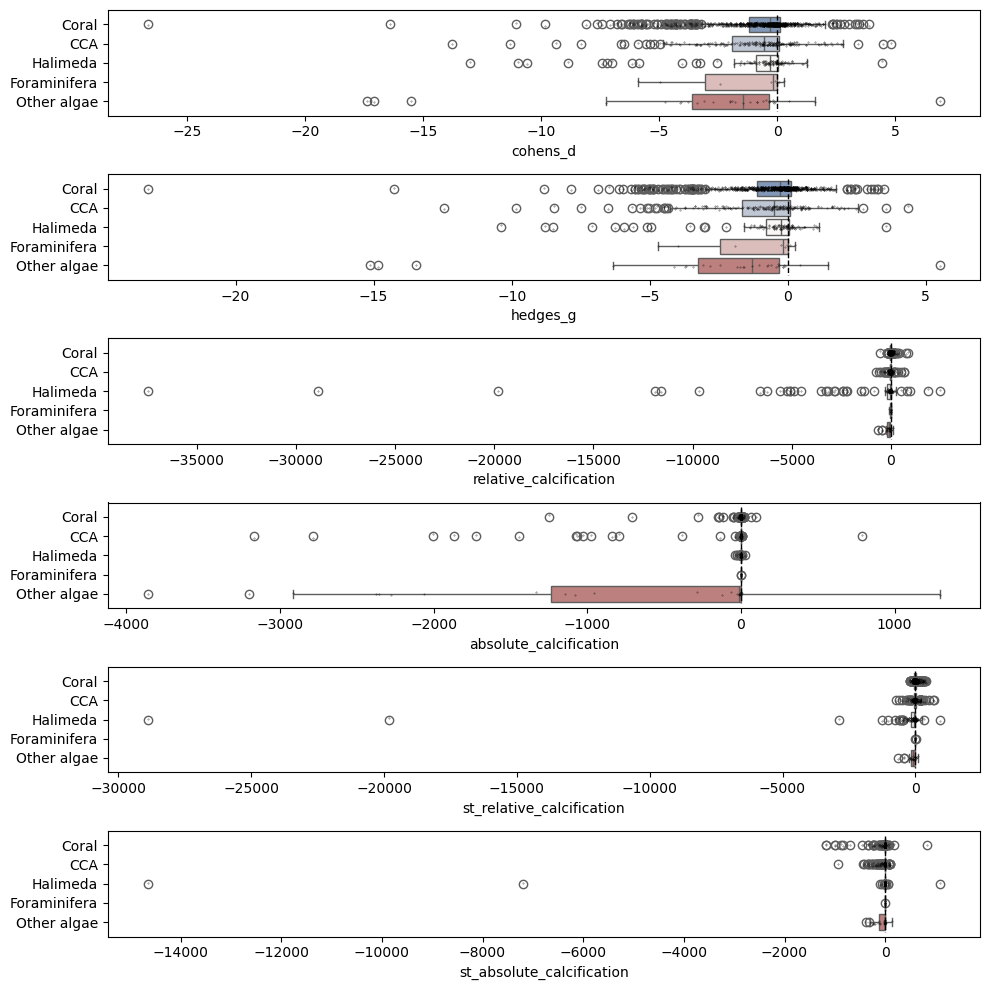

In [39]:
### break down effect size by core_grouping
fig, axes = plt.subplots(len(effect_sizes), 1, figsize=(10, 10), sharex=False)

for i, effect_size in enumerate(
    effect_sizes
):  # plot the effect sizes for each core grouping
    sns.boxplot(
        data=working_effects_df,
        x=effect_size,
        y="core_grouping",
        palette="vlag",
        hue="core_grouping",
        ax=axes[i],
    )
    sns.stripplot(
        data=working_effects_df,
        x=effect_size,
        y="core_grouping",
        ax=axes[i],
        alpha=0.3,
        marker="x",
        s=1,
        color="black",
        linewidth=1,
    )
    axes[i].vlines(
        x=0,
        ymin=-0.5,
        ymax=len(working_effects_df["core_grouping"].unique()) - 0.5,
        color="black",
        linestyle="--",
        linewidth=1,
        zorder=10,
    )
    axes[i].set_ylabel("")
plt.tight_layout()

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_24539/1307762065.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




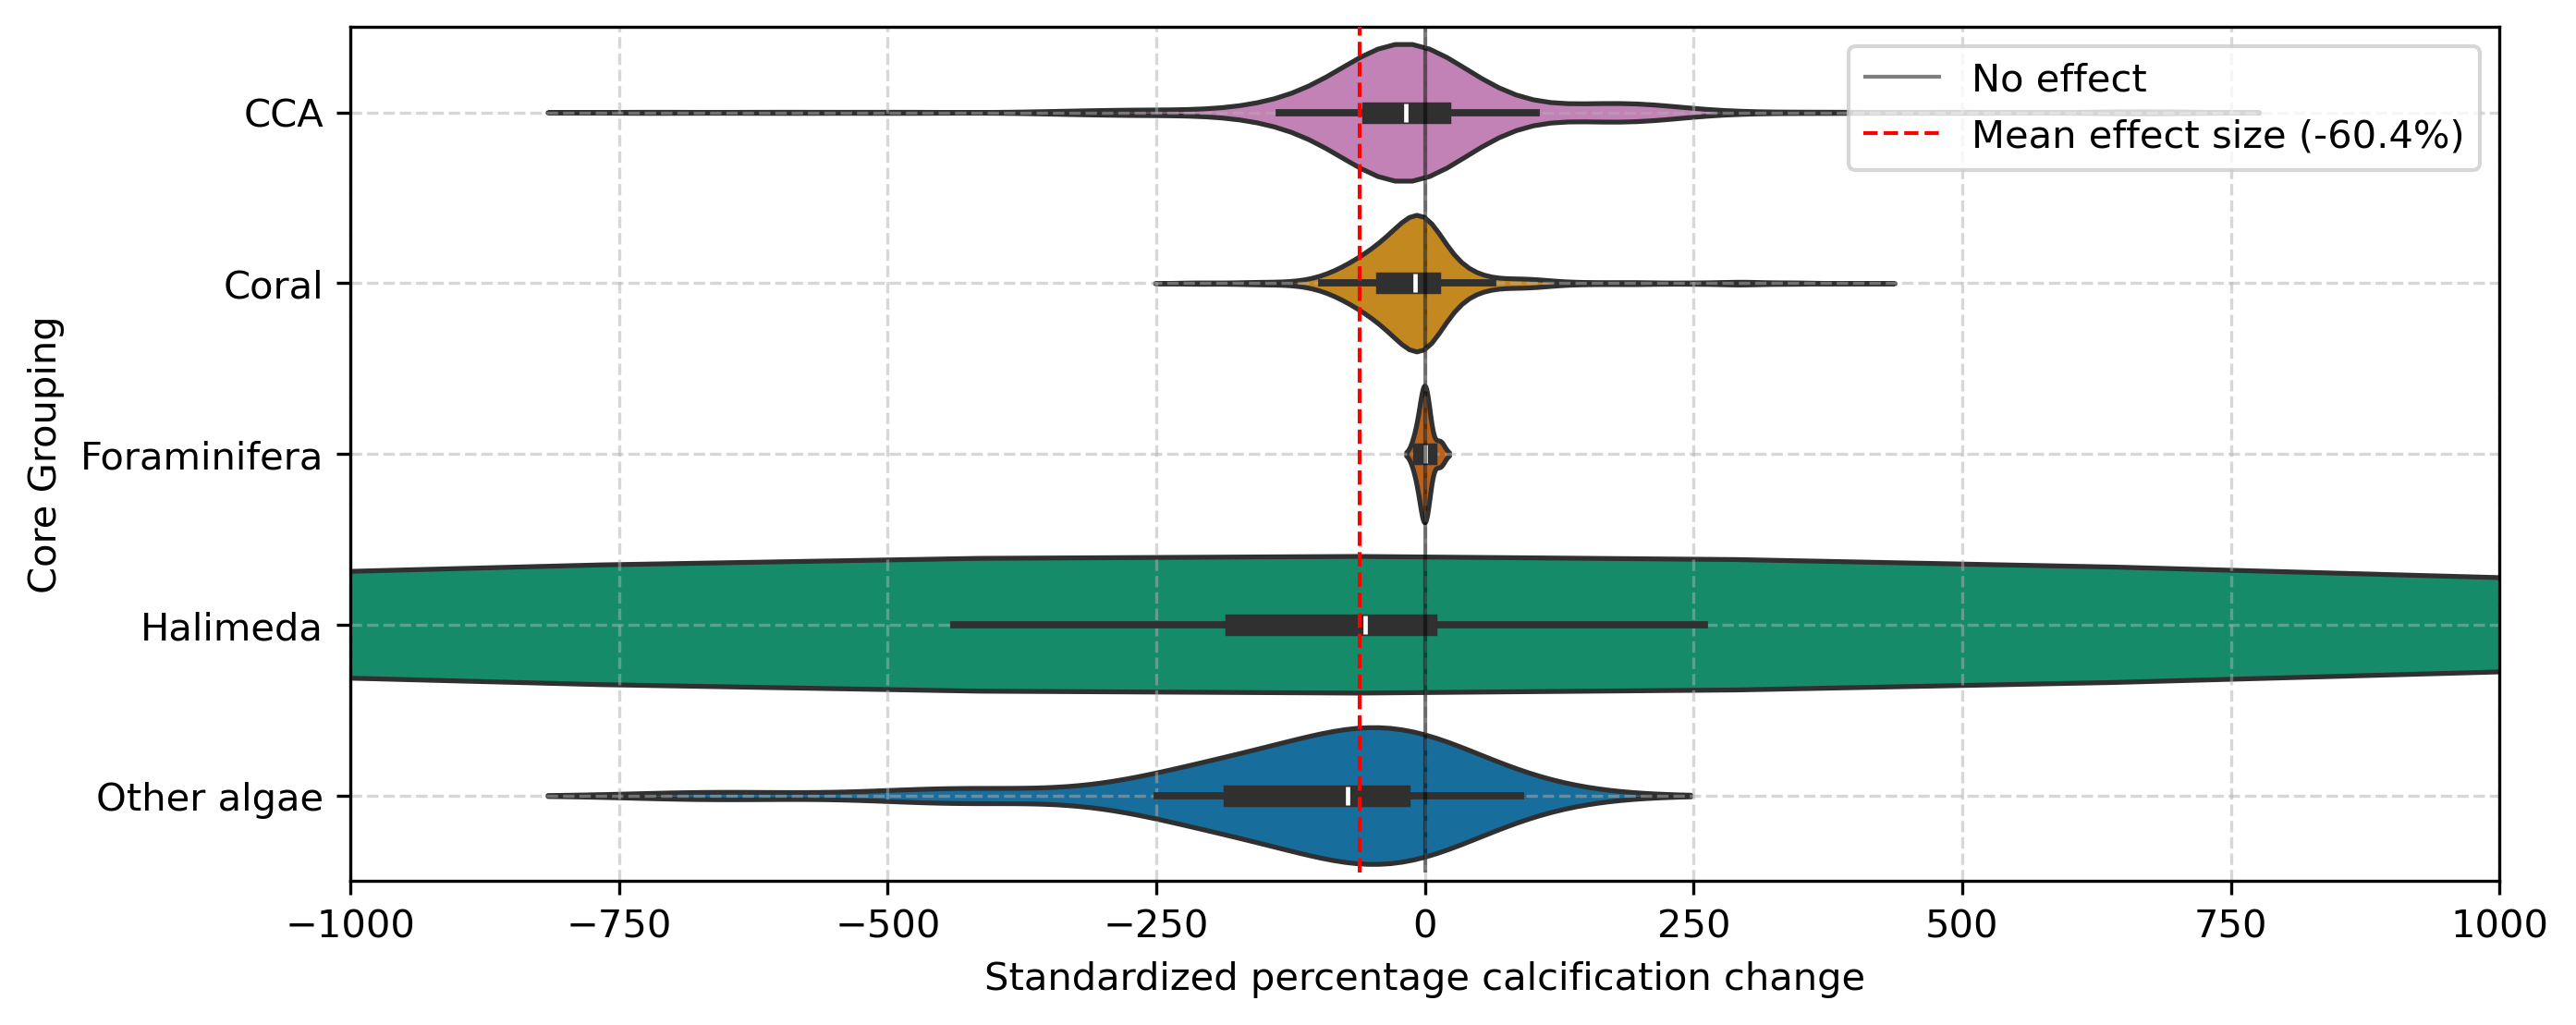

In [40]:
### break down effect size by core_grouping
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

# make seaborn pallet from CG_COLOURS dictionary
cmap = LinearSegmentedColormap.from_list(
    "custom_palette",
    [to_hex(color) for color in plot_config.CG_COLOURS.values()],
    N=len(plot_config.CG_COLOURS),
)
# create a color mapping for the core_grouping
color_mapping = {
    group: cmap(i)
    for i, group in enumerate(ordered_working_effects_df["core_grouping"].unique())
}
# plot the violin plot
sns.violinplot(
    data=working_effects_df.sort_values("core_grouping", ascending=False),
    x="st_relative_calcification",
    y="core_grouping",
    palette=plot_config.CG_COLOURS,
    ax=ax,
)
ax.set_xlim(-1000, 1000)
ax.grid(ls="--", alpha=0.5)
ax.set_ylabel("Core Grouping")
ax.set_xlabel("Standardized percentage calcification change")
ax.vlines(
    x=0,
    ymin=min(ax.get_ylim()) * 0.9,
    ymax=max(ax.get_ylim()) * 1.1,
    color="black",
    linestyle="-",
    linewidth=1,
    alpha=0.5,
    zorder=10,
    label="No effect",
)
ax.set_ylim(
    # min(ax.get_ylim())*0.9,
    -0.5,
    4.5,
)
# plot arrow at mean effect size
mean_effect_size = working_effects_df["st_relative_calcification"].mean()
ax.vlines(
    x=mean_effect_size,
    ymin=min(ax.get_ylim()) * 0.9,
    ymax=max(ax.get_ylim()) * 1.1,
    color="red",
    linestyle="--",
    linewidth=1,
    zorder=10,
    label=f"Mean effect size ({mean_effect_size:.1f}%)",
)
ax.legend(loc="upper right")

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_24539/2067831386.py:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




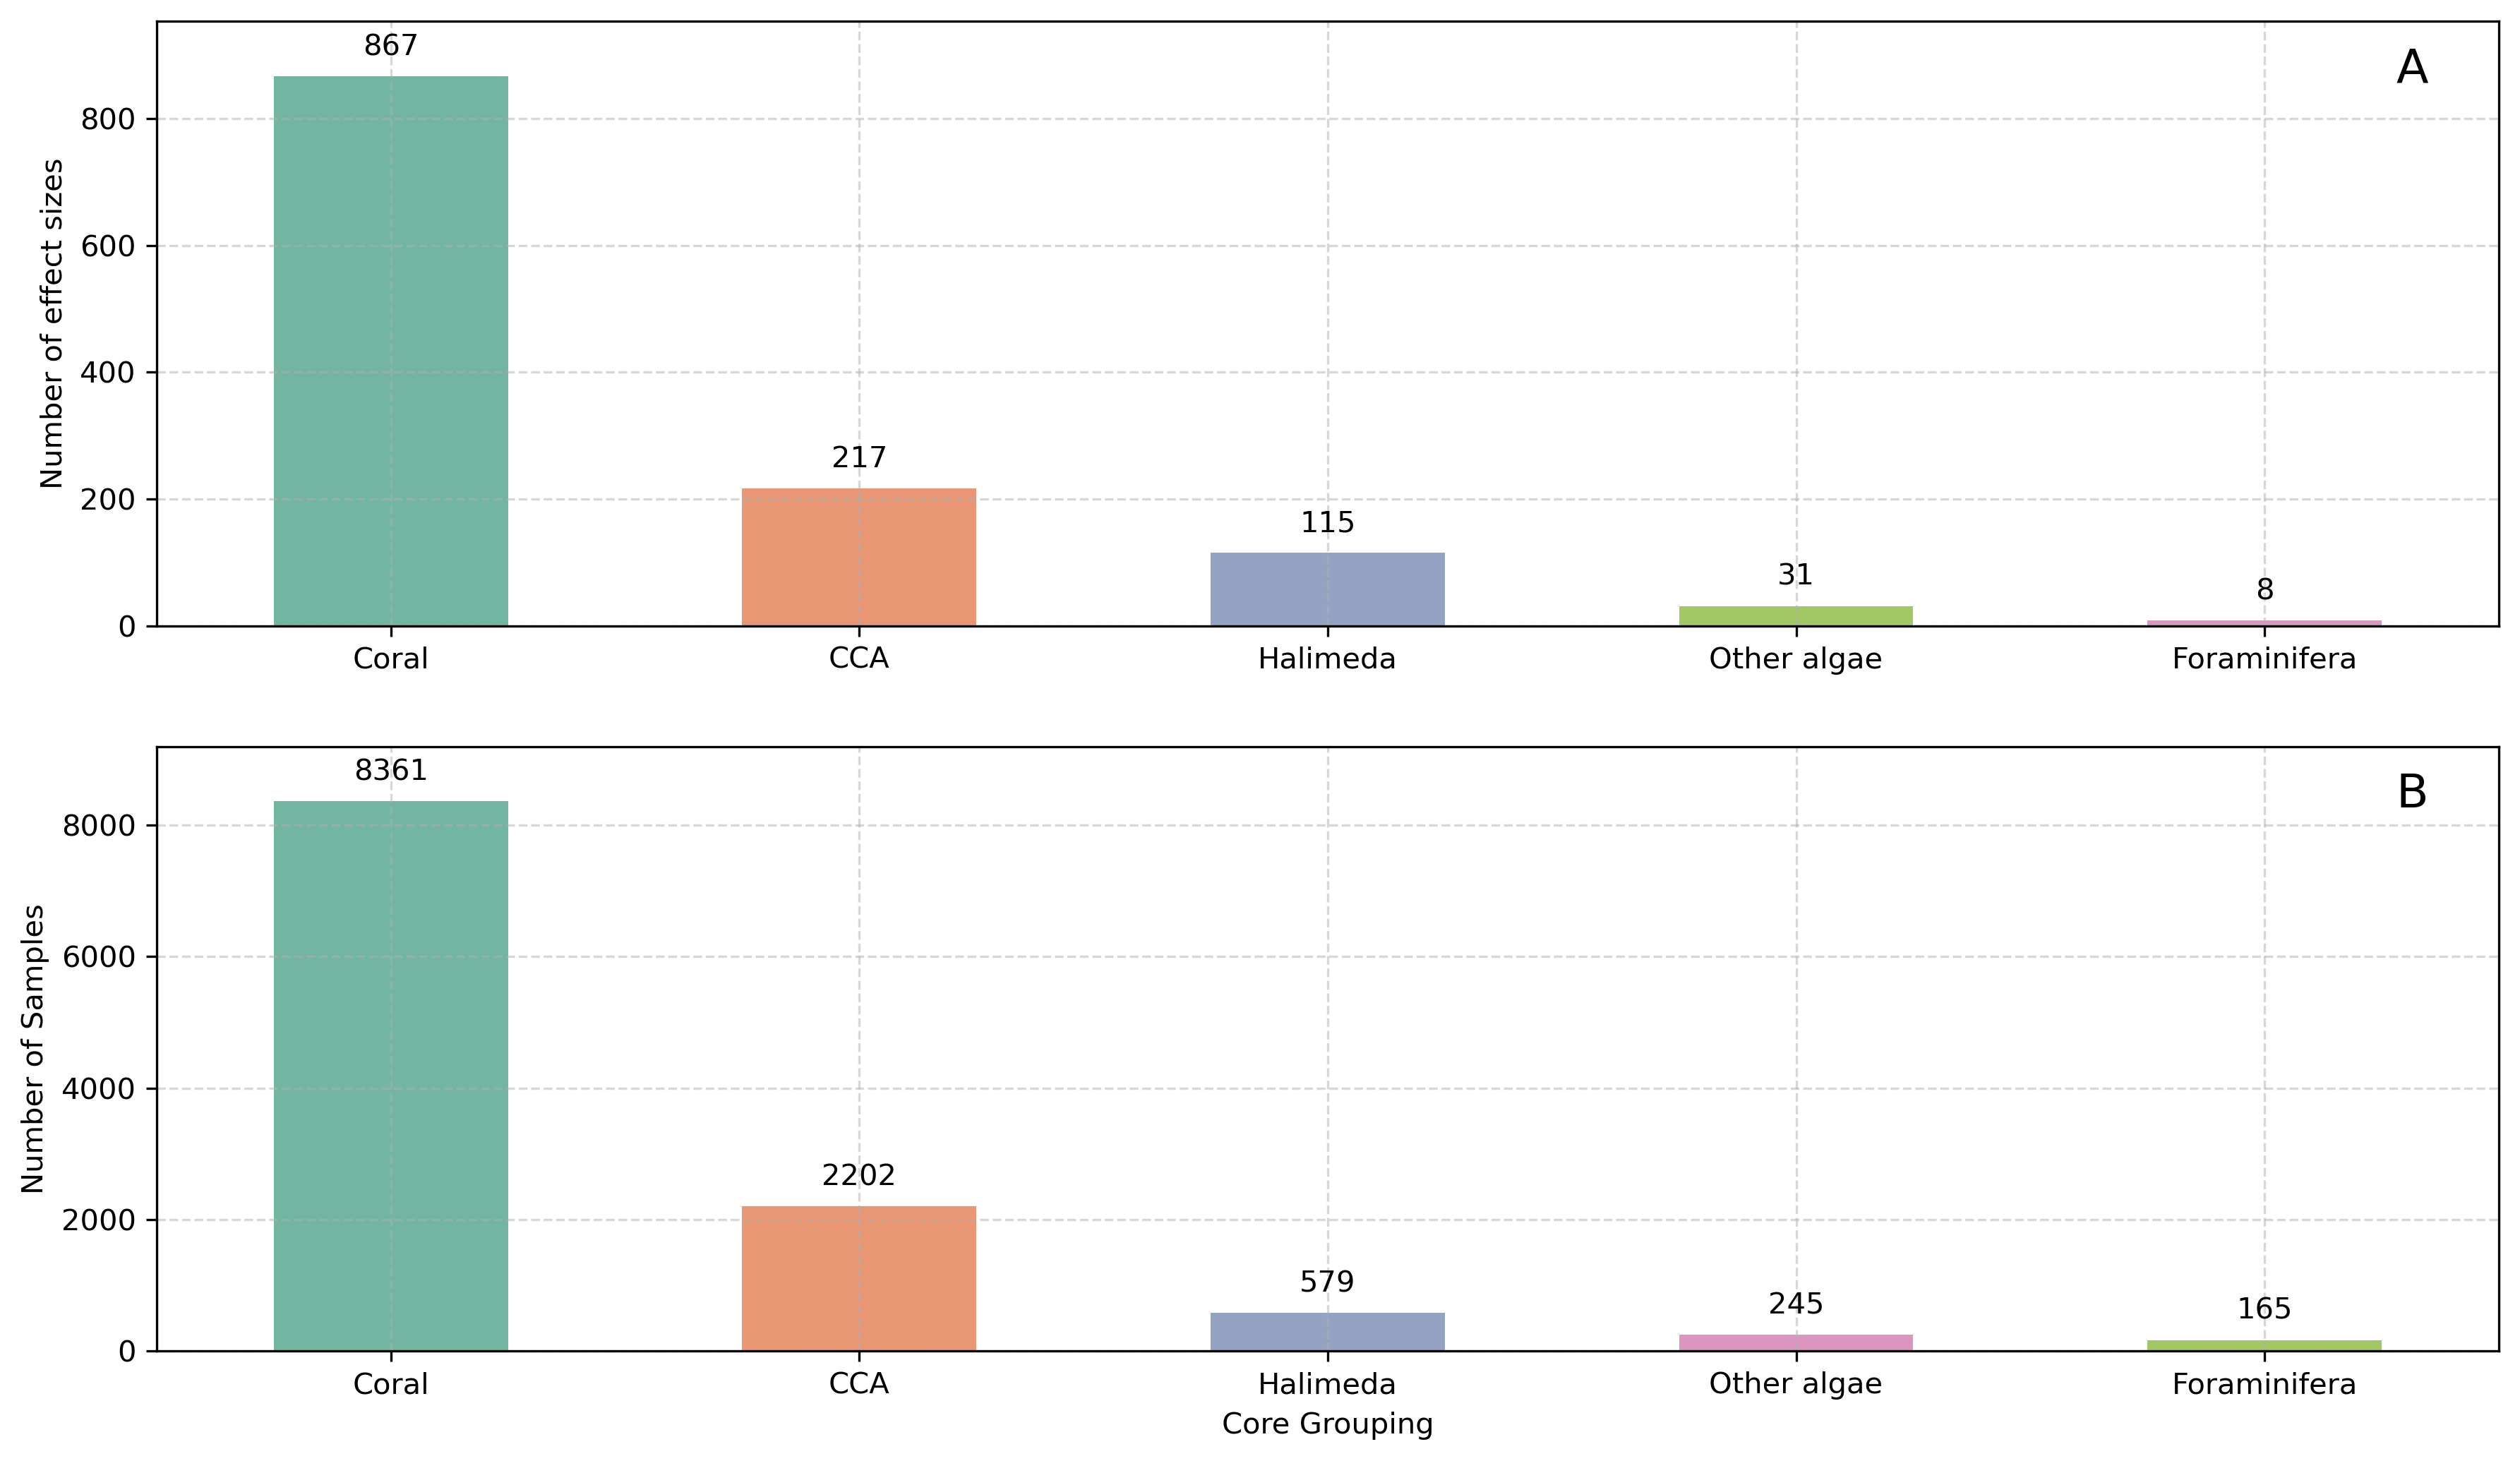

In [41]:
### Combined visualization of the number of effect sizes per core grouping and by number of samples
fig, axes = plt.subplots(2, 1, figsize=(12, 7), dpi=300, sharex=False)

# Plot 1: Number of effect sizes per core grouping
count_order = (
    working_effects_df["core_grouping"].value_counts().index
)  # order by number of effect sizes
sns.countplot(
    data=working_effects_df,
    x="core_grouping",
    order=count_order,
    palette="Set2",
    hue="core_grouping",
    ax=axes[0],
    width=0.5,
)
# Format
for p in axes[0].patches:
    axes[0].annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
axes[0].set_ylim(0, working_effects_df["core_grouping"].value_counts().max() * 1.1)
# axes[0].set_title('Number of Effect Sizes per Core Grouping', fontsize=12)
# axes[0].set_xlabel('Core Grouping')
axes[0].set_ylabel("Number of effect sizes")
axes[0].grid(ls="--", alpha=0.5)

# Plot 2: Number of effect sizes per core grouping by number of samples
cg_sample_counts = (
    working_effects_df.groupby("core_grouping")["n"].sum().sort_values(ascending=False)
)
sns.barplot(
    x=cg_sample_counts.index,
    y=cg_sample_counts.values,
    palette="Set2",
    ax=axes[1],
    width=0.5,
)
# Format
for p in axes[1].patches:
    axes[1].annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
axes[1].set_ylim(0, cg_sample_counts.max() * 1.1)
# axes[1].set_title('Number of Samples Corresponding to Effect Sizes per Core Grouping', fontsize=12)
axes[1].set_xlabel("Core Grouping")
axes[1].set_ylabel("Number of Samples")
axes[1].grid(ls="--", alpha=0.5)
axes[0].set_xlabel(" ")

for i, ax in enumerate(axes.flatten()):
    # fetch coordinates of top right hand corner of specific axis
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # annotate with letter
    ax.annotate(
        chr(65 + i),
        xy=(0.97, 0.92),
        xycoords="axes fraction",
        fontsize=16,
        ha="right",
        va="center",
        # bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    )

# Adjust layout
plt.tight_layout()
plt.show()

Number of distinct types of calcification measurement: 7


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_24539/1793324488.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Number of samples corresponding to effect sizes')

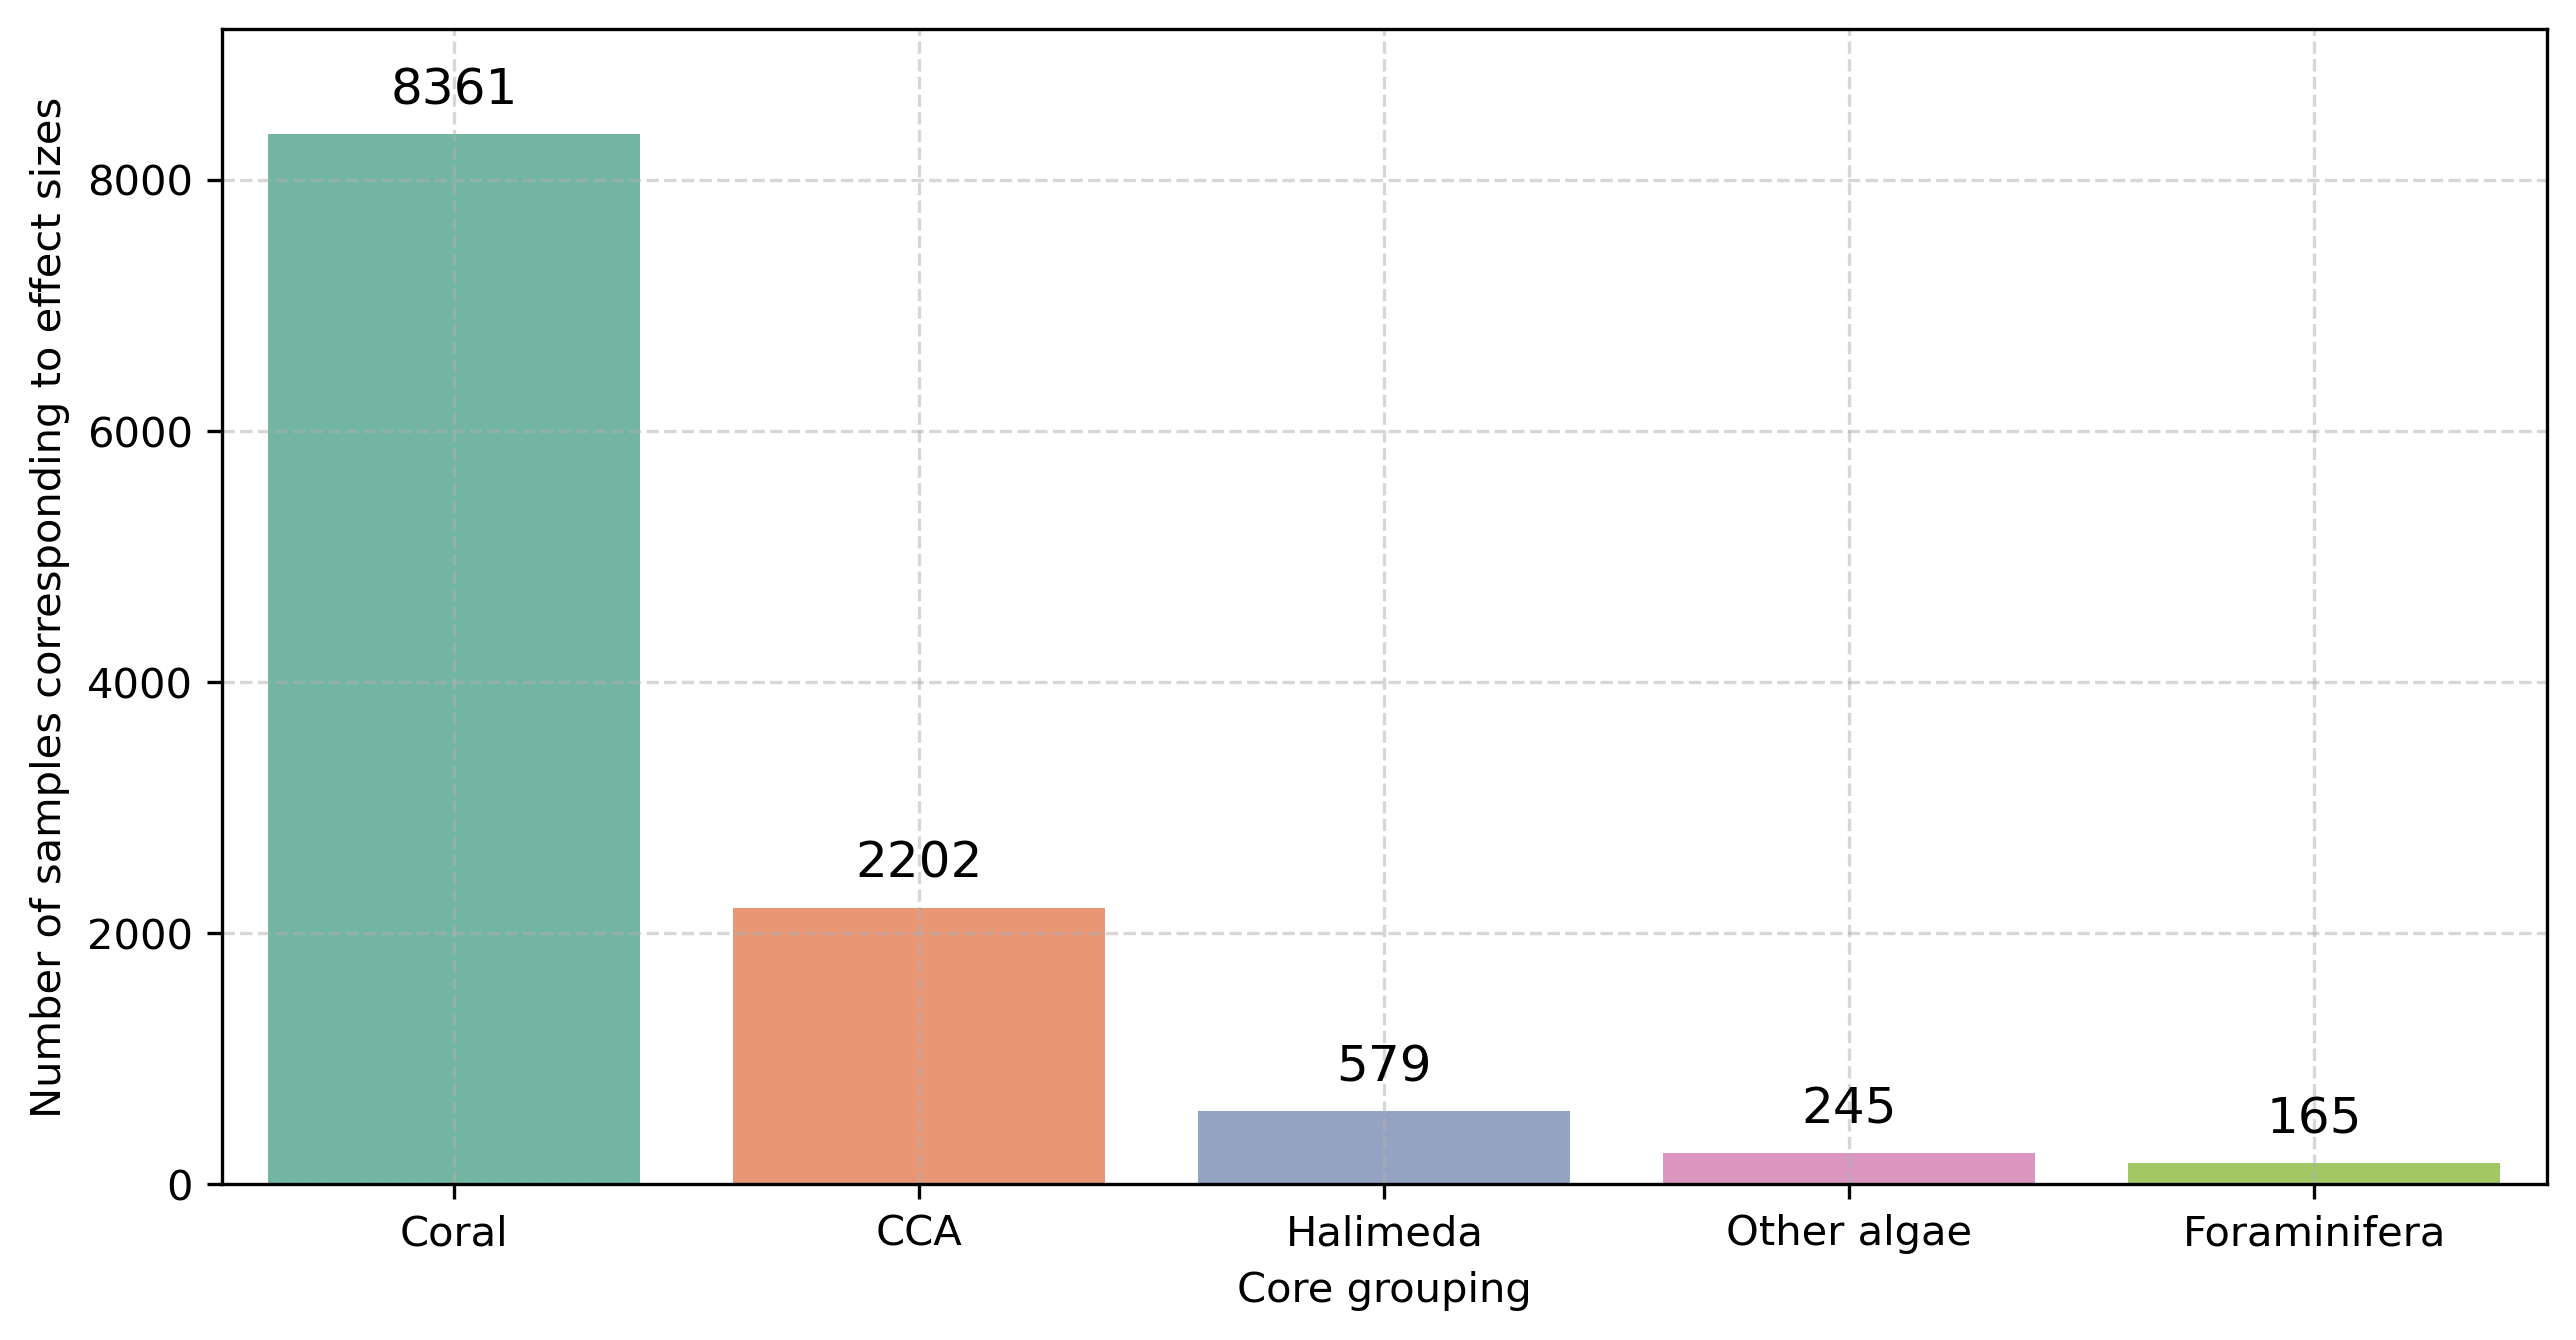

In [42]:
### visualise the number of effect sizes per core grouping, by number of samples
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

cg_sample_counts = (
    working_effects_df.groupby("core_grouping")["n"].sum().sort_values(ascending=False)
)

sns.barplot(x=cg_sample_counts.index, y=cg_sample_counts.values, palette="Set2")
# format
for p in plt.gca().patches:
    plt.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.ylim(0, cg_sample_counts.max() * 1.1)
# plt.title('Number of effect sizes per core grouping')
plt.grid(ls="--", alpha=0.5)
# report
print(
    f"Number of distinct types of calcification measurement: {len(working_df['st_calcification_unit'].unique())}"
)
plt.xlabel("Core grouping")
plt.ylabel("Number of samples corresponding to effect sizes")

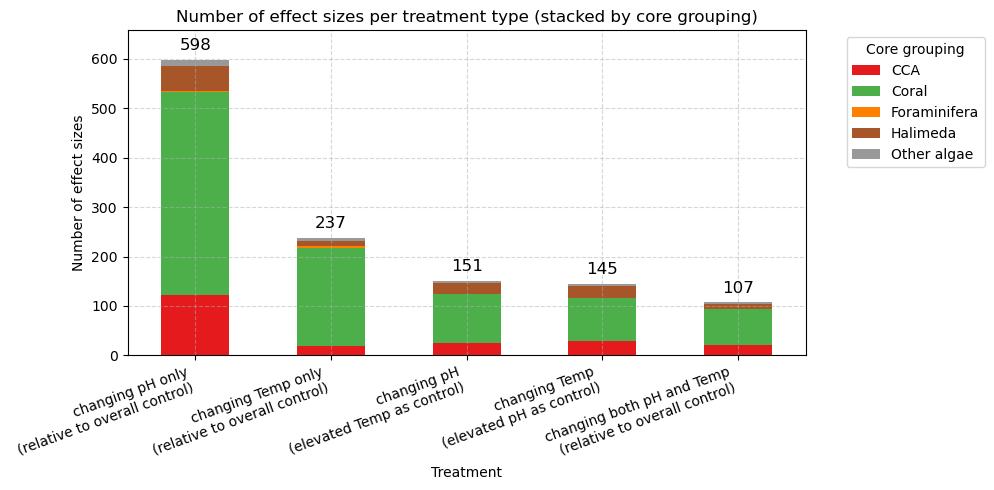

In [43]:
### visualise the number of effect sizes per treatment, stacked by core_grouping
fig, ax = plt.subplots(figsize=(10, 5))

# group by treatment and core_grouping, then count occurrences
stacked_data = (
    working_effects_df.groupby(["treatment", "core_grouping"])
    .size()
    .unstack(fill_value=0)
)
ordered_treatments = stacked_data.sum(axis=1).sort_values(ascending=False).index
# plot
stacked_data.loc[ordered_treatments].plot(
    kind="bar", stacked=True, ax=ax, colormap="Set1"
)

# format
plt.title("Number of effect sizes per treatment type (stacked by core grouping)")
plt.xlabel("Treatment")
plt.ylabel("Number of effect sizes")
plt.grid(ls="--", alpha=0.5)
for i, value in enumerate(stacked_data.loc[ordered_treatments].sum(axis=1).values):
    plt.annotate(
        f"{int(value)}",
        (i, value),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.ylim(0, stacked_data.loc[ordered_treatments].sum(axis=1).max() * 1.1)

# update the x-ticks with the treatment names
treatment_map = {
    "phtot": "changing pH only\n(relative to overall control)",
    "temp": "changing Temp only\n(relative to overall control)",
    "phtot_mv": "changing pH\n(elevated Temp as control)",
    "temp_mv": "changing Temp\n(elevated pH as control)",
    "phtot_temp_mv": "changing both pH and Temp\n(relative to overall control)",
}
ax.set_xticklabels(
    [treatment_map.get(treatment, treatment) for treatment in ordered_treatments],
    rotation=20,
    ha="right",
)

# legend
plt.legend(title="Core grouping", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Skipping DOI 10.1007/s00338-020-01995-7 due to missing latitude/longitude.
Skipping DOI 10.1016/j.jembe.2017.12.008 due to missing latitude/longitude.
Skipping DOI 10.1016/j.marenvres.2022.105610 due to missing latitude/longitude.
Skipping DOI 10.3390/jmse10081106 due to missing latitude/longitude.


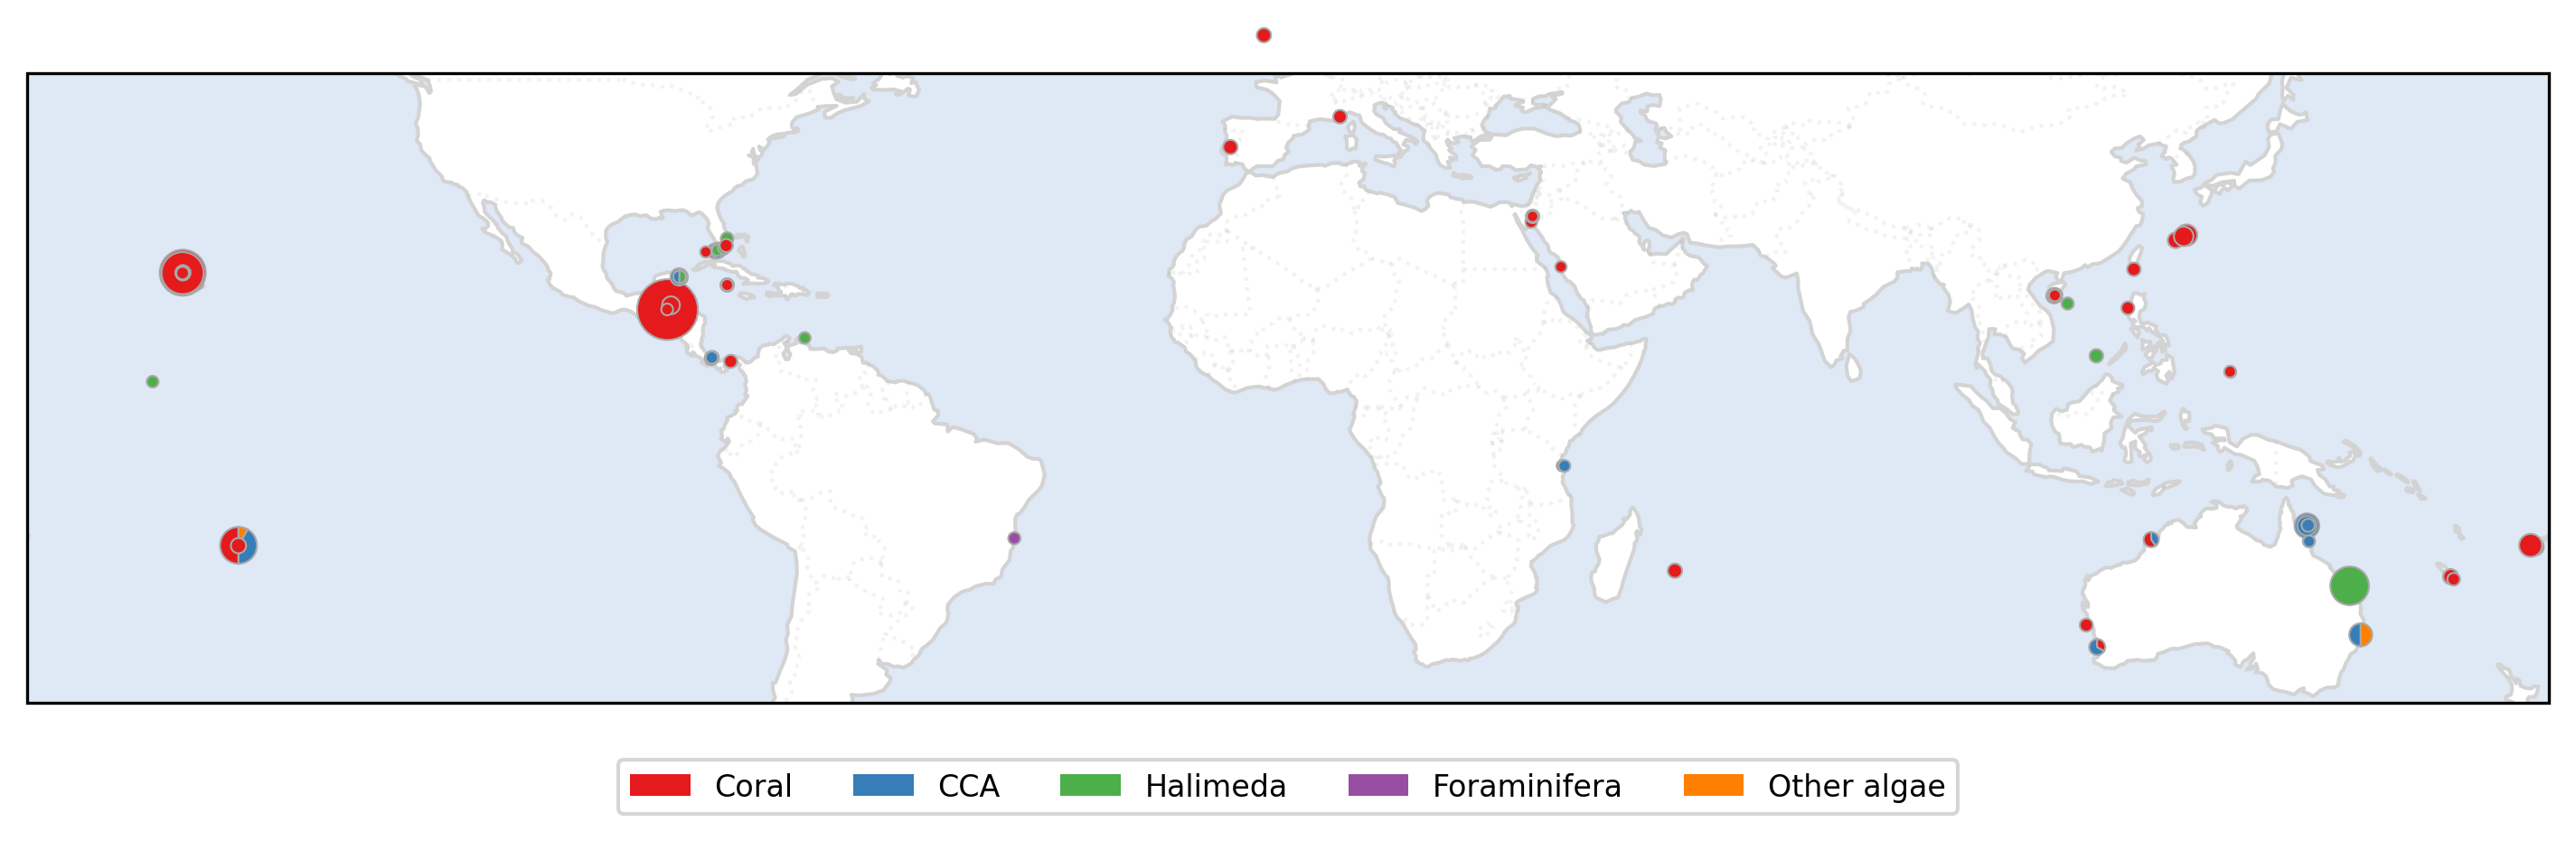

In [44]:
### plot the ratio of effect size types as pie charts on a map
fig, ax = plt.subplots(
    figsize=(12, 6), dpi=300, subplot_kw={"projection": ccrs.PlateCarree()}
)
ax = plot_utils.format_geo_axes(ax)

unique_groups = working_effects_df["core_grouping"].unique()
group_colors = {grp: color for grp, color in zip(unique_groups, plt.cm.Set1.colors)}

for doi, group in working_effects_df.groupby("doi"):
    if group["latitude"].isna().any() or group["longitude"].isna().any():
        print(f"Skipping DOI {doi} due to missing latitude/longitude.")
        continue
    lat = group["latitude"].values[0]
    lon = group["longitude"].values[0]

    group_counts = group[
        "core_grouping"
    ].value_counts()  # count number of effect sizes per core_grouping within this DOI

    if (
        group_counts.empty or group_counts.sum() == 0
    ):  # if nothing to plot, or zero counts
        continue
    sizes = group_counts.values
    labels = group_counts.index

    # only plot groups with non-zero counts
    valid_indices = [i for i, size in enumerate(sizes) if size > 0]
    if not valid_indices:
        continue
    sizes = [sizes[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    colors = [group_colors[labels[i]] for i in valid_indices]

    # scale pie chart size by total number of effect sizes
    n_effect_sizes = sum(sizes)
    size = 0.05 + n_effect_sizes * 0.002  # manually tweaked

    # create inset axis at the study's geographic location
    pie_ax = inset_axes(
        ax,
        width=size,
        height=size,
        loc="center",
        bbox_to_anchor=(lon, lat),
        bbox_transform=ax.transData,
        borderpad=0,
    )
    if len(sizes) > 0:
        wedges, _ = pie_ax.pie(
            sizes,
            colors=colors,
            startangle=90,
            wedgeprops={"edgecolor": "darkgrey", "linewidth": 0.5},
        )
        pie_ax.set_aspect("equal")
        pie_ax.axis("off")  # hide pie chart axis

legend_elements = [
    Patch(facecolor=group_colors[grp], label=str(grp)) for grp in unique_groups
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.2),
    ncols=len(unique_groups),
    fontsize=8,
)

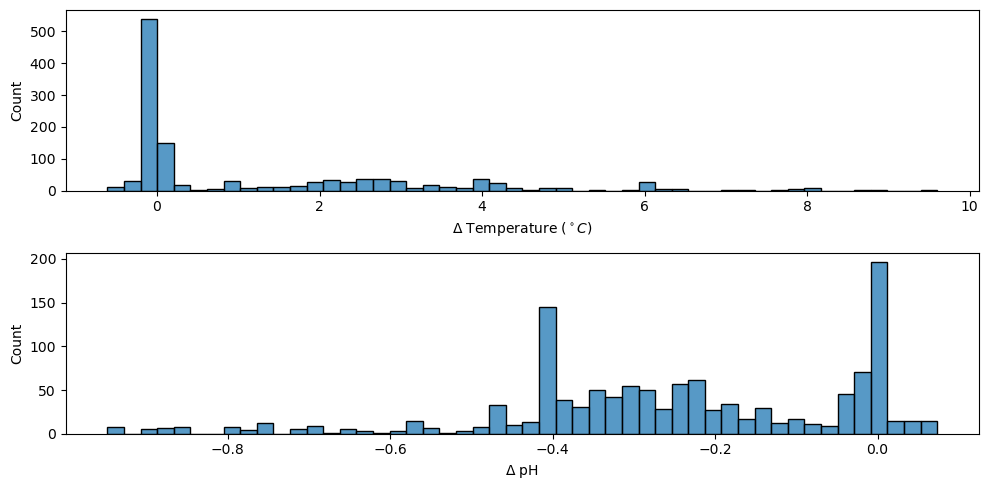

In [45]:
### plot distribution of delta ph and delta_t
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
# Plot delta_t
sns.histplot(
    data=working_effects_df,
    x="delta_t",
    bins=50,
    ax=axes[0],
)
axes[0].set_xlabel("$\\Delta$ Temperature ($^\\circ C$)")
# Plot delta_pH
sns.histplot(
    data=working_effects_df,
    x="delta_ph",
    bins=50,
    ax=axes[1],
)
axes[1].set_xlabel("$\\Delta$ pH")
plt.tight_layout()

## Meta-regression

In [46]:
### set effect type for all proceeding cells
effect_type = "st_relative_calcification"
print(
    f"{working_effects_df.treatment.value_counts()}\n\t\t of {len(working_effects_df)} total effect sizes"
)

treatment
phtot            598
temp             237
phtot_mv         151
temp_mv          145
phtot_temp_mv    107
Name: count, dtype: int64
		 of 1238 total effect sizes


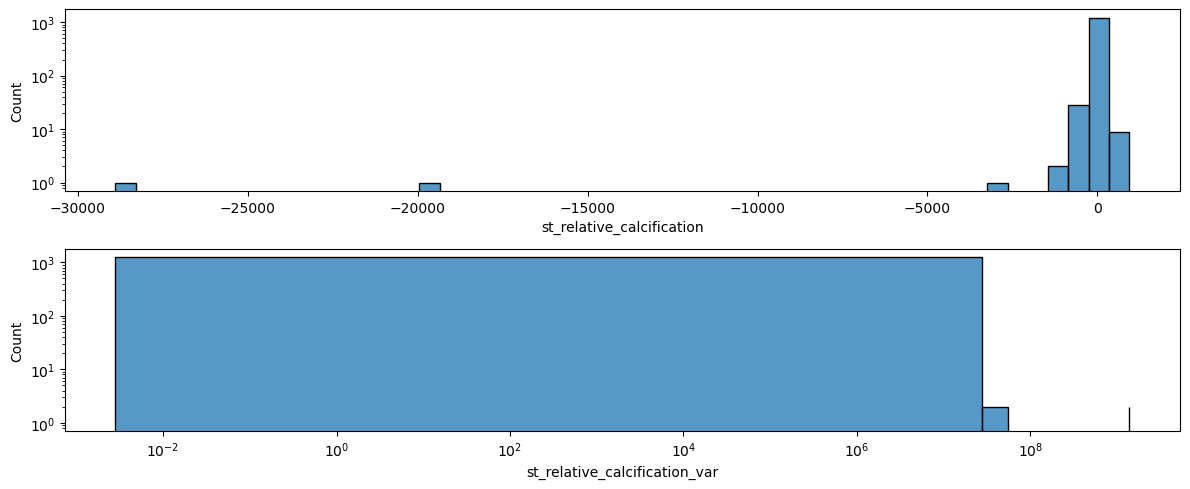

In [47]:
### visualise distribution of effect sizes and their variances for outlier removal
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharey=True)
# plot
sns.histplot(
    data=working_effects_df,
    x=effect_type,
    bins=50,
    ax=ax[0],
)
sns.histplot(
    data=working_effects_df,
    x="st_relative_calcification_var",
    bins=50,
    ax=ax[1],
)
# format
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()


Number of effect sizes before filtering: 1238
Number of effect sizes after filtering: 1103


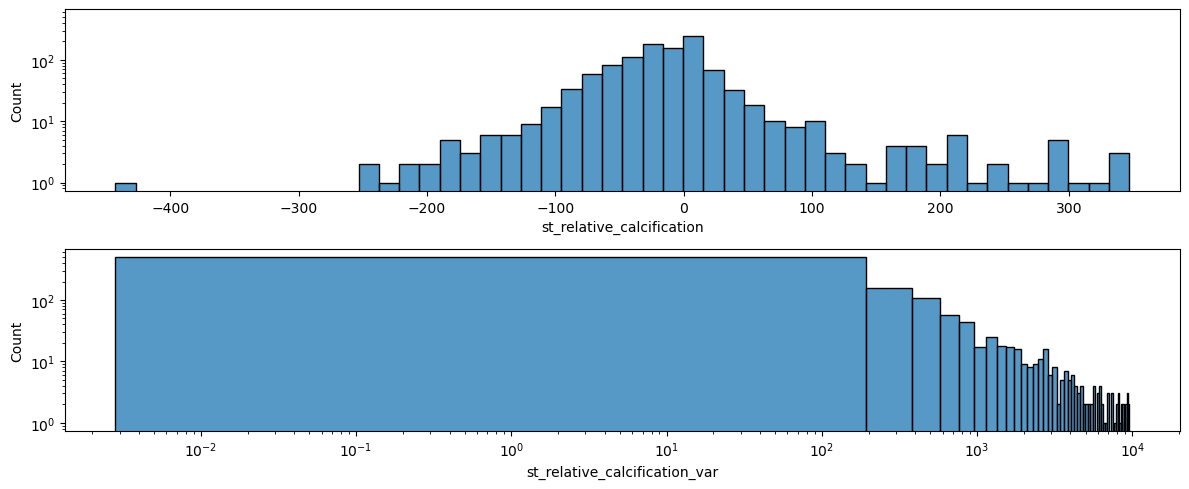

In [48]:
### filter outliers via robust z-score

filtered_effects_df = working_effects_df.copy()
# add 0.001 to any 0 st_relative_calcification_var values
# filtered_effects_df['st_relative_calcification_var'] = filtered_effects_df['st_relative_calcification_var'].replace(0, 0.001).infer_objects(copy=False)

filtered_effects_df = filtered_effects_df[
    analysis.filter_robust_zscore(filtered_effects_df["st_relative_calcification"])
    & analysis.filter_robust_zscore(
        filtered_effects_df["st_relative_calcification_var"]
    )
]
# print removal stats
print(f"Number of effect sizes before filtering: {len(working_effects_df)}")
print(f"Number of effect sizes after filtering: {len(filtered_effects_df)}")

### visualise distribution of effect sizes and their variances for outlier removal
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharey=True)
# plot
sns.histplot(
    data=filtered_effects_df,
    x=effect_type,
    bins=50,
    ax=ax[0],
)
sns.histplot(
    data=filtered_effects_df,
    x="st_relative_calcification_var",
    bins=50,
    ax=ax[1],
)
# format
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()